# Machine Learning for Level Truncation in Open String Field Theory

## Abstract

In the framework of bosonic Open String Field Theory (OSFT), we consider several observables characterised by conformal weight and type, and the position of vacua in the potential for various values of truncated mass level. We focus on the prediction of the extrapolated value for the level-$\infty$ truncation using Machine Learning (ML) techniques.

# Setup

In this section we prepare the analysis: we take a look at the present configuration, set the number of threads used in the analysis, prepare log files and create a structure for the directories.

In [1]:
# reload modules when running the notebook
%load_ext autoreload
%autoreload 2

## Specifications

The current analysis runs on a machine with the following specifications:

In [2]:
!echo "CPU: $(head /proc/cpuinfo | awk -F': ' '/^model name/ {print $2}')"
!echo "GPU: $(lspci | awk -F': ' '/3D controller/ {print $2}')"
!echo "RAM: $(free --giga| awk '/^Mem/ {print $7}')GB available"

CPU: Intel(R) Core(TM) i7-7700HQ CPU @ 2.80GHz
GPU: NVIDIA Corporation GM108M [GeForce 940MX] (rev a2)
RAM: 11GB available


We then set the number of cores used in this analysis for parallel computations:

In [3]:
from os import cpu_count

# set no. of threads
THREADS = 8
MAX_THREADS = cpu_count()

# sanity check: cannot use more than available
if THREADS > MAX_THREADS:
    THREADS = MAX_THREADS

# print summary
print('Using {:d} of {:d} threads available.'.format(THREADS, MAX_THREADS))

Using 8 of 8 threads available.


We then create the directory structure for output, logs, code, data, and images. Everything will be considered with respect to the root directory containing this notebook.

In [4]:
from os import path, makedirs

# define directory names
ROOT_DIR = '.'
IMG_DIR  = 'img'
MOD_DIR  = 'mod'
LOG_DIR  = 'log'
DAT_DIR  = 'dat'
OUT_DIR  = 'out'

# get the name of the dataset
DB_NAME = 'data_sft_dict'
DB_FILE = DB_NAME + '.json'
DB_PATH = path.join(ROOT_DIR, DB_FILE)

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR)
print('Images: {}'.format(IMG_PATH))
MOD_PATH = path.join(ROOT_DIR, MOD_DIR)
print('Models: {}'.format(MOD_PATH))
LOG_PATH = path.join(ROOT_DIR, LOG_DIR)
print('Logs:   {}'.format(LOG_PATH))
DAT_PATH = path.join(ROOT_DIR, DAT_DIR)
print('Data:   {}'.format(DAT_PATH))
OUT_PATH = path.join(ROOT_DIR, OUT_DIR)
print('Other:  {}'.format(OUT_PATH))

# define shortcuts for path of images, models, logs, data, etc.
imgpath = lambda s: path.join(IMG_PATH, s)
modpath = lambda s: path.join(MOD_PATH, s)
logpath = lambda s: path.join(LOG_PATH, s)
datpath = lambda s: path.join(DAT_PATH, s)
outpath = lambda s: path.join(OUT_PATH, s)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok = True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok = True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok = True)
if not path.isdir(DAT_PATH):
    makedirs(DAT_PATH, exist_ok = True)
if not path.isdir(OUT_PATH):
    makedirs(OUT_PATH, exist_ok = True)

Images: ./img
Models: ./mod
Logs:   ./log
Data:   ./dat
Other:  ./out


We save relevant debugging output to a log file containing dates, times and information on the operations to be able to easily find issues in the analysis.

In [5]:
import logging

from os   import path, rename
from time import strftime, gmtime

# call the log with the same name as the dataset we use
logname  = DB_NAME 
filename = path.join(LOG_PATH, DB_NAME + '.log')
ctime    = strftime('_%Y%m%d.%H%M%S', gmtime())
level    = logging.DEBUG

# rotate the log if one is already present
if path.isfile(filename):
    rename(filename, filename + ctime)

# print the log to file
log = logging.getLogger(logname + ctime)
fmt = logging.Formatter('%(asctime)s: %(levelname)s ==> %(message)s')
han = logging.FileHandler(filename = filename)
log.setLevel(level)
han.setLevel(level)
han.setFormatter(fmt)
log.addHandler(han)

# write introduction to log
log.info('\n\n'
         '--------------------------------------------\n'
         '  MACHINE LEARNING FOR LEVEL TRUNCATION IN\n'
         '  BOSONIC OPEN STRING FIELD THEORY\n\n'
         '--------------------------------------------\n'
         '  Authors: Harold Erbin, Riccardo Finotello\n'
         '--------------------------------------------\n'
         '  Abstract:\n\n'
         '  We consider the position of the lumps of\n'
         '  the tachyon potential in bosonic open\n'
         '  string field theory at a finite mass level\n'
         '  truncation. We then extrapolate the\n'
         '  predictions for level-$\infty$ using\n'
         '  machine learning techniques.\n\n'
        )

print('Current log: {}'.format(filename))

Current log: ./log/data_sft_dict.log


We finally import the modules we use in the analysis and check their version for issues tracking.

In [6]:
# check Python version
import sys
assert sys.version_info.major > 2 and sys.version_info.minor > 5
print('Python version: {}.{}.{}'.format(sys.version_info.major,
                                        sys.version_info.minor,
                                        sys.version_info.micro
                                       )
     )

# import Numpy
import numpy as np
assert np.__version__ >= '1.18'
print('Numpy version:           {}'.format(np.__version__))

# import Pandas
import pandas as pd
assert pd.__version__  >= '1.0'
print('Pandas version:          {}'.format(pd.__version__))

# import Seaborn and Matplotlib
import seaborn           as sns
import matplotlib        as mpl
import matplotlib.pyplot as plt
assert mpl.__version__ >= '3.1' and sns.__version__ >= '0.10'
print('Matplotlib version:      {}'.format(mpl.__version__))
print('Seaborn version:         {}'.format(sns.__version__))
%matplotlib inline

sns.set()
subplots = lambda x, y: plt.subplots(x, y, figsize=(y*6, x*5))

# import Scikit-learn and Scikit-optimize
import sklearn
import skopt
assert sklearn.__version__ >= '0.22' and skopt.__version__ >= '0.7'
print('Scikit-learn version:    {}'.format(sklearn.__version__))
print('Scikit-optimize version: {}'.format(skopt.__version__))

# import Tensorflow (check that Keras is included: v2.0+)
import tensorflow as tf
assert tf.__version__ > '2.0'
print('Tensorflow version:      {}'.format(tf.__version__))

# check the warnings (I can't really handle UserWarnings unfortunately...)
import warnings
warnings.simplefilter('ignore', category = UserWarning)

# set the random state for reproducibility
RAND = 121
np.random.seed(RAND)
np.random.RandomState(RAND)
tf.random.set_seed(RAND)

Python version: 3.8.3
Numpy version:           1.18.5
Pandas version:          1.0.5
Matplotlib version:      3.2.2
Seaborn version:         0.10.1
Scikit-learn version:    0.23.1
Scikit-optimize version: 0.7.4
Tensorflow version:      2.2.0


For some computations we will be using GPU acceleration: we fix the amount of memory accessible by the GPU in order to limit its growth and to allocate only the necessary amount at runtime.

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU') # physical GPUs
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
log.debug('Set GPU memeory growth.')

## Importing the Dataset

The environment being ready for the analysis, we now import the dataset and take a look at its characteristics and properties. We then proceed to tidy up its content for the analysis.

For the extraction of the dataset we use `pandas` to read from the original format (JSON):

In [8]:
df = None

# check if file exists
if path.isfile(DB_PATH):
    df = pd.read_json(DB_PATH)

# check if object is in the environment
if df is None:
    log.error('Cannot load database from JSON file!')
else:
    log.debug('Database correctly imported.')

As a reference, we show the composition of the dataset highlighting its composition and data types stored:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46 entries, 0 to 45
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   init    46 non-null     object
 1   exp     46 non-null     object
 2   weight  46 non-null     object
 3   type    46 non-null     object
 4   2       46 non-null     object
 5   3       46 non-null     object
 6   4       46 non-null     object
 7   5       46 non-null     object
 8   6       46 non-null     object
 9   7       46 non-null     object
 10  8       46 non-null     object
 11  9       46 non-null     object
 12  10      46 non-null     object
 13  11      46 non-null     object
 14  12      46 non-null     object
 15  13      46 non-null     object
 16  14      46 non-null     object
 17  15      46 non-null     object
 18  16      46 non-null     object
 19  17      46 non-null     object
 20  18      46 non-null     object
dtypes: object(21)
memory usage: 7.7+ KB


The database stores its data in a non tidy format (`object` _dtype_ is generic). Its dimensions are:

In [10]:
df_nrow, df_ncol = df.shape
print("Rows:    {:d}".format(df_nrow))
print("Columns: {:d}".format(df_ncol))

Rows:    46
Columns: 21


Columns are already named but the truncation levels have numeric names which might lead to confusion. We rename them to avoid issues with other numeric entries.

In [11]:
import re

# rename columns with numbers in their name
colrename = lambda s: re.sub(r'^([0-9]*)$', r'level_\1', s)
df        = df.rename(columns=colrename)

The new columns are therefore named:

In [12]:
list(df.columns)
log.info('Columns in the database: {}'.format(df.columns))

The elements of the dataset are vectors containing **solutions for different radii** in the rows. For each row various observables have been computed: `type` refers to the **oscillations** in the level dependence, while `weight` is the conformal property identifying each variable.

In [13]:
df.head(3)

,init,exp,weight,type,level_2,level_3,level_4,level_5,level_6,level_7,...,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18
0,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.25, 1, 2.25, 4, 0, 0.25, ...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]",...,"[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]","[1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1]"
1,"[1.0001, 0, 1.0001, 1.0001, 1.0001, 1.0001, 0,...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.249950007499, 0.999800029...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000099754465899, -4.382819109385611e-08, 0....","[1.000099754261711, -6.385189815988693e-08, 0....","[1.000099495309939, -1.9972775228453091e-07, 0...","[1.000099494726808, -1.724421881015622e-07, 0....","[1.000099223845491, -3.2173432889712715e-07, 0...","[1.000099222907449, -2.856173963606407e-07, 0....",...,"[1.000098951488667, -3.9768513795577186e-07, 0...","[1.000098684133785, -5.470716468222031e-07, 0....","[1.000098682609473, -5.081256574169557e-07, 0....","[1.000098418312006, -6.559751804689415e-07, 0....","[1.000098416531483, -6.169537248661669e-07, 0....","[1.000098155198292, -7.630807670831046e-07, 0....","[1.000098153176776, -7.242020485026188e-07, 0....","[1.000097894670832, -8.685182838696036e-07, 0....","[1.000097892420157, -8.29888184051414e-07, 0.9...","[1.000097636616163, -9.72346758033437e-07, 0.9..."
2,"[1.001, 0, 1.001, 1.001, 1.001, 1.001, 0, 0, 0...","[1, 0, -1, 1, -1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0]","[0, 0, 1, 4, 9, 0, 0.24950074900124802, 0.9980...","[2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]","[1.000976232275641, -3.8820163895943e-06, 0.90...","[1.000976049237533, -5.9682788728782085e-06, 0...","[1.000952815386108, -1.689178344782202e-05, 0....","[1.000952352120989, -1.5047680126166993e-05, 0...","[1.000929855311967, -2.5515953552563565e-05, 0...","[1.000929190755388, -2.3264350581688953e-05, 0...",...,"[1.0009075350494, -3.03802946004187e-05, 0.664...","[1.000888236249875, -3.860013055708573e-05, 0....","[1.000887354078869, -3.657126395737419e-05, 0....","[1.000869431716091, -4.387998808033297e-05, 0....","[1.000868490272024, -4.199905525467674e-05, 0....","[1.000851773655717, -4.853491335211209e-05, 0....","[1.000850791489764, -4.6788451470318466e-05, 0...","[1.000835137520457, -5.266383019452565e-05, 0....","[1.000834127701389, -5.1036790056833293e-05, 0...","[1.000819417460843, -5.634321216588246e-05, 0...."


The number of observables in each row is not unique across the datasets. In fact we can check that they are unique only in the same row, but they increase in the column direction:

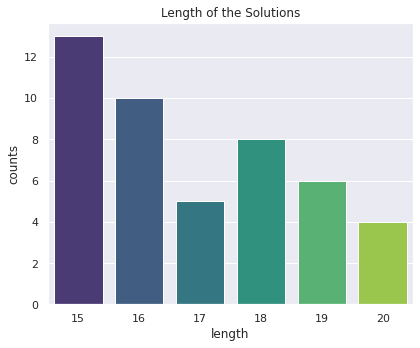

In [14]:
# get the length of each list and find the unique values
shapes = df.applymap(len)
shapes = shapes.apply(lambda x: np.unique(x).squeeze(), axis=1)

# plot the counts for each shape (treat it as categorical)
fig, ax = subplots(1, 1)

sns.countplot(x=shapes.values,
              palette='viridis',
              ax=ax
             )
ax.set(xlabel='length',
       ylabel='counts',
       title='Length of the Solutions'
      )

plt.tight_layout()
plt.savefig(imgpath('length-solutions.pdf'), dpi=150, format='pdf')

## Tidying Up the Dataset

We then proceed to tidy the dataset in such a way that each column stores only one "observation" of the solutions. We first insert a column labelling the solutions **for each** entry.

In [15]:
# add the ID of the solution
solutions = [] #------------------------------------ create a list of vectors
for n in range(shapes.shape[0]):
    solutions.append(np.full(shapes.iloc[n], n)) #-- insert vec. of the IDs

# add the column to the dataset and reorder
df['solutions'] = solutions
df = df[['solutions',
         'init',
         'weight',
         'type',
         'exp',
         'level_2',
         'level_3',
         'level_4',
         'level_5',
         'level_6',
         'level_7',
         'level_8',
         'level_9',
         'level_10',
         'level_11',
         'level_12',
         'level_13',
         'level_14',
         'level_15',
         'level_16',
         'level_17',
         'level_18'
        ]
       ]

We then stack each column on top of the other by creating a `pandas` dataframe for each row and then putting them one on top of the other:

In [16]:
df = pd.concat([pd.DataFrame({f: df[f].iloc[n] for f in df})
                for n in range(df.shape[0]) 
               ],
               axis=0,
               ignore_index=True
              ) 

The dataset now holds only numeric types:

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 778 entries, 0 to 777
Data columns (total 22 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   solutions  778 non-null    int64  
 1   init       778 non-null    float64
 2   weight     778 non-null    float64
 3   type       778 non-null    int64  
 4   exp        778 non-null    int64  
 5   level_2    778 non-null    float64
 6   level_3    778 non-null    float64
 7   level_4    778 non-null    float64
 8   level_5    778 non-null    float64
 9   level_6    778 non-null    float64
 10  level_7    778 non-null    float64
 11  level_8    778 non-null    float64
 12  level_9    778 non-null    float64
 13  level_10   778 non-null    float64
 14  level_11   778 non-null    float64
 15  level_12   778 non-null    float64
 16  level_13   778 non-null    float64
 17  level_14   778 non-null    float64
 18  level_15   778 non-null    float64
 19  level_16   778 non-null    float64
 20  level_17  

We can therefore have a description of the variables. In particular we first take a look at the initial points, weights, types and the labels:

In [18]:
df[['init', 'weight', 'type', 'exp']].describe()

,init,weight,type,exp
count,778.000000,778.000000,778.000000,778.000000
mean,0.895644,1.866132,3.763496,0.565553
std,1.010897,2.316228,0.646228,0.694858
min,0.000000,0.000000,2.000000,-1.000000
25%,0.000000,0.040412,4.000000,0.000000
50%,0.000000,1.000000,4.000000,1.000000
75%,1.750000,2.990578,4.000000,1.000000
max,3.000000,9.000000,4.000000,1.000000


We then move to the truncation levels from 2 to 10:

In [19]:
df.filter(regex='^level_[2-9]|level_10').describe()

,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10
count,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000
mean,-1.445088,-1.601521,7.439769,7.868296,-31.804348,-33.306955,159.670149,165.710481,-694.199289
std,4.426993,4.866653,20.794126,22.007813,107.085685,112.194350,591.000660,613.207676,2747.170627
min,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,-0.909456,-1.781985,-13321.170445
25%,-0.645363,-0.949806,0.000000,0.000000,-0.887184,-0.904826,0.000000,0.000040,-0.979714
50%,0.000000,0.000000,0.939715,0.947606,0.000235,0.003251,0.979401,0.980124,0.002672
75%,0.931752,0.997118,1.323336,1.463312,0.993624,1.000000,1.230148,1.549167,1.000000
max,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,2823.630938,2890.129013,5.243298


Finally we consider the levels from 11 to 18:

In [20]:
df.filter(regex='^level_1[1-8]').describe()

,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18
count,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000,778.000000,7.780000e+02
mean,-716.565188,2825.198875,2905.033974,-10670.682688,-10940.899718,37496.086827,38361.085396,-1.231898e+05
std,2834.028022,11472.483011,11788.547209,43713.145780,44792.119271,154164.769805,157641.861843,5.083035e+05
min,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06
25%,-1.014127,0.001875,0.001949,-1.686900,-3.846872,0.126356,0.116350,-5.677069e+00
50%,0.011387,1.000000,0.999573,0.700873,0.595807,1.005173,1.003977,9.075807e-01
75%,1.003657,3.134092,4.955153,1.004671,1.006135,6.450788,9.882119,1.005114e+00
max,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02


We then identify and drop any duplicates which may have been created: we consider duplicates rows which are identical throughout the columns. We keep only the first entry of each of them:

In [21]:
df = df.drop_duplicates(ignore_index=True)

For future referencing, we sort the dataset by `solutions`, `weight` and `type` (in this order). This way the output of any preprocessing or analysis can be saved in a comparable format:

In [22]:
ordering_columns = ['solutions', 'weight', 'type']
df = df.sort_values(ordering_columns, ignore_index=True)

We then save the dataset for future use:

In [23]:
df.to_csv(datpath('sft-tidy-data.csv'), index=False)

The final dataset has a reduced shape with respect to the initial data:

In [24]:
nrow, ncol = df.shape
print('Rows:    {:d}'.format(nrow))
print('Columns: {:d}'.format(ncol))

log.info('Tidy dataset: {:d} rows x {:d} columns'.format(nrow, ncol))

Rows:    732
Columns: 22


# Exploratory Data Analysis

In the previous section we loaded and prepared the dataset for the analysis. In this section we focus on Exploratory Data Analysis (EDA), revealing outliers and underlying distribution, and the preprocessing of the data.

As we saw in the tables summarising the variability of the features and the labels, the dataset may contain a certain number of outlying observations. In fact we want to quantify the population of outliers by computing the _interquartile_ range of each feature (only those necessary for the analysis: we can drop `solutions` and `init` which are disposable, intermediate properties of the solutions). We compute the fraction of outliers for each column:

In [25]:
def quartile(series: pd.Series) -> pd.Series:
    '''
    Return the logical array of samples outside the interquartile range.
    
    Required arguments:
        series: the Pandas series to consider.
        
    Returns:
        the logical array of outliers
    '''
    # compute the 25th and 75th percentile
    q1, q3 = series.quantile([0.25, 0.75])
    iqr    = q3 - q1
    
    # compute the lower and upper bounds of the interval
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    return (series < lower) | (series > upper)

# apply to dataset
df_quart = df.drop(columns=['solutions', 'init', 'exp'])
df_quart = df_quart.apply(quartile, axis=0)
df_quart = df_quart.apply(lambda x: round(np.mean(x), 2), axis=0)
df_quart

weight      0.06
type        0.13
level_2     0.17
level_3     0.17
level_4     0.19
level_5     0.19
level_6     0.19
level_7     0.19
level_8     0.20
level_9     0.19
level_10    0.22
level_11    0.21
level_12    0.20
level_13    0.19
level_14    0.29
level_15    0.27
level_16    0.21
level_17    0.25
level_18    0.27
dtype: float64

This can also be visualised in plots of the features: we build the histograms of the **digitized** distribution of the values. In other words, we first construct reasonable bins of the data in each column and then plot the distributions counting the number of entries inside each interval designated by the bins of the histograms (N.B.: they are **left-inclusive** intervals, namely between two labels $a$ and $b$ we count the number of occurrencies in the interval $[a, b)$).

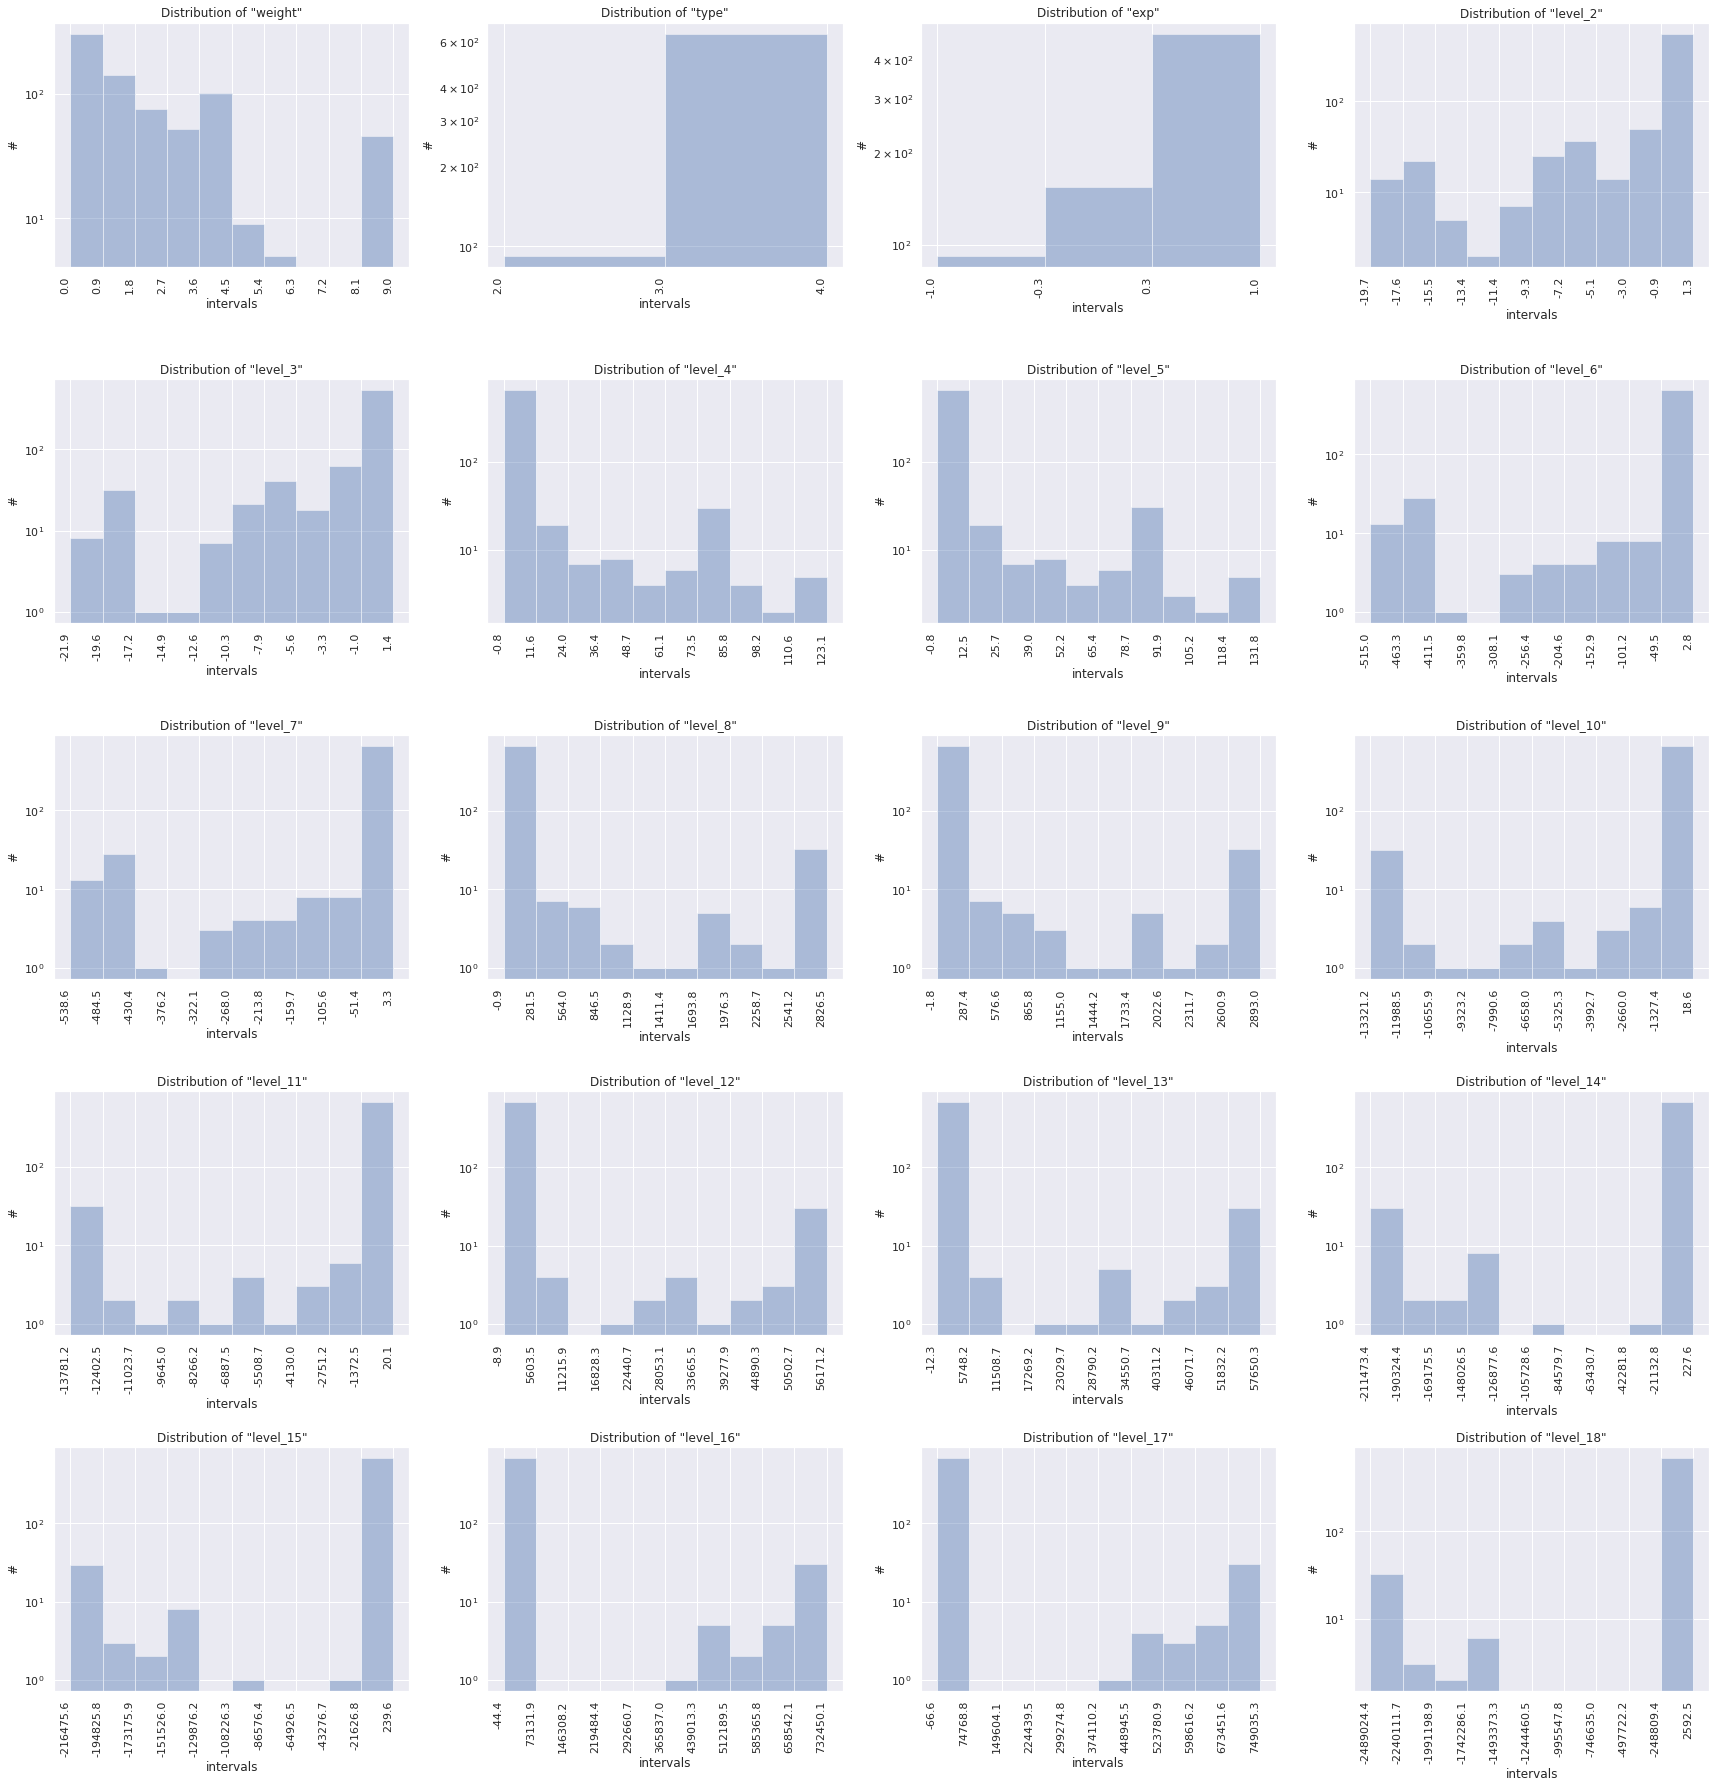

In [26]:
def discrete_bins(series: pd.Series,
                  n_bins: int,
                  ax: None
                 ) -> None:
    '''
    Digitise the series into a given number of discrete bins.
    
    Required arguments:
        series: the Pandas series to manipulate,
        n_bins: the number of bins,
        ax:     the subplot axis.
        
    Returns:
        the subplot axis
    '''
    # first check the number of unique values
    n_unique = pd.unique(series).shape[0]
    if n_bins > n_unique:
        n_bins = n_unique
        
    # compute the discretisation
    cuts, bins = pd.cut(series,
                        right=False,
                        bins=n_bins,
                        labels=range(n_bins),
                        retbins=True,
                        precision=1
                       )
    
    # plot the discretization
    sns.distplot(cuts,
                 bins=range(n_bins + 1),
                 kde=False,
                 axlabel='intervals',
                 ax=ax
                )
    ax.set(ylabel='#',
           title='Distribution of \"{}\"'.format(series.name),
           xticks=range(n_bins + 1),
           yscale='log'
          )
    ax.set_xticklabels(np.round(bins, 1), rotation=90, ha='right')
    
    return ax

# plot all features
nrows, ncols = (5,4)
fig, ax = subplots(nrows, ncols)

df_plot = df.drop(columns=['solutions', 'init'])
df_cols = np.array(df_plot.columns).reshape(nrows, ncols)

for i in range(nrows):
    for j in range(ncols):
        discrete_bins(df_plot[df_cols[i,j]], n_bins=10, ax=ax[i,j])
        
plt.tight_layout()
plt.savefig(imgpath('dataset-distribution_full.pdf'), dpi=150, format='pdf')

As we can see, the distributions are not ideally of the same order, but they have a decent amount of outlying samples outside the expected interval. In fact this seems to be a problem when `weight` is larger than $1.5$. We can in fact try to apply the same procedure in the case of low `weight` and high `weight`.

Consider for example the case with `weight` $< 1.5$ and plot the distribution of the variables:

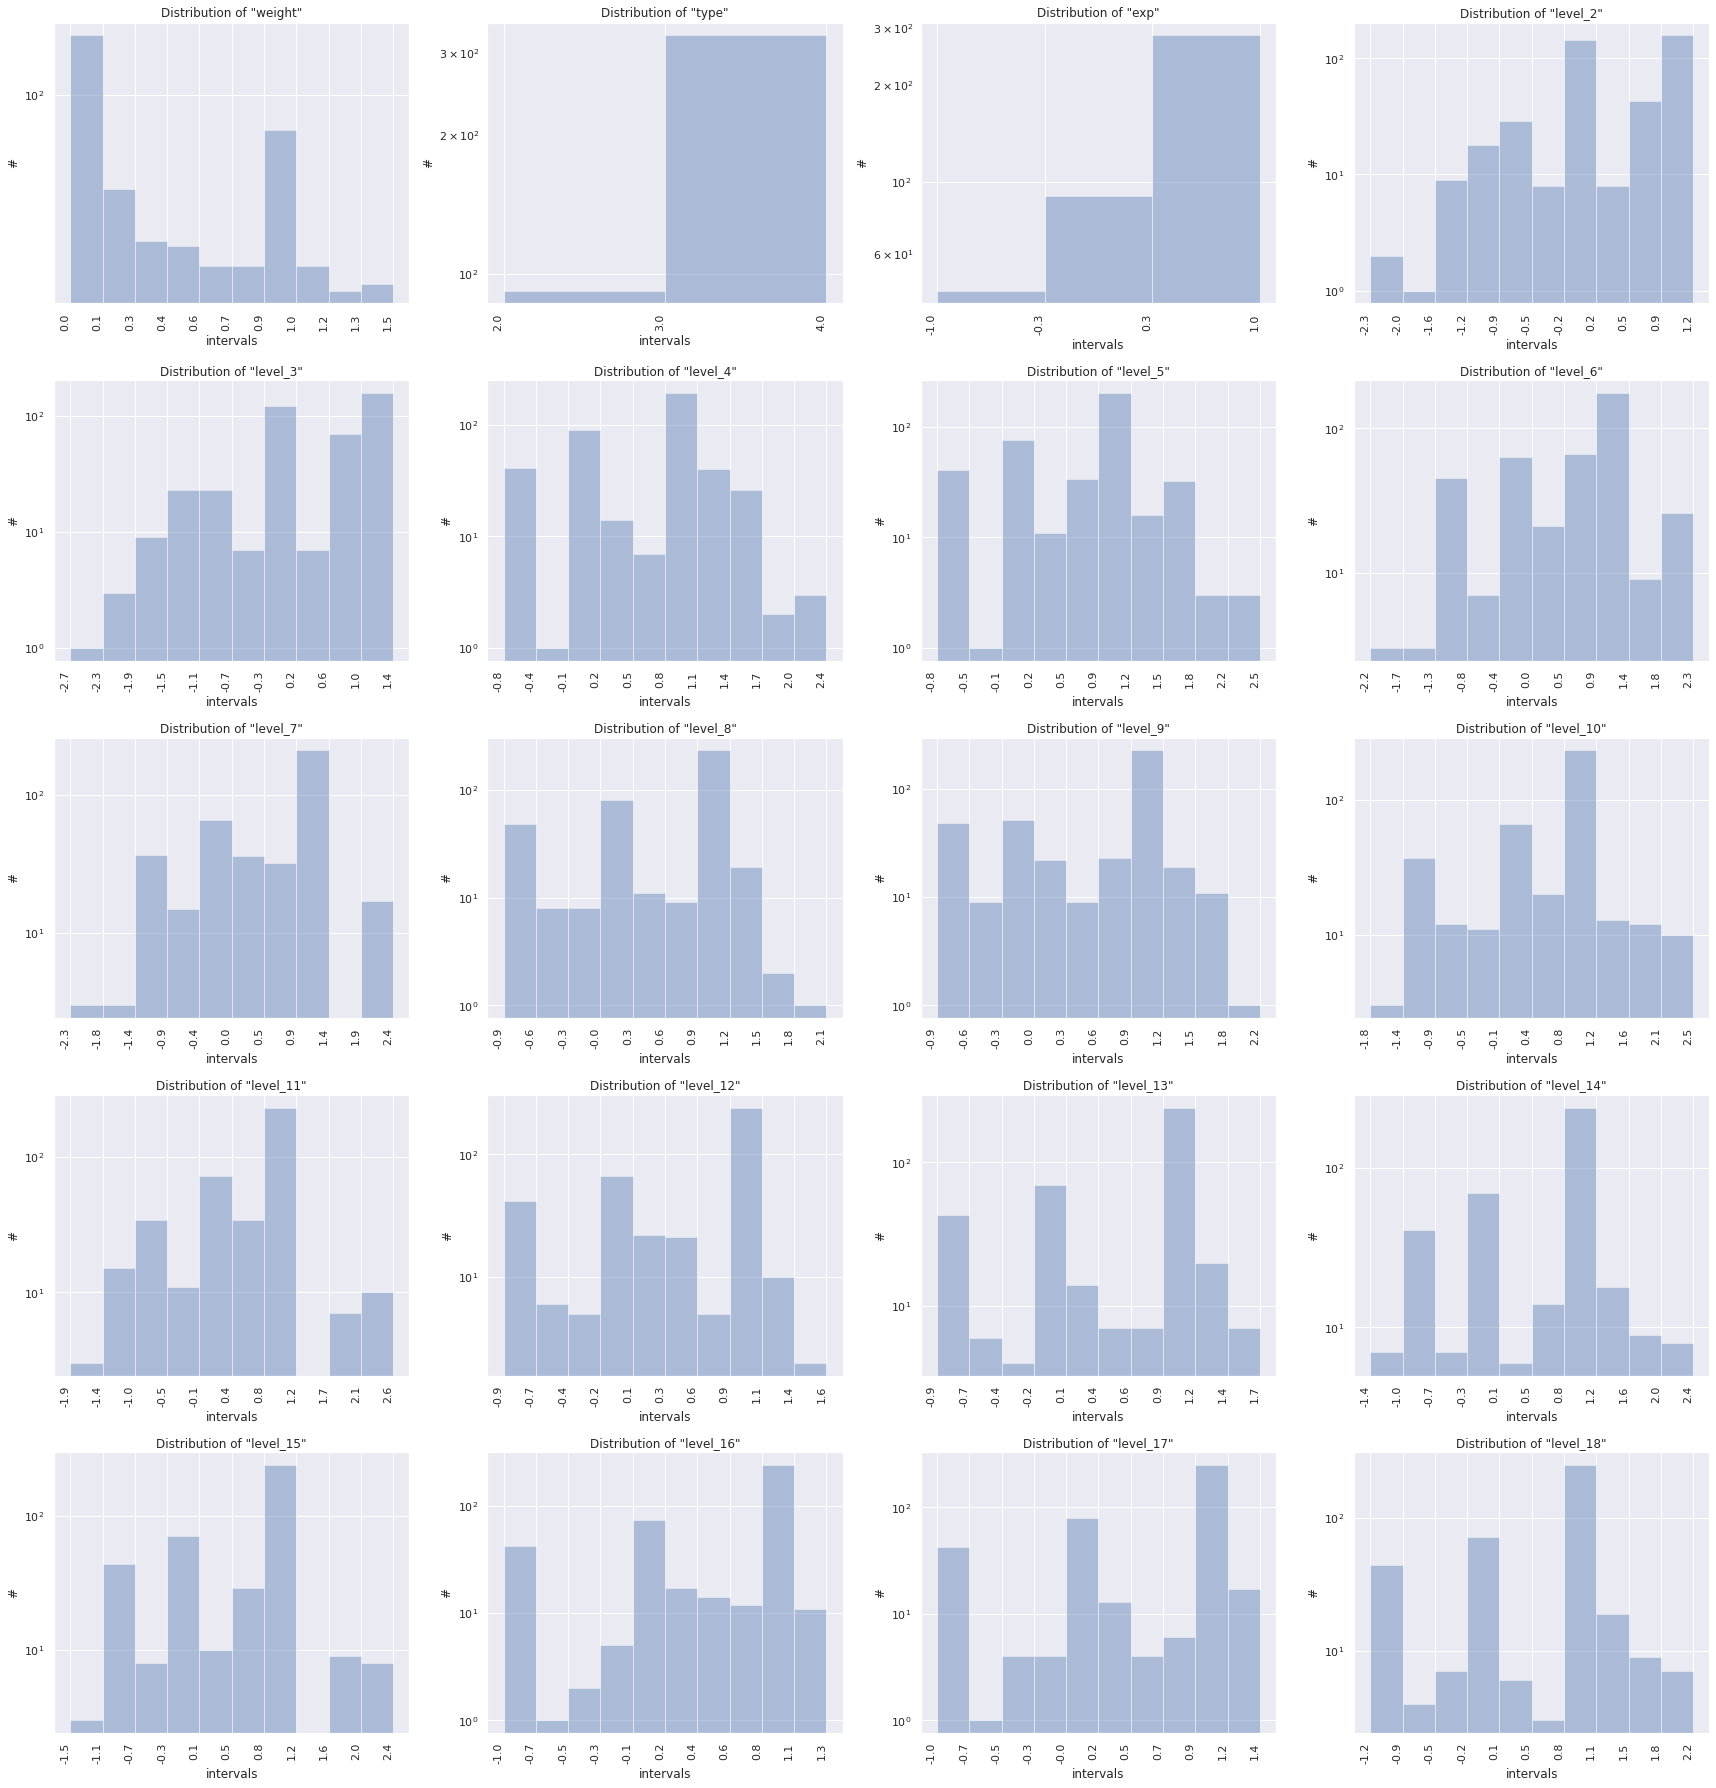

In [27]:
# plot all features
nrows, ncols = (5,4)
fig, ax = subplots(nrows, ncols)

df_low  = df.loc[df['weight'] < 1.5].drop(columns=['solutions', 'init'])
df_cols = np.array(df_low.columns).reshape(nrows, ncols)

for i in range(nrows):
    for j in range(ncols):
        discrete_bins(df_low[df_cols[i,j]], n_bins=10, ax=ax[i,j])
        
plt.tight_layout()
plt.savefig(imgpath('dataset-distribution_low.pdf'), dpi=150, format='pdf')

As we can see in this case the variables are in general $\mathrm{O}(1)$ and their variability is well distributed as we can also appreciate by computing the **sample variance**:

In [28]:
df_low.apply([np.mean, np.var])

,weight,type,exp,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18
mean,0.449124,3.560859,0.565632,0.342041,0.387235,0.644366,0.692398,0.580711,0.521181,0.555206,0.608225,0.604896,0.562090,0.551380,0.587494,0.603835,0.574199,0.555074,0.580554,0.600160
var,0.220571,0.687077,0.466376,0.531674,0.677236,0.432960,0.457166,0.676901,0.649696,0.457595,0.486475,0.622289,0.596503,0.431977,0.457045,0.565548,0.546521,0.419898,0.439103,0.529019


In this case we can also try to visualise the boxplot of the variables since their distribution is more restricted:

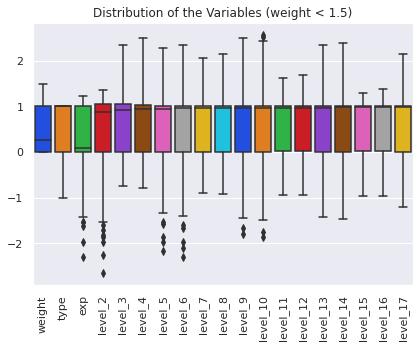

In [29]:
fig, ax = subplots(1,1)

# drop the column type since it's categorical
plot_data = df_low.drop(columns='type')
sns.boxplot(data=plot_data,
            order=plot_data.columns,
            palette=sns.color_palette('bright', plot_data.shape[1]),
            ax=ax
           )
ax.set(title='Distribution of the Variables (weight < 1.5)')
ax.set_xticklabels(df_low.columns, rotation=90)
        
plt.tight_layout()
plt.savefig(imgpath('dataset-distribution_box_low.pdf'),
            dpi=150,
            format='pdf'
           )

As we can see, all numerical variables (`type` is categorical and has been excluded from the plot) are all $\mathrm{O}(1)$, the interquartile ranges (the continuous vertical lines) are comparable, the medians (the short continuous horizontal lines) roughly lie in the same range and the number of outliers (separate points) is restricted.

Finally deal with the same considerations for `weight` $> 1.5$:

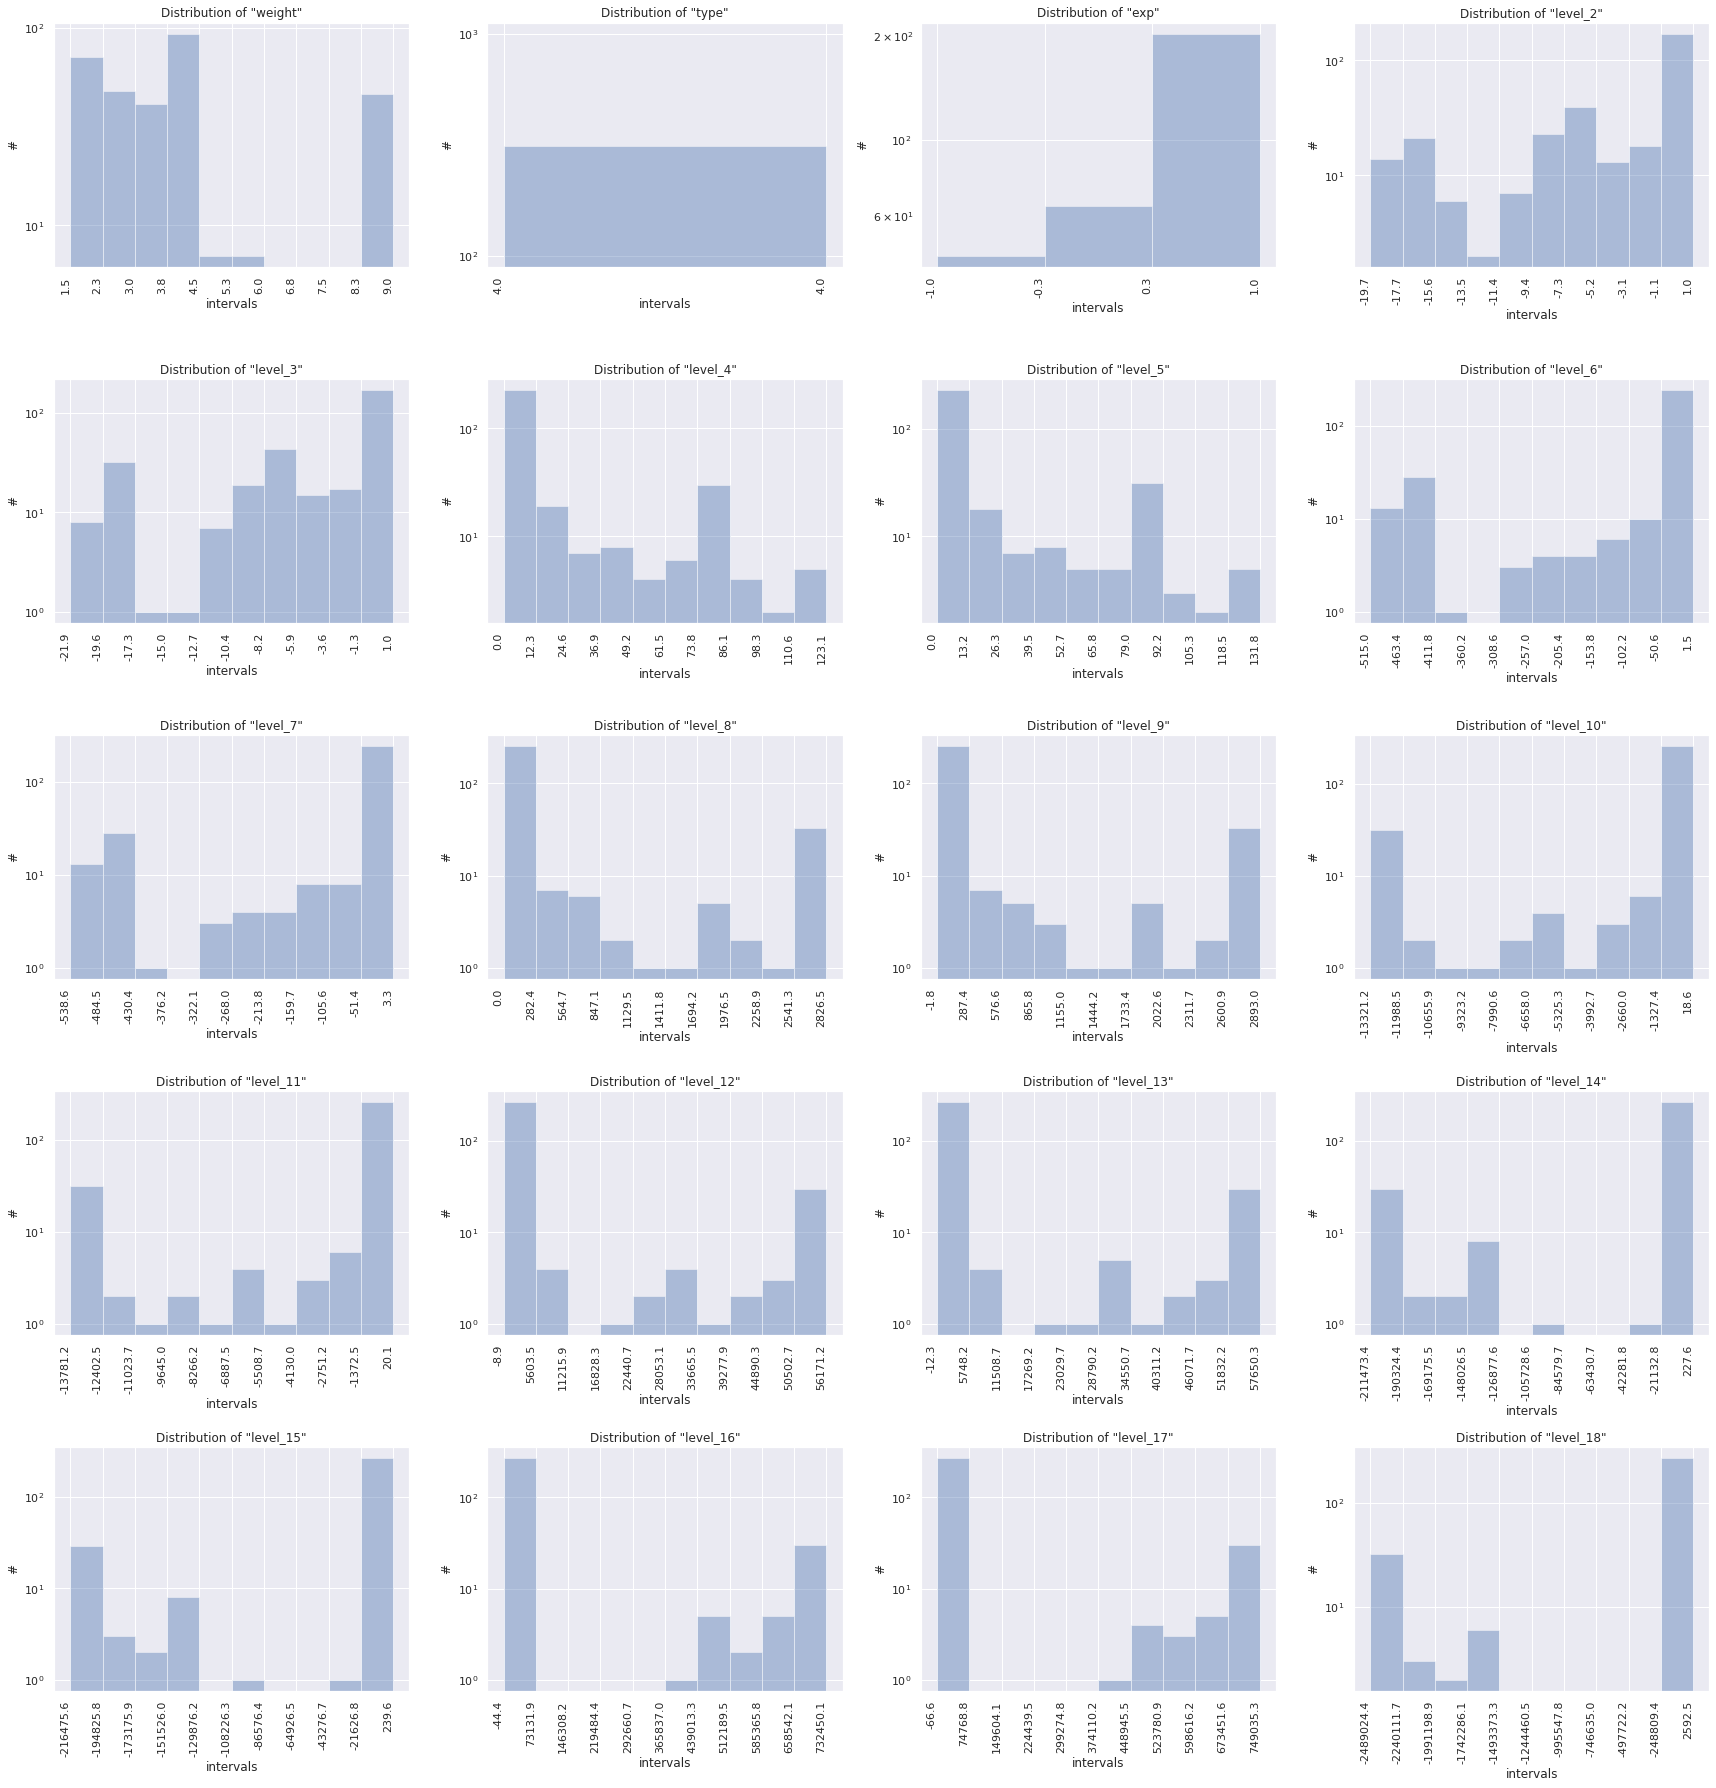

In [30]:
# plot all features
nrows, ncols = (5,4)
fig, ax = subplots(nrows, ncols)

df_high = df.loc[df['weight'] >= 1.5].drop(columns=['solutions', 'init'])
df_cols = np.array(df_high.columns).reshape(nrows, ncols)

for i in range(nrows):
    for j in range(ncols):
        discrete_bins(df_high[df_cols[i,j]], n_bins=10, ax=ax[i,j])
        
plt.tight_layout()
plt.savefig(imgpath('dataset-distribution_high.pdf'), dpi=150, format='pdf')

As we can see the distributions are far wider and less contained: variables are no longer $\mathrm{O}(1)$. In fact the same computation of mean and variance leads to a totally different result:

In [31]:
df_high.apply(['mean', 'var'])

,weight,type,exp,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18
mean,4.037276,4.0,0.501597,-4.213163,-4.658080,17.474616,18.476260,-79.983372,-83.638317,395.985348,410.928499,-1.726478e+03,-1.782014e+03,7.021491e+03,7.219883e+03,-2.652425e+04,-2.719587e+04,9.320024e+04,9.535027e+04,-3.062044e+05
var,5.126246,0.0,0.545671,35.154375,42.329733,907.208675,1016.694998,24661.041750,27094.985505,776110.779174,835512.646603,1.700621e+07,1.809668e+07,2.982230e+08,3.148385e+08,4.336862e+09,4.553048e+09,5.398017e+10,5.643713e+10,5.872270e+11


One thing we immediately notice is that when `weight` $> 1.5$ then the `type` of the observable is strictly $4.0$ (we may have to exclude it when dealing with the regression analysis). In fact, we can try to study the properties of the observables (`weight` and `type`) in the two cases side-by-side after binarising the conformal weight:

In [32]:
# create a categorical column with high and low weights
df_bin = df[['weight', 'type']].copy()
df_bin['weight_bin'] = \
    pd.Categorical((df_bin['weight'] < 1.5).astype(int)).\
    rename_categories(['> 1.5', '< 1.5'])

df_bin.groupby(['weight_bin', 'type']).agg({'weight': ['mean', 'var']})

weight          
                     mean       var
weight_bin type                    
> 1.5      2          NaN       NaN
           4     4.037276  5.126246
< 1.5      2     0.000000  0.000000
           4     0.575483  0.209877

We therefore learn that for higher weights the `type` of the observable is strictly $4$, while for lower weights `type` $= 2$ implies `weight` $= 0$.

As a last step in the exploratory data analysis we show the correlation matrix of the variables (only those used in the regression analysis):

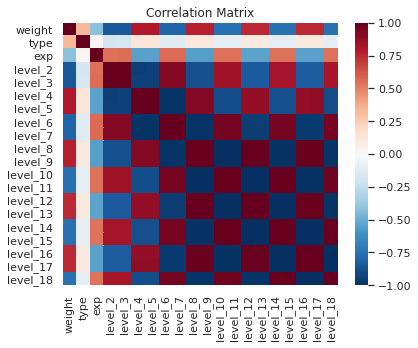

In [33]:
# compute the correlation matrix of the variables
df_corr = df.drop(columns=['solutions', 'init'])
df_corr = df_corr.corr()

fig, ax = subplots(1,1)
sns.heatmap(df_corr,
            vmin=-1.0,
            vmax=1.0,
            norm=mpl.colors.DivergingNorm(0.0),
            cmap='RdBu_r',
            ax=ax
           )
ax.set(title='Correlation Matrix')
        
plt.tight_layout()
plt.savefig(imgpath('corr-mat.pdf'), dpi=150, format='pdf')

Using the divergent palette we can see that the `type` of the observable is mostly unrelated to the other variables, while the truncation levels are strongly correlated among themselves (especially higher levels).

## Clustering Analysis and PCA

Before moving to the regression analysis and still in the **EDA** section of the pre-analysis, we consider the clustering labelling of the truncation levels: we would like to investigate the possibility of finding an underlying structure in the truncation levels pointing towards the extrapolated labels, `exp`. In the ideal scenario the labels of the clusters should be in 1:1 correspondence with the predictions labels.

In [34]:
# choose the no. of clusters = no. of labels
n_cls = pd.unique(df['exp']).shape[0]

For this analysis we focus separately on clustering `weight` $< 1.5$ and `weight` $\ge 1.5$ since the variability in the data may force some labels to take the same value:

In [35]:
df_low  = df.loc[df['weight'] < 1.5].drop(columns=['solutions',
                                                   'init',
                                                   'type',
                                                   'weight']
                                         )
df_high = df.loc[df['weight'] >= 1.5].drop(columns=['solutions',
                                                    'init',
                                                    'type',
                                                    'weight']
                                          )

# shuffle the datasets
df_low  = df_low.sample(frac=1, random_state=RAND)
df_high = df_high.sample(frac=1, random_state=RAND)

Since this is mostly a qualitative analysis, we do not worry to split the dataset into training and test sets and keep a single training split. We first preprocess the features with a `StandardScaler` in the case of low `weight` and a `RobustScaler` for high `weight`:

In [36]:
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster       import KMeans

# preprocess the data
data_low  = StandardScaler().fit_transform(df_low.iloc[:,1:])
data_high = RobustScaler().fit_transform(df_high.iloc[:,1:])

# apply clustering
log.info('Start of the clustering analysis.')
lab_low  = KMeans(n_clusters=3, random_state=RAND).fit_predict(data_low)
lab_high = KMeans(n_clusters=3, random_state=RAND).fit_predict(data_high)
log.info('End of the clustering analysis')

# save the labels
df_low['kmeans']  = lab_low
df_high['kmeans'] = lab_high

In order to visualise a 2D scatter plot of the labels as compared to the extrapolation results, we first perform a dimensionality reduction on the truncation levels (using the `PCA` and retaining only the first two components). This is also a good chance to provide some insights on the principal components of the truncation levels and whether they can be of use in the analysis. We first compute the principal components of the **scaled** dataset (divided into high `weight` and low `weight` parts):

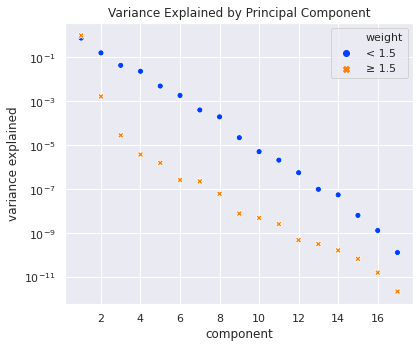

In [37]:
# apply SVD to the truncation levels
_, s_low, _  = np.linalg.svd(data_low)
_, s_high, _ = np.linalg.svd(data_high)

# square and normalise
s2_low  = s_low**2 / sum(s_low**2)
s2_high = s_high**2 / sum(s_high**2)

# create a dataframe holding components and distinguish weight <> 1.5
svd_dat = pd.DataFrame(\
            {'comp': np.hstack((np.arange(1, data_low.shape[1]+1),
                                np.arange(1, data_low.shape[1]+1)
                               )
                              ),
             'var': np.hstack((s2_low, s2_high)),
             'weight': ['< 1.5'] * s2_low.shape[0] +
                       ['≥ 1.5'] * s2_high.shape[0]
            }
                      )

# plot the retained variance of each component
fig, ax = subplots(1,1)
sns.scatterplot(data=svd_dat,
                x='comp',
                y='var',
                hue='weight',
                style='weight',
                palette=sns.color_palette('bright', 2),
                ax=ax
               )
ax.set(title='Variance Explained by Principal Component',
       xlabel='component',
       ylabel='variance explained',
       yscale='log'
      )
        
plt.tight_layout()
plt.savefig(imgpath('pca-variance-explained.pdf'), dpi=150, format='pdf')

From this we see that the `PCA` can be performed on the first few components for the two datasets since most of the variance is already explained by the first component when `weight` $\ge 1.5$ or by the first two components when `weight` $< 1.5$ (we drop the components which explain less than 10% of the variability):

In [38]:
svd_comp = {'comp': np.arange(1, data_low.shape[1]+1),
            'low_weight': np.round(svd_dat.loc[svd_dat['weight'] == '< 1.5']['var'].\
                            values, 3),
            'high_weight': np.round(svd_dat.loc[svd_dat['weight'] == '≥ 1.5']['var'].\
                            values, 3)
           }
svd_comp = pd.DataFrame(svd_comp)
svd_comp

,comp,low_weight,high_weight
0,1,0.763,0.998
1,2,0.162,0.002
2,3,0.044,0.000
3,4,0.024,0.000
4,5,0.005,0.000
5,6,0.002,0.000
6,7,0.000,0.000
7,8,0.000,0.000
8,9,0.000,0.000
9,10,0.000,0.000


This might sound redundant since we only wanted to plot the two principal components, but this may come in handy when performing the regression analysis. In the meantime we can reduce the number of components using the `PCA` and plot the cluster labels:

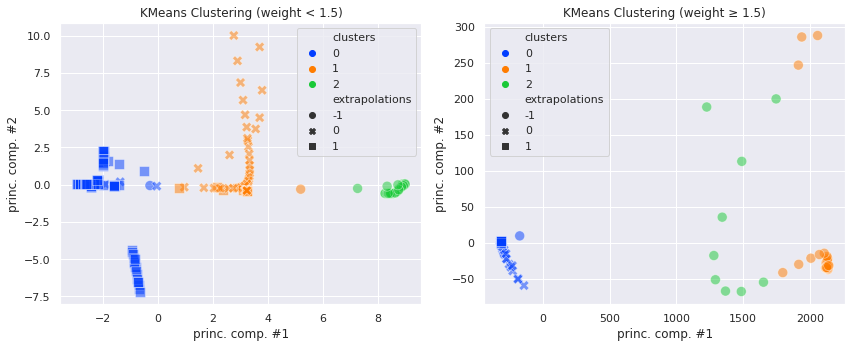

In [39]:
from sklearn.decomposition import PCA

# perform PCA
log.info('Start of PCA computation.')
princ_low  = PCA(n_components=2, random_state=RAND).fit_transform(data_low)
princ_high = PCA(n_components=2, random_state=RAND).fit_transform(data_high)
log.info('End of PCA computation.')

# create dataframe
dat_low = {'comp_1': princ_low[:,0],
           'comp_2': princ_low[:,1],
           'clusters': df_low['kmeans'].values,
           'extrapolations': df_low['exp'].values
          }
dat_high = {'comp_1': princ_high[:,0],
            'comp_2': princ_high[:,1],
            'clusters': df_high['kmeans'].values,
            'extrapolations': df_high['exp'].values
           }

dat_low  = pd.DataFrame(dat_low)
dat_high = pd.DataFrame(dat_high)

# plot the principal components, clusters and extrapolations
fig, ax = subplots(1,2)

sns.scatterplot(data=dat_low,
                x='comp_1',
                y='comp_2',
                hue='clusters',
                style='extrapolations',
                s=100,
                alpha=0.5,
                palette=sns.color_palette('bright', n_cls),
                ax=ax[0]
               )
ax[0].set(title='KMeans Clustering (weight < 1.5)',
          xlabel='princ. comp. #1',
          ylabel='princ. comp. #2'
         )

sns.scatterplot(data=dat_high,
                x='comp_1',
                y='comp_2',
                hue='clusters',
                style='extrapolations',
                s=100,
                alpha=0.5,
                palette=sns.color_palette('bright', n_cls),
                ax=ax[1]
               )
ax[1].set(title='KMeans Clustering (weight ≥ 1.5)',
          xlabel='princ. comp. #1',
          ylabel='princ. comp. #2'
         )
        
plt.tight_layout()
plt.savefig(imgpath('kmeans-clusters.pdf'), dpi=150, format='pdf')

From the data it seems that when `weight` $< 1.5$, the data present a good clustered structure which can well represent the distribution of the data. For example we can compute the mean of the labels of the clusters for each prediction label to see where their distribution is peaked:

In [40]:
dat_low.groupby(['extrapolations']).agg({'clusters': 'mean'})

,clusters
extrapolations,
-1,1.847826
0,0.922222
1,0.021201


In this case it seems that by simply rounding to the next integer the mean of the cluster labels we can assign a cluster centroid to each extrapolated label.

We cannot however say the same in the case of high weight:

In [41]:
dat_high.groupby(['extrapolations']).agg({'clusters': 'mean'})

,clusters
extrapolations,
-1,1.130435
0,0.000000
1,0.000000


In fact, in this case the data is so scattered that no clusters are visibly recognisable. We also notice from the plots that when `weight` $\ge 1.5$ the variance of the data is almost completely captured by the first principal component since the range of variability is more than six times larger than the range of the second principal component.

# Regression Analysis

We can now move to the regression analysis. We shall consider several different approaches to the regression task, starting from a linear regression for simplicity and analysis of the coefficients, moving to Support Vector Machines (SVM) and decision tree algorithms (random forest, RF, and gradient boosted decision trees, GBDT, to be specific

As a first attempt, we will **keep the full dataset** without distinction on `weight` to assess the ability of the ML algorithm to adapt to the situation. We will however remove the first values of the `solutions` since they are artificially "too perfect" for the analysis and may spoil the results:

In [42]:
df_analysis = df[df['solutions'] != 0]
df_analysis = df_analysis.reset_index(drop=True)

The variability of the dataset is however mostly unaffected by the transformation as the summary of the truncation levels can confirm:

In [43]:
df_analysis.filter(regex='^level.*$').describe()

,level_2,level_3,level_4,level_5,level_6,level_7,level_8,level_9,level_10,level_11,level_12,level_13,level_14,level_15,level_16,level_17,level_18
count,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,718.000000,7.180000e+02
mean,-1.649589,-1.817170,7.981259,8.445939,-34.541055,-36.169106,172.934603,179.479758,-752.288433,-776.523313,3061.210057,3147.716636,-11562.460857,-11855.258680,40629.386999,41566.669584,-1.334843e+05
std,4.548304,5.005473,21.558408,22.815235,111.039170,116.338079,613.372450,636.418293,2852.135166,2942.302665,11912.541567,12240.685674,45391.801105,46512.063723,160087.941813,163698.216993,5.278422e+05
min,-19.744040,-21.893983,-0.754568,-0.782633,-514.984097,-538.627792,-0.909456,-1.781985,-13321.170445,-13781.246472,-8.850113,-12.265769,-211473.396816,-216475.644423,-44.356923,-66.596211,-2.489024e+06
25%,-0.819357,-1.048764,0.000000,0.000000,-0.924887,-0.941950,0.000000,0.000000,-1.122517,-2.123912,0.001518,0.001679,-3.214377,-6.185564,0.045728,0.042314,-2.569285e+01
50%,0.000000,0.000000,0.923914,0.935052,0.000000,0.000000,0.974117,0.975401,0.001407,0.001712,0.987326,0.987066,0.001634,0.004821,1.004445,1.001084,9.732395e-02
75%,0.795133,0.913984,1.408763,1.552803,0.960644,0.984305,2.341926,2.626999,0.991467,0.996329,4.397037,6.811820,0.997875,1.001248,16.098058,16.131990,1.003658e+00
max,1.239384,1.358098,122.931347,131.675490,2.275741,2.712998,2823.630938,2890.129013,5.243298,6.283092,56115.100219,57592.698860,16.106978,23.077325,731718.332090,748286.961169,1.033588e+02


## Test and Validation Sets

The first necessary step for the analysis is the selection of test and validations sets. The selection is performed on the basis of the `solutions` column in order to keep equal values of `solutions` in the same set as to prevent the mixing of different distributions: we first split the unique values of `solutions` into train/validation/test sets and then assign the corresponding samples to the splits.

We will keep around 10% of the samples in the test set to start with and we will then perform a quick regression analysis to choose the size of the validation set in order to keep the Mean Squared Error (MSE) as contained as possible.

In [44]:
from sklearn.model_selection import train_test_split

# define the unique values of solutions
solutions = pd.unique(df_analysis['solutions'])

# split the test set
log.debug('Splitting test set.')
train_sol, test_sol = train_test_split(solutions,
                                       test_size=0.10,
                                       shuffle=True,
                                       random_state=RAND
                                      )

# assign the corresponding samples
df_train = df_analysis[df_analysis['solutions'].isin(train_sol)]
df_test  = df_analysis[df_analysis['solutions'].isin(test_sol)]

print('Train set: {:d} samples({:.2f}% of the total set).'.\
      format(df_train.shape[0], 100*df_train.shape[0]/df_analysis.shape[0])
     )
print('Test set:  {:d} samples({:.2f}% of the total set).'.\
      format(df_test.shape[0], 100*df_test.shape[0]/df_analysis.shape[0])
     )

Train set: 640 samples(89.14% of the total set).
Test set:  78 samples(10.86% of the total set).


We then select a range of sizes of the validation set for which we test a simple linear regression model. We then plot the MSE as a function of the size of the validation set (taken with respect to the training set) and choose a suitable split for the analysis. Since this is still an exploratory computation, we will not pre-process the data.

In [45]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error

# choose a range of validation set sizes
dev_sizes = np.linspace(0.10, 0.75, num=14)

# prepare lists of errors (training and validation)
errors = {'val_size': [], 'error': [], 'type': []}

# select training and validation solutions
for n in range(dev_sizes.shape[0]):
    train_tmp_sol, val_tmp_sol = train_test_split(train_sol,
                                                  test_size=dev_sizes[n],
                                                  shuffle=False
                                                 )

    # remember to shuffle the dataset
    df_train_tmp = df_train[df_train['solutions'].isin(train_tmp_sol)].\
                    sample(frac=1, random_state=RAND)
    df_val_tmp  = df_train[df_train['solutions'].isin(val_tmp_sol)].\
                    sample(frac=1, random_state=RAND)

    df_train_tmp_feat = df_train_tmp.drop(columns=['solutions', 'init', 'exp'])
    y_tmp_train_true  = df_train_tmp['exp'].values.reshape(-1,)
    
    df_val_tmp_feat   = df_val_tmp.drop(columns=['solutions', 'init', 'exp'])
    y_tmp_val_true    = df_val_tmp['exp'].values.reshape(-1,)

    # fit a linear regression model (don't fit the intercept: no meaning!)
    model = LinearRegression(fit_intercept=False,
                             n_jobs=THREADS).fit(df_train_tmp_feat,
                                                 y_tmp_train_true
                                                )

    # make predictions on train and test sets
    y_tmp_train_pred = model.predict(df_train_tmp_feat).reshape(-1,)
    y_tmp_val_pred   = model.predict(df_val_tmp_feat).reshape(-1,)

    # compute the MSE
    errors['error'].append(mean_squared_error(y_tmp_train_true,
                                              y_tmp_train_pred
                                             )
                          )
    errors['type'].append('training')
    errors['val_size'].append(dev_sizes[n])
    
    errors['error'].append(mean_squared_error(y_tmp_val_true,
                                             y_tmp_val_pred
                                            )
                         )
    errors['type'].append('validation')
    errors['val_size'].append(dev_sizes[n])
    
# save the errors as dataframe
errors = pd.DataFrame(errors)

We then plot the results of training and validation errors:

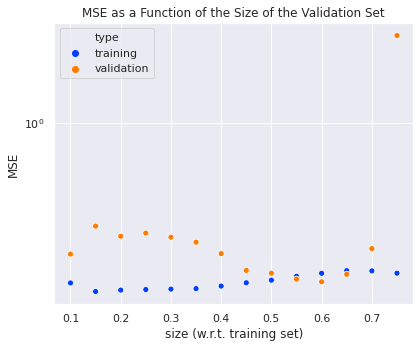

In [46]:
fig, ax = subplots(1,1)

sns.scatterplot(data=errors,
                x='val_size',
                y='error',
                hue='type',
                palette=sns.color_palette('bright', 2),
                ax=ax
               )
ax.set(title='MSE as a Function of the Size of the Validation Set',
       xlabel='size (w.r.t. training set)',
       ylabel='MSE',
       yscale='log'
      )
        
plt.tight_layout()
plt.savefig(imgpath('training-validation-errors.pdf'), dpi=150, format='pdf')

Given the previous result, we choose to keep around 10% of the training data in the validation set. We select the samples as we did for the test set.

In [47]:
# split the training set
train_sol, val_sol = train_test_split(train_sol,
                                      test_size=0.10,
                                      shuffle=False
                                     )

# assign the corresponding samples (remember to shuffle everything!)
train = df_train[df_train['solutions'].isin(train_sol)].\
            sample(frac=1, random_state=RAND)
valid = df_train[df_train['solutions'].isin(val_sol)].\
            sample(frac=1, random_state=RAND)
test  = df_test.sample(frac=1, random_state=RAND)

print('Train set:      {:d} samples({:.2f}% of the total set).'.\
      format(train.shape[0], 100*train.shape[0]/df_analysis.shape[0])
     )
print('Validation set: {:d} samples({:.2f}% of the total set).'.\
      format(valid.shape[0], 100*valid.shape[0]/df_analysis.shape[0])
     )
print('Test set:       {:d} samples({:.2f}% of the total set).'.\
      format(test.shape[0], 100*test.shape[0]/df_analysis.shape[0])
     )

Train set:      579 samples(80.64% of the total set).
Validation set: 61 samples(8.50% of the total set).
Test set:       78 samples(10.86% of the total set).


We then save the dataset we use in the analysis:

In [48]:
train.sort_values(ordering_columns, ignore_index=True).\
    to_csv(datpath('sft-train-set.csv'), index=False)
valid.sort_values(ordering_columns, ignore_index=True).\
    to_csv(datpath('sft-val-set.csv'), index=False)
test.sort_values(ordering_columns, ignore_index=True).\
    to_csv(datpath('sft-test-set.csv'), index=False)

## Pre-processing

Before computing the algorithms we pre-process the data using previous results to improve the possible outcome. We use a `RobustScaler` to scale the input accounting for the outliers. We scale only the truncation levels since `weight` is already $\mathrm{O}(1)$ and `type` is a "categorical" (ordered, since clearly $4 > 2$) variable:

In [49]:
from sklearn.preprocessing import RobustScaler

# select only the features for training
X_train = train.drop(columns=['solutions', 'init', 'exp']).\
            reset_index(drop=True)
X_val   = valid.drop(columns=['solutions', 'init', 'exp']).\
            reset_index(drop=True)
X_test  = test.drop(columns=['solutions', 'init', 'exp']).\
            reset_index(drop=True)

# take the labels
y_train = train['exp'].values.reshape(-1,)
y_val   = valid['exp'].values.reshape(-1,)
y_test  = test['exp'].values.reshape(-1,)

# scale the samples
rob_scl = RobustScaler()
X_train_transf = pd.DataFrame(rob_scl.\
                    fit_transform(X_train.filter(regex='^level.*$')),
                    columns=X_train.filter(regex='^level.*$').columns
                             )
X_val_transf   = pd.DataFrame(rob_scl.\
                    transform(X_val.filter(regex='^level.*$')),
                    columns=X_val.filter(regex='^level.*$').columns
                             )
X_test_transf  = pd.DataFrame(rob_scl.\
                    transform(X_test.filter(regex='^level.*$')),
                    columns=X_test.filter(regex='^level.*$').columns
                             )

# concatenate the results
X_train = pd.concat([X_train[['weight', 'type']], X_train_transf], axis=1)
X_val   = pd.concat([X_val[['weight', 'type']], X_val_transf], axis=1)
X_test  = pd.concat([X_test[['weight', 'type']], X_test_transf], axis=1)

In the analysis we will print several metrics to evaluate the fit. In particular we will use the MSE, the Mean Absolute Error (MAE) and the $R^2$ score (R2). For the errors (_residuals_) we will also include the computation of the confidence intervals:

In [50]:
from scipy  import stats
from typing import Tuple

def mse_ci(y_true: float,
           y_pred: float,
           dof: float,
           confidence: float = 0.95) -> Tuple[float, float]:
    '''
    Compute the confidence interval of the variance.
    
    Required arguments:
        y_true: true values,
        y_pred: predictions,
        dof:    the no. of degrees of freedom.
        
    Returns:
        the array of lower and upper bounds of the confidence interval.
    '''
    
    # compute the deviation of the data and the squared errors
    deviation = y_pred - y_true
    sq_errors = deviation ** 2

    # compute the confidence intervals
    conf_interval = stats.t.interval(confidence,
                                     dof,
                                     loc   = sq_errors.mean(),
                                     scale = stats.sem(sq_errors)
                                    )
    
    return conf_interval

### Linear Regression (Preliminary Study)

The first approach to the regression models is the **linear regression**: it can be used to set a baseline for further improvement and can be a practice ground to study the correlations between the coefficients and their impact on the results. In this case the features have been scaled and centred (`RobustScaler` centres the data before transforming): we do not need to account for fitting the intercept since it would have no meaning in the model.

In [51]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, \
                                 mean_absolute_error, \
                                 r2_score

log.info('Fitting linear regression.')

# define the model
lin_reg = LinearRegression(fit_intercept=False,
                           normalize=False,
                           n_jobs=THREADS
                          )

# fit the model
lin_reg.fit(X_train, y_train)

# generate predictions
y_train_pred = lin_reg.predict(X_train)
y_val_pred   = lin_reg.predict(X_val)
y_test_pred  = lin_reg.predict(X_test)

# define the no. of dof
dof = X_train.shape[0] - X_train.shape[1] # i.e. samples - linear coeff.

# compute metrics
lin_reg_train = {'MSE':    mean_squared_error(y_train, y_train_pred),
                 'MSE_CI': mse_ci(y_train, y_train_pred, dof),
                 'MAE':    mean_absolute_error(y_train, y_train_pred),
                 'R2':     r2_score(y_train, y_train_pred)
                }
lin_reg_val = {'MSE':    mean_squared_error(y_val, y_val_pred),
               'MSE_CI': mse_ci(y_val, y_val_pred, dof),
               'MAE':    mean_absolute_error(y_val, y_val_pred),
               'R2':     r2_score(y_val, y_val_pred)
              }
lin_reg_test = {'MSE':    mean_squared_error(y_test, y_test_pred),
                'MSE_CI': mse_ci(y_test, y_test_pred, dof),
                'MAE':    mean_absolute_error(y_test, y_test_pred),
                'R2':     r2_score(y_test, y_test_pred)
               }

# print the metrics
print('LINEAR REGRESSION:\n\n',
      '  Training set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_train['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_train['MSE_CI'][0],
                                              lin_reg_train['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_train['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_train['R2']),
      '  Validation set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_val['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_val['MSE_CI'][0],
                                              lin_reg_val['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_val['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_val['R2']),
      '  Test set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_test['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_test['MSE_CI'][0],
                                              lin_reg_test['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_test['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_test['R2'])
     )

LINEAR REGRESSION:

   Training set:

     MSE: 0.165     95% CI: [0.131, 0.199]
     MAE: 0.294
     R2:  0.668

   Validation set:

     MSE: 0.229     95% CI: [0.103, 0.355]
     MAE: 0.350
     R2:  0.552

   Test set:

     MSE: 0.132     95% CI: [0.066, 0.198]
     MAE: 0.274
     R2:  0.740




For the linear model we can try and be more specific as to what coefficient is contributing to the final prediction computing statistics for each coefficient of the linear model.

In [52]:
from scipy import stats

def lin_summary(estimator: sklearn.base.BaseEstimator,
                X: pd.Series,
                y: np.ndarray) -> pd.DataFrame:
    '''
    Build a summary of the linear regression.
    
    Required arguments:
        estimator: the linear fit model,
        X:         the predictor,
        y:         the estimand.
        
    Returns:
        the statistics on the coefficients.
    '''
    # compute the no. of dof and the coefficients
    dof  = X.shape[0] - X.shape[1]
    coef = estimator.coef_
    
    # compute residuals, residual variance and the square of deviations
    res = y - estimator.predict(X)
    var = np.sum(res**2) / dof
    ssx = np.sum(np.square(X.values - np.mean(X.values, axis=0)), axis=0)
    
    # compute standard error, t coeffcient and p-value that t_obs > |t|
    se  = np.sqrt(var / (ssx + 1.0e-6)) #---------- avoid division by zero
    t   = coef / (se + 1.0e-6) #------------------- avoid division by zero
    p   = 2 * (1.0 - stats.t.cdf(abs(t), dof))
    
    # compute confidence intervals (two sided)
    intervals = stats.t.interval(0.975,
                                 dof,
                                 loc=coef,
                                 scale=se
                                )
    
    # create the dataframe
    summary = {'coefficients':          coef,
               'standard error':        se,
               't statistic':           np.round(t, 3),
               'p value (t_obs > |t|)': np.round(p, 3),
               '95% CI (lower)':        intervals[0],
               '95% CI (upper)':        intervals[1]
              }
    return pd.DataFrame(summary, index=X.columns)

We can then give a summary of the values of the coefficients given the number of degrees of freedom of the fit (i.e. the difference between the no. of samples and the no. of coefficients, since we are not fitting the intercept). We start from the training set:

In [53]:
lin_reg_sum_train = lin_summary(lin_reg, X_train, y_train)
lin_reg_sum_train

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.101068,7.381903e-03,13.689,0.00,0.084477,0.117658
type,0.126370,2.598570e-02,4.863,0.00,0.067968,0.184771
level_2,0.012103,5.877432e-03,2.059,0.04,-0.001107,0.025312
level_3,0.149727,6.663796e-03,22.465,0.00,0.134751,0.164704
level_4,-0.305631,1.137161e-03,-268.531,0.00,-0.308187,-0.303075
level_5,0.481529,1.186631e-03,405.453,0.00,0.478862,0.484196
level_6,-0.486953,2.930976e-04,-1655.753,0.00,-0.487612,-0.486294
level_7,0.766628,2.857775e-04,2673.250,0.00,0.765986,0.767270
level_8,-0.486133,3.670445e-05,-12893.249,0.00,-0.486215,-0.486050
level_9,1.013625,5.124361e-05,19401.901,0.00,1.013510,1.013741


We can see that the huge variation of the samples in the set leads to a very precise (possibly **too precise**) determination of the coefficients of the fit. The same happens for the development set (i.e. the **validation set**) where only `type` cannot be assumed to be different from 0.

In [54]:
lin_reg_sum_val = lin_summary(lin_reg, X_val, y_val)
lin_reg_sum_val

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.101068,0.030654,3.297,0.002,0.029808,0.172327
type,0.126370,0.109386,1.155,0.255,-0.127912,0.380651
level_2,0.012103,0.024648,0.491,0.626,-0.045195,0.069400
level_3,0.149727,0.027898,5.367,0.000,0.084875,0.214579
level_4,-0.305631,0.004344,-70.334,0.000,-0.315730,-0.295532
level_5,0.481529,0.004524,106.417,0.000,0.471013,0.492045
level_6,-0.486953,0.001248,-390.009,0.000,-0.489853,-0.484053
level_7,0.766628,0.001212,631.884,0.000,0.763810,0.769446
level_8,-0.486133,0.000173,-2786.757,0.000,-0.486536,-0.485730
level_9,1.013625,0.000241,4191.369,0.000,1.013066,1.014185


We finally present the summary of the test set: we use it to plot the contribution of the coefficients, residuals and predictions and histogram of the residuals as opposed to the same statistics for the validation set:

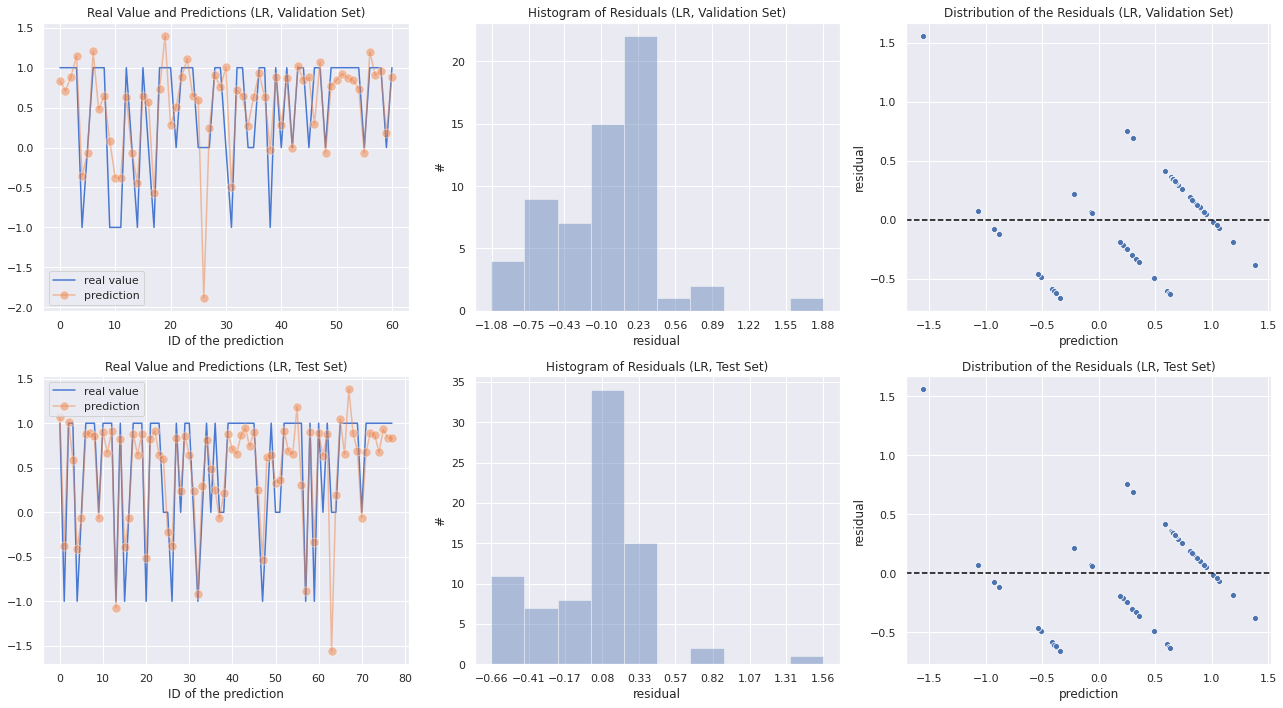

In [55]:
lin_reg_sum_test  = lin_summary(lin_reg, X_test, y_test)
lin_reg_val_pred  = pd.DataFrame({'real value': y_val.reshape(-1,),
                                  'prediction': y_val_pred.reshape(-1,),
                                  'residuals':  y_val.reshape(-1,) -
                                                y_val_pred.reshape(-1,),
                                  'id':         np.arange(y_val.shape[0])
                                 }
                                )
lin_reg_test_pred = pd.DataFrame({'real value': y_test.reshape(-1,),
                                  'prediction': y_test_pred.reshape(-1,),
                                  'residuals':  y_test.reshape(-1,) -
                                                y_test_pred.reshape(-1,),
                                  'id':         np.arange(y_test.shape[0])
                                 }
                                )

fig, ax = subplots(2,3)

# plot the predictions and the real values
sns.lineplot(data=lin_reg_val_pred,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=lin_reg_val_pred,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Real Value and Predictions (LR, Validation Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_val_pred['residuals'],
             bins=10,
             kde=False,
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (LR, Validation Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_val_pred['residuals']),
                               np.max(lin_reg_val_pred['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred,
                x='prediction',
                y='residuals',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (LR, Validation Set)',
            xlabel='prediction',
            ylabel='residual'
           )

# plot the predictions and the real values
sns.lineplot(data=lin_reg_test_pred,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=lin_reg_test_pred,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Real Value and Predictions (LR, Test Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_test_pred['residuals'],
             bins=10,
             kde=False,
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (LR, Test Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_test_pred['residuals']),
                               np.max(lin_reg_test_pred['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred,
                x='prediction',
                y='residuals',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (LR, Test Set)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lin_reg_preliminary.pdf'), dpi=150, format='pdf')

We now proceed to a different analysis of the linear regression algorithm. Specifically we investigate the possibility of dividing the `weight` variable in high and low weights and look at the summary of the fit.

### Linear Regression with Weight Discrimination (Preliminary)

In this section we consider the linear regression analysis dividing the `weight` variable in two parts according to its values.

In [56]:
X_train_low  = X_train[X_train['weight'] < 1.5]
X_train_high = X_train[X_train['weight'] >= 1.5]
X_val_low    = X_val[X_val['weight'] < 1.5]
X_val_high   = X_val[X_val['weight'] >= 1.5]
X_test_low   = X_test[X_test['weight'] < 1.5]
X_test_high  = X_test[X_test['weight'] >= 1.5]

y_train_low  = y_train[X_train_low.index]
y_train_high = y_train[X_train_high.index]
y_val_low    = y_val[X_val_low.index]
y_val_high   = y_val[X_val_high.index]
y_test_low   = y_test[X_test_low.index]
y_test_high  = y_test[X_test_high.index]

We then proceed as before to fit the algorithm:

In [57]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, \
                                 mean_absolute_error, \
                                 r2_score

log.info('Fitting linear regression with weight discrimination.')

# define the model
lin_reg_low  = LinearRegression(fit_intercept=False,
                                normalize=False,
                                n_jobs=THREADS
                               )
lin_reg_high = LinearRegression(fit_intercept=False,
                                normalize=False,
                                n_jobs=THREADS
                               )

# fit the model
lin_reg_low.fit(X_train_low, y_train_low)
lin_reg_high.fit(X_train_high, y_train_high)

# generate predictions
y_train_pred_low  = lin_reg_low.predict(X_train_low)
y_val_pred_low    = lin_reg_low.predict(X_val_low)
y_test_pred_low   = lin_reg_low.predict(X_test_low)

y_train_pred_high = lin_reg_high.predict(X_train_high)
y_val_pred_high   = lin_reg_high.predict(X_val_high)
y_test_pred_high  = lin_reg_high.predict(X_test_high)

# define the no. of dof
dof_low  = X_train_low.shape[0] - X_train_low.shape[1]
dof_high = X_train_high.shape[0] - X_train_high.shape[1]

# compute metrics
lin_reg_low_train = {'MSE':    mean_squared_error(y_train_low,
                                                  y_train_pred_low
                                                 ),
                     'MSE_CI': mse_ci(y_train_low,
                                      y_train_pred_low,
                                      dof_low
                                     ),
                     'MAE':    mean_absolute_error(y_train_low,
                                                   y_train_pred_low
                                                  ),
                     'R2':     r2_score(y_train_low,
                                        y_train_pred_low
                                       )
                    }
lin_reg_low_val = {'MSE':    mean_squared_error(y_val_low,
                                                y_val_pred_low
                                               ),
                   'MSE_CI': mse_ci(y_val_low,
                                    y_val_pred_low,
                                    dof_low
                                   ),
                   'MAE':    mean_absolute_error(y_val_low,
                                                 y_val_pred_low
                                                ),
                   'R2':     r2_score(y_val_low,
                                      y_val_pred_low
                                     )
                  }
lin_reg_low_test = {'MSE':    mean_squared_error(y_test_low,
                                                 y_test_pred_low
                                                ),
                    'MSE_CI': mse_ci(y_test_low,
                                     y_test_pred_low,
                                     dof_low
                                    ),
                    'MAE':    mean_absolute_error(y_test_low,
                                                  y_test_pred_low
                                                 ),
                    'R2':     r2_score(y_test_low,
                                       y_test_pred_low
                                      )
                   }

lin_reg_high_train = {'MSE':    mean_squared_error(y_train_high,
                                                   y_train_pred_high
                                                  ),
                      'MSE_CI': mse_ci(y_train_high,
                                       y_train_pred_high,
                                       dof_high
                                      ),
                      'MAE':    mean_absolute_error(y_train_high,
                                                    y_train_pred_high
                                                   ),
                      'R2':     r2_score(y_train_high,
                                         y_train_pred_high
                                        )
                     }
lin_reg_high_val = {'MSE':    mean_squared_error(y_val_high,
                                                 y_val_pred_high
                                                ),
                    'MSE_CI': mse_ci(y_val_high,
                                     y_val_pred_high,
                                     dof_high
                                    ),
                    'MAE':    mean_absolute_error(y_val_high,
                                                  y_val_pred_high
                                                 ),
                    'R2':     r2_score(y_val_high,
                                       y_val_pred_high
                                      )
                   }
lin_reg_high_test = {'MSE':    mean_squared_error(y_test_high,
                                                  y_test_pred_high
                                                 ),
                     'MSE_CI': mse_ci(y_test_high,
                                      y_test_pred_high,
                                      dof_high
                                     ),
                     'MAE':    mean_absolute_error(y_test_high,
                                                   y_test_pred_high
                                                  ),
                     'R2':     r2_score(y_test_high,
                                        y_test_pred_high
                                       )
                    }

# print the metrics
print('LINEAR REGRESSION (WEIGHT < 1.5):\n\n',
      '  Training set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_low_train['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_low_train['MSE_CI'][0],
                                              lin_reg_low_train['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_low_train['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_low_train['R2']),
      '  Validation set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_low_val['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_low_val['MSE_CI'][0],
                                              lin_reg_low_val['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_low_val['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_low_val['R2']),
      '  Test set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_low_test['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_low_test['MSE_CI'][0],
                                              lin_reg_low_test['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_low_test['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_low_test['R2'])
     )

print('LINEAR REGRESSION (WEIGHT ≥ 1.5):\n\n',
      '  Training set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_high_train['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_high_train['MSE_CI'][0],
                                              lin_reg_high_train['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_high_train['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_high_train['R2']),
      '  Validation set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_high_val['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_high_val['MSE_CI'][0],
                                              lin_reg_high_val['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_high_val['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_high_val['R2']),
      '  Test set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_high_test['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_high_test['MSE_CI'][0],
                                              lin_reg_high_test['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_high_test['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_high_test['R2'])
     )

LINEAR REGRESSION (WEIGHT < 1.5):

   Training set:

     MSE: 0.010     95% CI: [0.002, 0.018]
     MAE: 0.043
     R2:  0.978

   Validation set:

     MSE: 0.021     95% CI: [-0.010, 0.052]
     MAE: 0.067
     R2:  0.956

   Test set:

     MSE: 0.002     95% CI: [0.001, 0.002]
     MAE: 0.031
     R2:  0.997


LINEAR REGRESSION (WEIGHT ≥ 1.5):

   Training set:

     MSE: 0.076     95% CI: [0.047, 0.105]
     MAE: 0.191
     R2:  0.860

   Validation set:

     MSE: 0.057     95% CI: [0.025, 0.090]
     MAE: 0.183
     R2:  0.897

   Test set:

     MSE: 0.043     95% CI: [0.024, 0.062]
     MAE: 0.175
     R2:  0.921




We immediately notice an improvement in the predictions when splitting the dataset. In fact both MSE and R2 scores are definitely better than before. As a summary we can then take a look at the summary of the regression analysis starting from the training set for `weight` $< 1.5$:

In [58]:
lin_reg_sum_train_low = lin_summary(lin_reg_low, X_train_low, y_train_low)
lin_reg_sum_train_low

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,-0.112433,0.012065,-9.318,0.0,-0.139606,-0.085259
type,0.029856,0.006902,4.325,0.0,0.014312,0.045400
level_2,-0.306007,0.012313,-24.851,0.0,-0.333738,-0.278277
level_3,1.094874,0.013634,80.300,0.0,1.064168,1.125581
level_4,4.863845,0.011897,408.792,0.0,4.837050,4.890640
level_5,-0.806743,0.012743,-63.306,0.0,-0.835443,-0.778044
level_6,83.037204,0.012990,6391.931,0.0,83.007948,83.066460
level_7,-61.473581,0.013562,-4532.505,0.0,-61.504126,-61.443037
level_8,6.142134,0.011063,555.154,0.0,6.117218,6.167050
level_9,9.440499,0.015516,608.400,0.0,9.405553,9.475444


Differently from before, all coefficients seem to be relevant for the fit. In the development set however we see that there are still two contributions which may reasonably vanish (`type` in particular seem to have the same behaviour as before).

In [59]:
lin_reg_sum_val_low = lin_summary(lin_reg_low, X_val_low, y_val_low)
lin_reg_sum_val_low

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,-0.112433,0.076228,-1.475,0.160,-0.300935,0.076070
type,0.029856,0.043347,0.689,0.501,-0.077336,0.137048
level_2,-0.306007,0.066946,-4.571,0.000,-0.471557,-0.140458
level_3,1.094874,0.072156,15.173,0.000,0.916441,1.273308
level_4,4.863845,0.074201,65.549,0.000,4.680355,5.047335
level_5,-0.806743,0.079225,-10.183,0.000,-1.002657,-0.610830
level_6,83.037204,0.075704,1096.851,0.000,82.849997,83.224411
level_7,-61.473581,0.079794,-770.391,0.000,-61.670903,-61.276260
level_8,6.142134,0.073377,83.706,0.000,5.960682,6.323586
level_9,9.440499,0.102516,92.087,0.000,9.186988,9.694009


We then look at the summary of the test set to plot prediction and residuals:

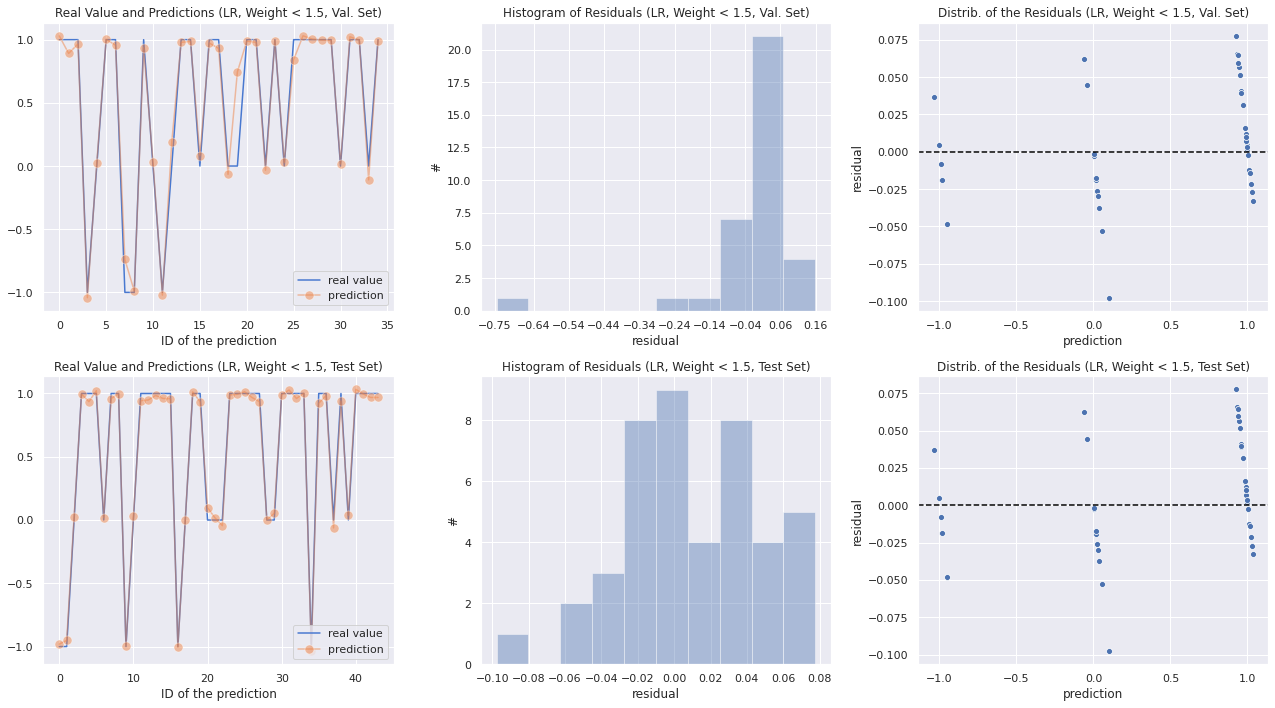

In [60]:
lin_reg_sum_test_low  = lin_summary(lin_reg_low, X_test_low, y_test_low)
lin_reg_val_pred_low  = pd.DataFrame(\
                                {'real value': y_val_low.reshape(-1,),
                                 'prediction': y_val_pred_low.reshape(-1,),
                                 'residuals':  y_val_low.reshape(-1,) -
                                               y_val_pred_low.reshape(-1,),
                                 'id':         np.arange(y_val_low.shape[0])
                                }
                                    )
lin_reg_test_pred_low = pd.DataFrame(\
                                {'real value': y_test_low.reshape(-1,),
                                 'prediction': y_test_pred_low.reshape(-1,),
                                 'residuals':  y_test_low.reshape(-1,) -
                                               y_test_pred_low.reshape(-1,),
                                 'id':         np.arange(y_test_low.shape[0])
                                }
                                    )

fig, ax = subplots(2,3)

# plot the predictions and the real values
sns.lineplot(data=lin_reg_val_pred_low,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=lin_reg_val_pred_low,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=9,             
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Real Value and Predictions (LR, Weight < 1.5, Val. Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_val_pred_low['residuals'],
             bins=10,
             kde=False,
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (LR, Weight < 1.5, Val. Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_val_pred_low['residuals']),
                               np.max(lin_reg_val_pred_low['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred_low,
                x='prediction',
                y='residuals',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distrib. of the Residuals (LR, Weight < 1.5, Val. Set)',
            xlabel='prediction',
            ylabel='residual'
           )

# plot the predictions and the real values
sns.lineplot(data=lin_reg_test_pred_low,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=lin_reg_test_pred_low,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Real Value and Predictions (LR, Weight < 1.5, Test Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_test_pred_low['residuals'],
             bins=10,
             kde=False,
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (LR, Weight < 1.5, Test Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_test_pred_low['residuals']),
                               np.max(lin_reg_test_pred_low['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred_low,
                x='prediction',
                y='residuals',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distrib. of the Residuals (LR, Weight < 1.5, Test Set)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lin_reg_low_preliminary.pdf'), dpi=150, format='pdf')

Finally we look at the summaries when `weight` $\ge 1.5$, starting from the training set:

In [61]:
lin_reg_sum_train_high = lin_summary(lin_reg_high, X_train_high, y_train_high)
lin_reg_sum_train_high

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.002274,8.082150e-03,0.281,0.779,-0.015962,0.020509
type,0.158238,2.866191e+02,0.001,1.000,-646.540989,646.857465
level_2,-1.109853,4.754569e-03,-233.380,0.000,-1.120581,-1.099125
level_3,1.137128,5.406047e-03,210.305,0.000,1.124931,1.149326
level_4,-0.991555,8.561002e-04,-1156.872,0.000,-0.993487,-0.989624
level_5,0.837461,8.931876e-04,936.561,0.000,0.835446,0.839477
level_6,-0.769817,2.180574e-04,-3514.223,0.000,-0.770309,-0.769325
level_7,0.639712,2.125223e-04,2995.996,0.000,0.639233,0.640192
level_8,-0.415585,2.691374e-05,-14888.194,0.000,-0.415646,-0.415524
level_9,0.539444,3.757511e-05,13984.246,0.000,0.539359,0.539529


Ultimately we also take a look at the validation set:

In [62]:
lin_reg_sum_val_high = lin_summary(lin_reg_high, X_val_high, y_val_high)
lin_reg_sum_val_high

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.002274,0.039586,0.057,0.956,-0.110199,0.114746
type,0.158238,461.172248,0.000,1.000,-1310.144761,1310.461237
level_2,-1.109853,0.023309,-47.612,0.000,-1.176080,-1.043626
level_3,1.137128,0.026484,42.935,0.000,1.061882,1.212375
level_4,-0.991555,0.003853,-257.253,0.000,-1.002504,-0.980607
level_5,0.837461,0.004012,208.687,0.000,0.826062,0.848860
level_6,-0.769817,0.001094,-703.038,0.000,-0.772925,-0.766708
level_7,0.639712,0.001062,601.675,0.000,0.636694,0.642730
level_8,-0.415585,0.000149,-2779.526,0.000,-0.416007,-0.415163
level_9,0.539444,0.000206,2602.809,0.000,0.538858,0.540030


Eventually we use the test set to plot errors, predictions and distributions:

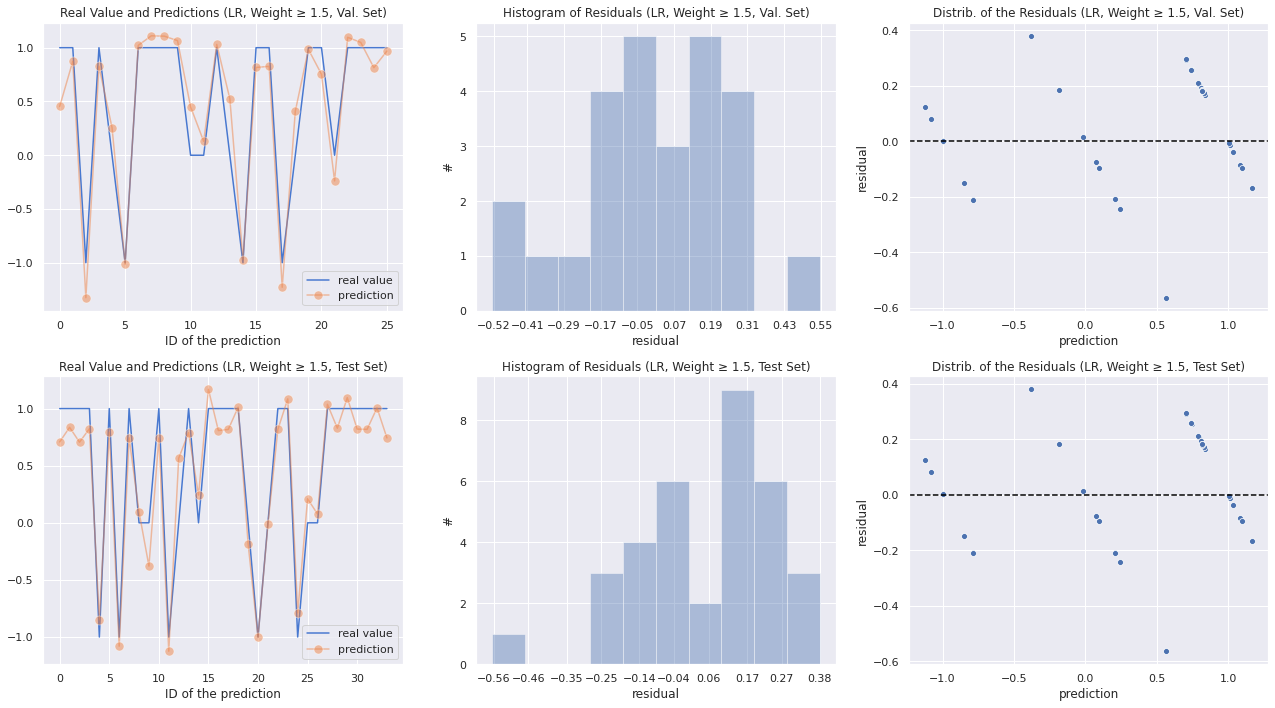

In [63]:
lin_reg_sum_test_high  = lin_summary(lin_reg_high, X_test_high, y_test_high)
lin_reg_val_pred_high  = pd.DataFrame(\
                                {'real value': y_val_high.reshape(-1,),
                                 'prediction': y_val_pred_high.reshape(-1,),
                                 'residuals':  y_val_high.reshape(-1,) -
                                               y_val_pred_high.reshape(-1,),
                                 'id':         np.arange(y_val_high.shape[0])
                                }
                                    )
lin_reg_test_pred_high = pd.DataFrame(\
                                {'real value': y_test_high.reshape(-1,),
                                 'prediction': y_test_pred_high.reshape(-1,),
                                 'residuals':  y_test_high.reshape(-1,) -
                                               y_test_pred_high.reshape(-1,),
                                 'id':         np.arange(y_test_high.shape[0])
                                }
                                    )

fig, ax = subplots(2,3)

# plot the predictions and the real values
sns.lineplot(data=lin_reg_val_pred_high,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=lin_reg_val_pred_high,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Real Value and Predictions (LR, Weight ≥ 1.5, Val. Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_val_pred_high['residuals'],
             bins=10,
             kde=False,
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (LR, Weight ≥ 1.5, Val. Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_val_pred_high['residuals']),
                               np.max(lin_reg_val_pred_high['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred_high,
                x='prediction',
                y='residuals',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distrib. of the Residuals (LR, Weight ≥ 1.5, Val. Set)',
            xlabel='prediction',
            ylabel='residual'
           )

# plot the predictions and the real values
sns.lineplot(data=lin_reg_test_pred_high,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=lin_reg_test_pred_high,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Real Value and Predictions (LR, Weight ≥ 1.5, Test Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_test_pred_high['residuals'],
             bins=10,
             kde=False,
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (LR, Weight ≥ 1.5, Test Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_test_pred_high['residuals']),
                               np.max(lin_reg_test_pred_high['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred_high,
                x='prediction',
                y='residuals',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distrib. of the Residuals (LR, Weight ≥ 1.5, Test Set)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lin_reg_high_preliminary.pdf'), dpi=150, format='pdf')

### Linear Regression Removing Categorical Variables (Preliminary)

We finally study the possibility to make accurate predictions removing the categorical variable which proved to be quite problematic in most of the previous analysis. We therefore remove the column `type` from the train/validation/test splits and train a linear model. We then analyse the situation as we did before.

In [64]:
newX_train = X_train.drop(columns='type')
newX_val   = X_val.drop(columns='type')
newX_test  = X_test.drop(columns='type')

log.info('Fitting linear regression w/o categorical variables.')

# define the model
lin_reg_nocat = LinearRegression(fit_intercept=False,
                                 normalize=False,
                                 n_jobs=THREADS
                                )

# fit the model
lin_reg_nocat.fit(newX_train, y_train)

# generate predictions
y_train_pred_nocat = lin_reg_nocat.predict(newX_train)
y_val_pred_nocat   = lin_reg_nocat.predict(newX_val)
y_test_pred_nocat  = lin_reg_nocat.predict(newX_test)

# define the no. of dof
dof_nocat = newX_train.shape[0] - newX_train.shape[1] # i.e. samples - coeff.

# compute metrics
lin_reg_nocat_train = {'MSE':    mean_squared_error(y_train,
                                                    y_train_pred_nocat
                                                   ),
                       'MSE_CI': mse_ci(y_train,
                                        y_train_pred_nocat,
                                        dof_nocat
                                       ),
                       'MAE':    mean_absolute_error(y_train,
                                                     y_train_pred_nocat
                                                    ),
                       'R2':     r2_score(y_train,
                                          y_train_pred_nocat
                                         )
                      }
lin_reg_nocat_val = {'MSE':    mean_squared_error(y_val,
                                                  
                                                  y_val_pred_nocat
                                                 
                                                 ),
                     'MSE_CI': mse_ci(y_val,
                                      
                                      y_val_pred_nocat,
                                      
                                      dof_nocat
                                     
                                     ),
                     'MAE':    mean_absolute_error(y_val,
                                                   
                                                   y_val_pred_nocat
                                                  
                                                  ),
                     'R2':     r2_score(y_val,
                                        
                                        y_val_pred_nocat
                                       
                                       )
                    }
lin_reg_nocat_test = {'MSE':    mean_squared_error(y_test,
                                                   y_test_pred_nocat
                                                  ),
                      'MSE_CI': mse_ci(y_test,
                                       y_test_pred_nocat,
                                       dof_nocat
                                      ),
                      'MAE':    mean_absolute_error(y_test,
                                                    y_test_pred_nocat
                                                   ),
                      'R2':     r2_score(y_test,
                                         y_test_pred_nocat
                                        )
                     }

# print the metrics
print('LINEAR REGRESSION (w/o CAT. VARIABLES):\n\n',
      '  Training set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_nocat_train['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.\
                                    format(lin_reg_nocat_train['MSE_CI'][0],
                                           lin_reg_nocat_train['MSE_CI'][1]
                                          ),
      '    MAE: {:.3f}\n'.format(lin_reg_nocat_train['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_nocat_train['R2']),
      '  Validation set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_nocat_val['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_nocat_val['MSE_CI'][0],
                                              lin_reg_nocat_val['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_nocat_val['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_nocat_val['R2']),
      '  Test set:\n\n',
      '    MSE: {:.3f}'.format(lin_reg_nocat_test['MSE']),
      '    95% CI: [{:.3f}, {:.3f}]\n'.format(lin_reg_nocat_test['MSE_CI'][0],
                                              lin_reg_nocat_test['MSE_CI'][1]
                                             ),
      '    MAE: {:.3f}\n'.format(lin_reg_nocat_test['MAE']),
      '    R2:  {:.3f}\n\n'.format(lin_reg_nocat_test['R2'])
     )

LINEAR REGRESSION (w/o CAT. VARIABLES):

   Training set:

     MSE: 0.248     95% CI: [0.184, 0.313]
     MAE: 0.385
     R2:  0.499

   Validation set:

     MSE: 0.290     95% CI: [0.145, 0.434]
     MAE: 0.425
     R2:  0.434

   Test set:

     MSE: 0.188     95% CI: [0.106, 0.269]
     MAE: 0.359
     R2:  0.629




We then first show the summary of the fit on the training set to better understand the impact of the categorical variable:

In [65]:
lin_reg_sum_nocat_train = lin_summary(lin_reg_nocat, newX_train, y_train)
lin_reg_sum_nocat_train

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.309511,9.055268e-03,34.176,0.000,0.289159,0.329862
level_2,-0.018191,7.209756e-03,-2.523,0.012,-0.034395,-0.001988
level_3,0.293544,8.174377e-03,35.906,0.000,0.275173,0.311915
level_4,-0.417029,1.394937e-03,-298.744,0.000,-0.420164,-0.413894
level_5,0.646449,1.455622e-03,443.800,0.000,0.643177,0.649720
level_6,-0.466234,3.595384e-04,-1293.161,0.000,-0.467042,-0.465426
level_7,0.793690,3.505589e-04,2257.629,0.000,0.792902,0.794477
level_8,-0.369343,4.502478e-05,-8024.863,0.000,-0.369444,-0.369241
level_9,0.879175,6.285976e-05,13767.270,0.000,0.879033,0.879316
level_10,-0.263049,1.471396e-05,-16739.794,0.000,-0.263082,-0.263015


It seems that the coefficients in this case are all clearly different from zero with a very large confidence. We then move to the validation set for evaluation:

In [66]:
lin_reg_sum_nocat_val = lin_summary(lin_reg_nocat, newX_val, y_val)
lin_reg_sum_nocat_val

,coefficients,standard error,t statistic,p value (t_obs > |t|),95% CI (lower),95% CI (upper)
weight,0.309511,0.034081,9.081,0.00,0.230353,0.388668
level_2,-0.018191,0.027404,-0.664,0.51,-0.081839,0.045457
level_3,0.293544,0.031017,9.464,0.00,0.221504,0.365584
level_4,-0.417029,0.004830,-86.322,0.00,-0.428247,-0.405810
level_5,0.646449,0.005030,128.503,0.00,0.634767,0.658131
level_6,-0.466234,0.001387,-335.896,0.00,-0.469456,-0.463013
level_7,0.793690,0.001348,588.460,0.00,0.790559,0.796820
level_8,-0.369343,0.000193,-1905.467,0.00,-0.369790,-0.368895
level_9,0.879175,0.000268,3271.234,0.00,0.878553,0.879796
level_10,-0.263049,0.000065,-3996.414,0.00,-0.263199,-0.262898


In this case we find that there is at least another coefficient which cannot be assumed to differ from 0 with confidence. In the end it seems that the categorical variable may actually help or, at worst, be completely irrelevant for the fit.

Finally we consider the test set to plot residuals and predictions:

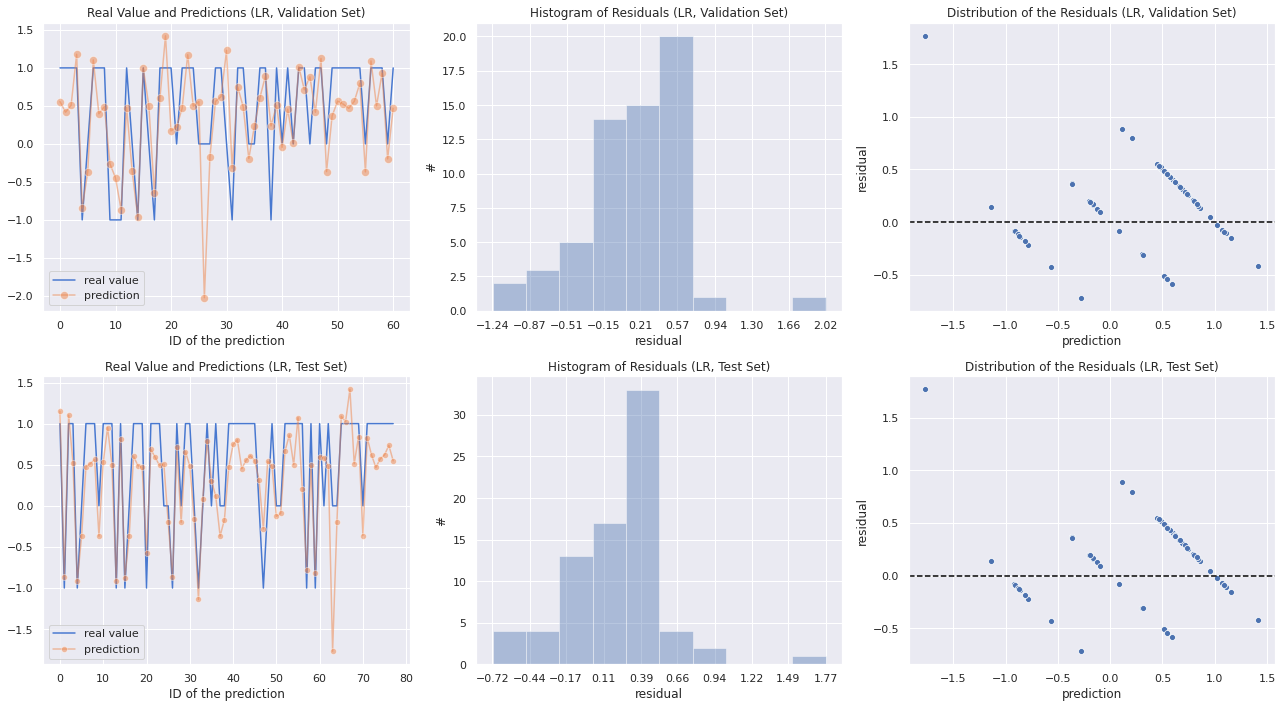

In [67]:
lin_reg_sum_nocat_test  = lin_summary(lin_reg_nocat, newX_test, y_test)
lin_reg_val_pred_nocat  = pd.DataFrame({'real value': y_val.\
                                                        reshape(-1,),
                                        'prediction': y_val_pred_nocat.\
                                                        reshape(-1,),
                                        'residuals':  y_val.\
                                                        reshape(-1,) -
                                                      y_val_pred_nocat.\
                                                        reshape(-1,),
                                        'id':         np.arange(y_val.\
                                                        shape[0])
                                 }
                                )
lin_reg_test_pred_nocat = pd.DataFrame({'real value': y_test.\
                                                        reshape(-1,),
                                        'prediction': y_test_pred_nocat.\
                                                        reshape(-1,),
                                        'residuals':  y_test.\
                                                        reshape(-1,) -
                                                      y_test_pred_nocat.\
                                                        reshape(-1,),
                                        'id':         np.arange(y_test.\
                                                        shape[0])
                                 }
                                )

fig, ax = subplots(2,3)

# plot the predictions and the real values
sns.lineplot(data=lin_reg_val_pred_nocat,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=lin_reg_val_pred_nocat,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             markersize=8,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Real Value and Predictions (LR, Validation Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_val_pred_nocat['residuals'],
             bins=10,
             kde=False,
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (LR, Validation Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_val_pred_nocat['residuals']),
                               np.max(lin_reg_val_pred_nocat['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred_nocat,
                x='prediction',
                y='residuals',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (LR, Validation Set)',
            xlabel='prediction',
            ylabel='residual'
           )

# plot the predictions and the real values
sns.lineplot(data=lin_reg_test_pred_nocat,
             x='id',
             y='real value',
             label='real value',
             color=sns.color_palette('muted', 2)[0],
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=lin_reg_test_pred_nocat,
             x='id',
             y='prediction',
             label='prediction',
             color=sns.color_palette('muted', 2)[1],
             marker='o',
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Real Value and Predictions (LR, Test Set)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of the errors
sns.distplot(lin_reg_test_pred_nocat['residuals'],
             bins=10,
             kde=False,
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (LR, Test Set)',
            xlabel='residual',
            ylabel='#',
            xticks=np.round(\
                   np.linspace(np.min(lin_reg_test_pred_nocat['residuals']),
                               np.max(lin_reg_test_pred_nocat['residuals']),
                               10
                              ),
                          2
                         )
         )

# plot the distribution of the residuals
sns.scatterplot(data=lin_reg_test_pred_nocat,
                x='prediction',
                y='residuals',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (LR, Test Set)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lin_reg_nocat_preliminary.pdf'), dpi=150, format='pdf')

## Machine Learning Analysis

We can now finally move to the ML analysis. From the previous study we learnt that we may be able to draw significant predictions from the dataset: the best strategy for the moment might be to take the full dataset and try to adjust the algorithm to improve the predictions (we may think about split the algorithm into higher and lower `weight` in a different analysis.

We will investigate several possible algorithms:

- **linear models** such as (simple) linear regression (LR), _elastic net_ (EN) to add L1 and L2 regularisation, _lasso_ for L1 regularisation, _ridge_ for L2 regularisation,
- **SVM** algorithms such as _linear SVR_ (l-SVR), SVR with _Gaussian kernel_ (r-SVR, from _rbf_, _radial basis function_),
- **decision trees** based algorithms such as _random forests_ (RF) and _gradient boosted decision trees_ (GBDT),
- **artificial neural networks** (ANN).

For most algorithms we perform hyperparameter optimisation using Bayesan optimisation of MSE.

### Linear Regression

In this first scenario, we do not have any hyperparameter to tune and can therefore proceed with simple training and inference:

In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics      import mean_squared_error, \
                                 mean_absolute_error, \
                                 r2_score

log.info('Fitting linear regression.')

# define the model
lin_reg = LinearRegression(fit_intercept=False,
                           normalize=False,
                           n_jobs=THREADS
                          )

# fit the model
lin_reg.fit(X_train, y_train)

# compute predictions
lin_reg_train_pred = lin_reg.predict(X_train).reshape(-1,)
lin_reg_val_pred   = lin_reg.predict(X_val).reshape(-1,)
lin_reg_test_pred  = lin_reg.predict(X_test).reshape(-1,)

# compute the no. of dofs
dof_train = X_train.shape[0] - X_train.shape[1]
dof_val   = X_val.shape[0] - X_val.shape[1]
dof_test  = X_test.shape[0] - X_test.shape[1]

# store metrics
lin_reg_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   lin_reg_train_pred
                                                  ),
                   'tr_ci_low': mse_ci(y_train,
                                       lin_reg_train_pred,
                                       dof_train
                                      )[0],
                   'tr_ci_upp': mse_ci(y_train,
                                       lin_reg_train_pred,
                                       dof_train
                                      )[1],
                   'tr_mae':    mean_absolute_error(y_train,
                                                    lin_reg_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         lin_reg_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   lin_reg_val_pred
                                                  ),
                   'v_ci_low':  mse_ci(y_val,
                                       lin_reg_val_pred,
                                       dof_val
                                      )[0],
                   'v_ci_upp':  mse_ci(y_val,
                                       lin_reg_val_pred,
                                       dof_val
                                      )[1],
                   'v_mae':     mean_absolute_error(y_val,
                                                    lin_reg_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         lin_reg_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   lin_reg_test_pred
                                                  ),
                   'te_ci_low': mse_ci(y_test,
                                       lin_reg_test_pred,
                                       dof_test
                                      )[0],
                   'te_ci_upp': mse_ci(y_test,
                                       lin_reg_test_pred,
                                       dof_test
                                      )[1],
                   'te_mae':    mean_absolute_error(y_test,
                                                    lin_reg_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         lin_reg_test_pred
                                        ),
                  }
lin_reg_metrics = pd.DataFrame(lin_reg_metrics, index=['lin_reg'])

We can then print the metrics associated to the fit:

In [69]:
print(\
'LINEAR REGRESSION:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}'.format(lin_reg_metrics['tr_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lin_reg_metrics['tr_ci_low'].squeeze(),
                                       lin_reg_metrics['tr_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lin_reg_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lin_reg_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}'.format(lin_reg_metrics['v_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lin_reg_metrics['v_ci_low'].squeeze(),
                                       lin_reg_metrics['v_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lin_reg_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lin_reg_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}'.format(lin_reg_metrics['te_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lin_reg_metrics['te_ci_low'].squeeze(),
                                       lin_reg_metrics['te_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lin_reg_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lin_reg_metrics['te_rsq'].squeeze())
)

LINEAR REGRESSION:

   Training set:

     MSE: 0.165     95% CI [0.131, 0.199]
     MAE: 0.294
     R2:  0.668

   Validation set:

     MSE: 0.229     95% CI [0.099, 0.359]
     MAE: 0.350
     R2:  0.552

   Test set:

     MSE: 0.132     95% CI [0.065, 0.199]
     MAE: 0.274
     R2:  0.740




We then prepare lists of the predictions made using the estimator:

In [70]:
# prepare a database for training predictions
ml_train_predictions = train[['solutions',
                              'init',
                              'weight',
                              'type',
                              'exp']].copy()
ml_train_predictions = ml_train_predictions.reset_index(drop=True)
ml_train_predictions['lr']     = lin_reg_train_pred
ml_train_predictions['lr_res'] = y_train - lin_reg_train_pred

# prepare a database for validation predictions
ml_val_predictions = valid[['solutions',
                            'init',
                            'weight',
                            'type',
                            'exp']].copy()
ml_val_predictions = ml_val_predictions.reset_index(drop=True)
ml_val_predictions['lr']     = lin_reg_val_pred
ml_val_predictions['lr_res'] = y_val - lin_reg_val_pred

# prepare a database for test predictions
ml_test_predictions = test[['solutions',
                            'init',
                            'weight',
                            'type',
                            'exp']].copy()
ml_test_predictions = ml_test_predictions.reset_index(drop=True)
ml_test_predictions['lr']     = lin_reg_test_pred
ml_test_predictions['lr_res'] = y_test - lin_reg_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

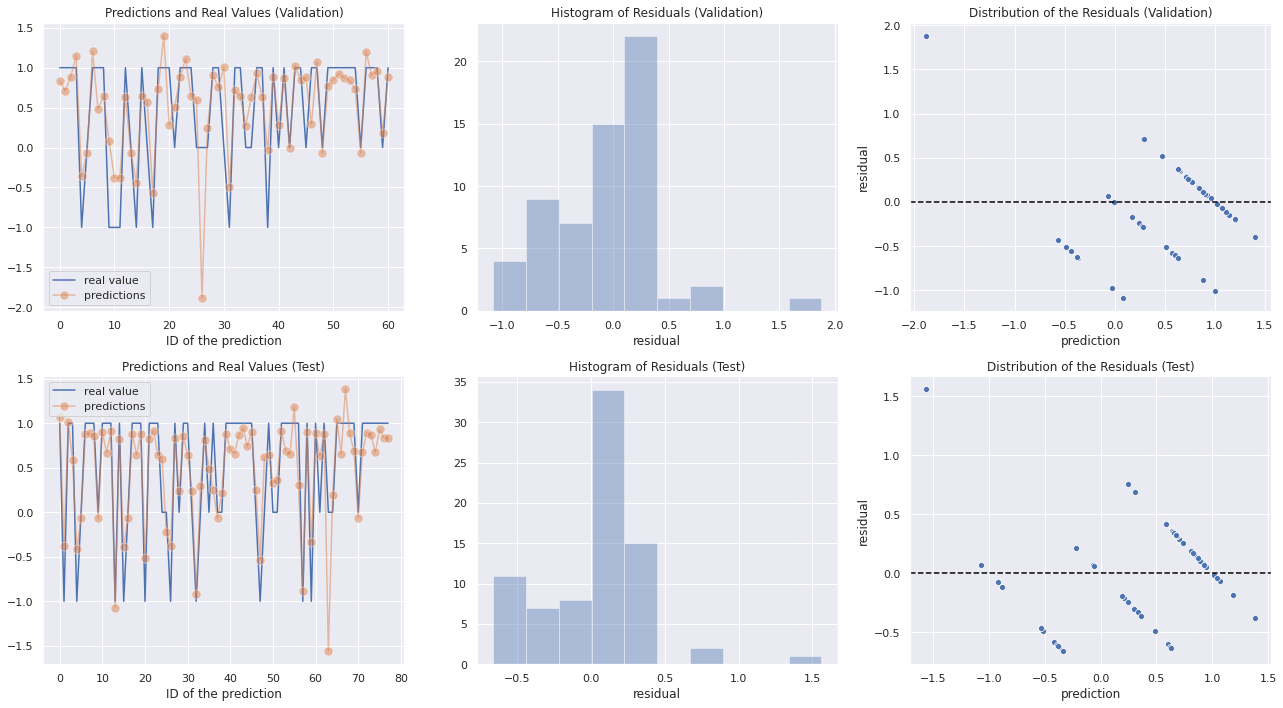

In [71]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='lr',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='lr',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['lr_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['lr_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='lr',
                y='lr_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='lr',
                y='lr_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lin_reg.pdf'), dpi=150, format='pdf')

### Elastic Net

We then introduce both L1 and L2 regularisation using the _elastic net_: we look for the contributions of L1-norm and L2-norm to the fit in order to improve the prediction.

In [72]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics      import mean_squared_error, \
                                 mean_absolute_error, \
                                 r2_score
from skopt                import gp_minimize
from skopt.space          import Categorical, Integer, Real
from skopt.utils          import use_named_args

log.info('Fitting the elastic net.')

# define the model
els_net = ElasticNet(fit_intercept=False,
                     normalize=False,
                     max_iter=1e5,
                     random_state=RAND
                    )

# define the hyperparameters
hyperparameters = [Real(1.0e-3, 1.0e-1, prior='log-uniform', name='alpha'),
                   Real(0.0, 1.0, name='l1_ratio')
                  ]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    els_net.set_params(**args)
    els_net.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = els_net.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
els_net_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=30,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [73]:
# extract the hyperparameters
els_net_hyper = dict(zip(hyper_names, els_net_res.x))
print('Best hyperparameters:\n')
for key, value in els_net_hyper.items():
    print('  {}: {:.3f}'.format(key, value))

Best hyperparameters:

  alpha: 0.001
  l1_ratio: 0.000


We then train the algorithm again on the training set and compute metrics and predictions:

In [74]:
# train the new algorithm
els_net = els_net.set_params(**els_net_hyper)
els_net = els_net.fit(X_train, y_train)

# compute predictions
els_net_train_pred = els_net.predict(X_train).reshape(-1,)
els_net_val_pred   = els_net.predict(X_val).reshape(-1,)
els_net_test_pred  = els_net.predict(X_test).reshape(-1,)

# store metrics
els_net_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   els_net_train_pred
                                                  ),
                   'tr_ci_low': mse_ci(y_train,
                                       els_net_train_pred,
                                       dof_train
                                      )[0],
                   'tr_ci_upp': mse_ci(y_train,
                                       els_net_train_pred,
                                       dof_train
                                      )[1],
                   'tr_mae':    mean_absolute_error(y_train,
                                                    els_net_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         els_net_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   els_net_val_pred
                                                  ),
                   'v_ci_low':  mse_ci(y_val,
                                       els_net_val_pred,
                                       dof_val
                                      )[0],
                   'v_ci_upp':  mse_ci(y_val,
                                       els_net_val_pred,
                                       dof_val
                                      )[1],
                   'v_mae':     mean_absolute_error(y_val,
                                                    els_net_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         els_net_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   els_net_test_pred
                                                  ),
                   'te_ci_low': mse_ci(y_test,
                                       els_net_test_pred,
                                       dof_test
                                      )[0],
                   'te_ci_upp': mse_ci(y_test,
                                       els_net_test_pred,
                                       dof_test
                                      )[1],
                   'te_mae':    mean_absolute_error(y_test,
                                                    els_net_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         els_net_test_pred
                                        ),
                  }
els_net_metrics = pd.DataFrame(els_net_metrics, index=['els_net'])

We then print the metrics for comparison:

In [75]:
print(\
'ELASTIC NET:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}'.format(els_net_metrics['tr_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(els_net_metrics['tr_ci_low'].squeeze(),
                                       els_net_metrics['tr_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(els_net_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(els_net_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}'.format(els_net_metrics['v_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(els_net_metrics['v_ci_low'].squeeze(),
                                       els_net_metrics['v_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(els_net_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(els_net_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}'.format(els_net_metrics['te_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(els_net_metrics['te_ci_low'].squeeze(),
                                       els_net_metrics['te_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(els_net_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(els_net_metrics['te_rsq'].squeeze())
)

ELASTIC NET:

   Training set:

     MSE: 0.233     95% CI [0.187, 0.279]
     MAE: 0.349
     R2:  0.529

   Validation set:

     MSE: 0.253     95% CI [0.144, 0.361]
     MAE: 0.383
     R2:  0.506

   Test set:

     MSE: 0.193     95% CI [0.119, 0.267]
     MAE: 0.328
     R2:  0.619




We can now save the predictions in the database of predictions we prepared:

In [76]:
# store training predictions
ml_train_predictions['en']     = els_net_train_pred
ml_train_predictions['en_res'] = y_train - lin_reg_train_pred

# store validation predictions
ml_val_predictions['en']     = els_net_val_pred
ml_val_predictions['en_res'] = y_val - lin_reg_val_pred

# store test predictions
ml_test_predictions['en']     = els_net_test_pred
ml_test_predictions['en_res'] = y_test - lin_reg_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

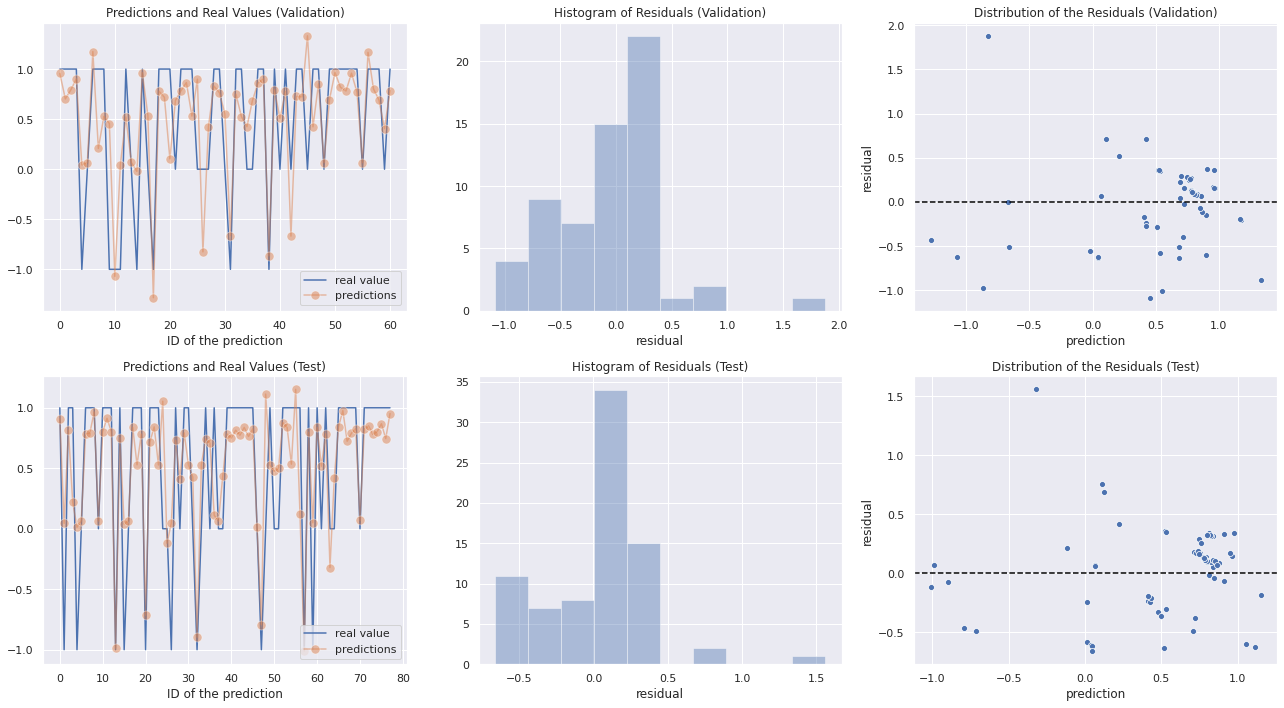

In [77]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='en',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='en',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['en_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['en_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='en',
                y='en_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='en',
                y='en_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('els_net.pdf'), dpi=150, format='pdf')

### Lasso

Using the _lasso_ regression we investigate the impact of L1 regularisation on the model.

In [78]:
from sklearn.linear_model import Lasso
from sklearn.metrics      import mean_squared_error, \
                                 mean_absolute_error, \
                                 r2_score
from skopt                import gp_minimize
from skopt.space          import Categorical, Integer, Real
from skopt.utils          import use_named_args

log.info('Fitting the lasso.')

# define the model
lss_reg = Lasso(fit_intercept=False,
                normalize=False,
                max_iter=1e5,
                random_state=RAND
               )

# define the hyperparameters
hyperparameters = [Real(1.0e-2, 1.0e1, prior='log-uniform', name='alpha')]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    lss_reg.set_params(**args)
    lss_reg.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = lss_reg.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
lss_reg_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=30,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [79]:
# extract the hyperparameters
lss_reg_hyper = dict(zip(hyper_names, lss_reg_res.x))
print('Best hyperparameters:\n')
for key, value in lss_reg_hyper.items():
    print('  {}: {:.3f}'.format(key, value))

Best hyperparameters:

  alpha: 0.010


We then train the algorithm again on the training set and compute metrics and predictions:

In [80]:
# train the new algorithm
lss_reg = lss_reg.set_params(**lss_reg_hyper)
lss_reg = lss_reg.fit(X_train, y_train)

# compute predictions
lss_reg_train_pred = lss_reg.predict(X_train).reshape(-1,)
lss_reg_val_pred   = lss_reg.predict(X_val).reshape(-1,)
lss_reg_test_pred  = lss_reg.predict(X_test).reshape(-1,)

# store metrics
lss_reg_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   lss_reg_train_pred
                                                  ),
                   'tr_ci_low': mse_ci(y_train,
                                       lss_reg_train_pred,
                                       dof_train
                                      )[0],
                   'tr_ci_upp': mse_ci(y_train,
                                       lss_reg_train_pred,
                                       dof_train
                                      )[1],
                   'tr_mae':    mean_absolute_error(y_train,
                                                    lss_reg_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         lss_reg_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   lss_reg_val_pred
                                                  ),
                   'v_ci_low':  mse_ci(y_val,
                                       lss_reg_val_pred,
                                       dof_val
                                      )[0],
                   'v_ci_upp':  mse_ci(y_val,
                                       lss_reg_val_pred,
                                       dof_val
                                      )[1],
                   'v_mae':     mean_absolute_error(y_val,
                                                    lss_reg_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         lss_reg_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   lss_reg_test_pred
                                                  ),
                   'te_ci_low': mse_ci(y_test,
                                       lss_reg_test_pred,
                                       dof_test
                                      )[0],
                   'te_ci_upp': mse_ci(y_test,
                                       lss_reg_test_pred,
                                       dof_test
                                      )[1],
                   'te_mae':    mean_absolute_error(y_test,
                                                    lss_reg_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         lss_reg_test_pred
                                        ),
                  }
lss_reg_metrics = pd.DataFrame(lss_reg_metrics, index=['lss_reg'])

We then print the metrics for comparison:

In [81]:
print(\
'LASSO:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}'.format(lss_reg_metrics['tr_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lss_reg_metrics['tr_ci_low'].squeeze(),
                                       lss_reg_metrics['tr_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lss_reg_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lss_reg_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}'.format(lss_reg_metrics['v_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lss_reg_metrics['v_ci_low'].squeeze(),
                                       lss_reg_metrics['v_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lss_reg_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lss_reg_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}'.format(lss_reg_metrics['te_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lss_reg_metrics['te_ci_low'].squeeze(),
                                       lss_reg_metrics['te_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lss_reg_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lss_reg_metrics['te_rsq'].squeeze())
)

LASSO:

   Training set:

     MSE: 0.237     95% CI [0.192, 0.282]
     MAE: 0.354
     R2:  0.522

   Validation set:

     MSE: 0.260     95% CI [0.149, 0.371]
     MAE: 0.391
     R2:  0.492

   Test set:

     MSE: 0.204     95% CI [0.125, 0.282]
     MAE: 0.343
     R2:  0.598




We can now save the predictions in the database of predictions we prepared:

In [82]:
# store training predictions
ml_train_predictions['ls']     = lss_reg_train_pred
ml_train_predictions['ls_res'] = y_train - lss_reg_train_pred

# store validation predictions
ml_val_predictions['ls']     = lss_reg_val_pred
ml_val_predictions['ls_res'] = y_val - lss_reg_val_pred

# store test predictions
ml_test_predictions['ls']     = lss_reg_test_pred
ml_test_predictions['ls_res'] = y_test - lss_reg_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

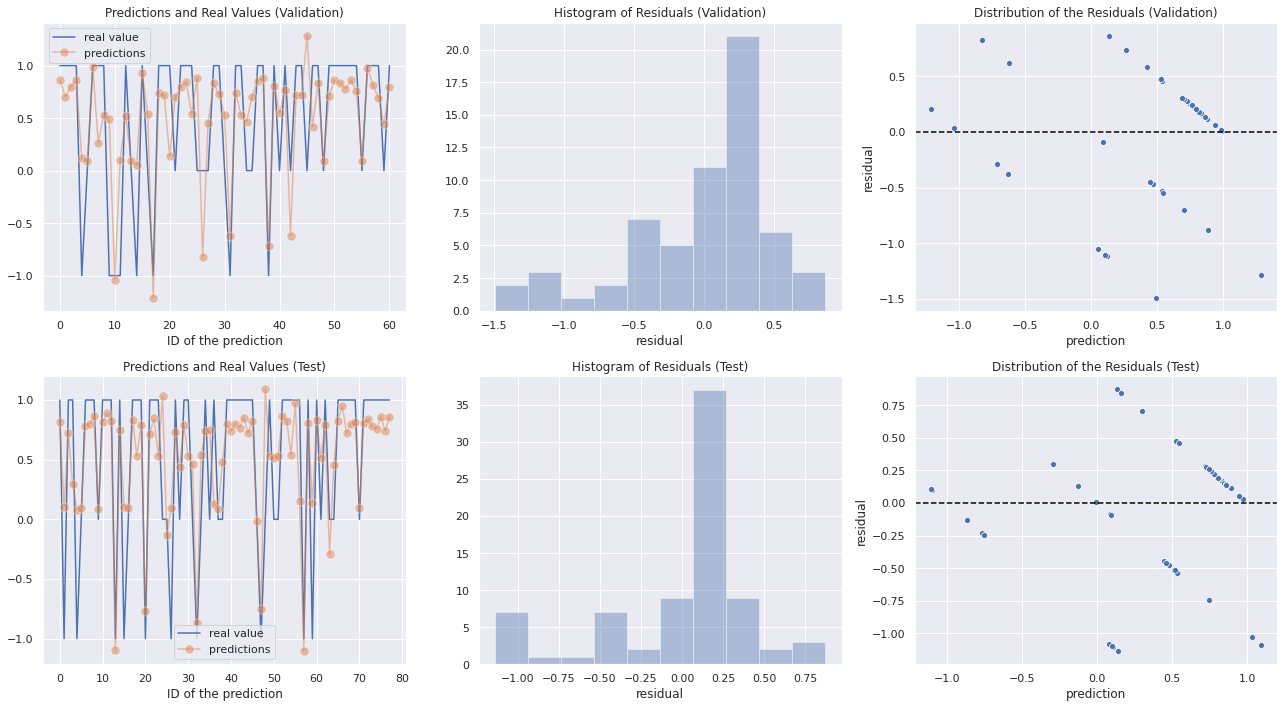

In [83]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='ls',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='ls',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['ls_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['ls_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='ls',
                y='ls_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='ls',
                y='ls_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lss_reg.pdf'), dpi=150, format='pdf')

### Ridge

L2 regularisation can then be probed using the _ridge_ regression.

In [84]:
from sklearn.linear_model import Ridge
from sklearn.metrics      import mean_squared_error, \
                                 mean_absolute_error, \
                                 r2_score
from skopt                import gp_minimize
from skopt.space          import Categorical, Integer, Real
from skopt.utils          import use_named_args

log.info('Fitting the ridge.')

# define the model
rdg_reg = Ridge(fit_intercept=False,
                normalize=False,
                random_state=RAND
               )

# define the hyperparameters
hyperparameters = [Real(1.0e-3, 1.0e-1, prior='log-uniform', name='alpha')]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    rdg_reg.set_params(**args)
    rdg_reg.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = rdg_reg.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
rdg_reg_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=50,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [85]:
# extract the hyperparameters
rdg_reg_hyper = dict(zip(hyper_names, rdg_reg_res.x))
print('Best hyperparameters:\n')
for key, value in rdg_reg_hyper.items():
    print('  {}: {:.3f}'.format(key, value))

Best hyperparameters:

  alpha: 0.001


We then train the algorithm again on the training set and compute metrics and predictions:

In [86]:
# train the new algorithm
rdg_reg = rdg_reg.set_params(**rdg_reg_hyper)
rdg_reg = rdg_reg.fit(X_train, y_train)

# compute predictions
rdg_reg_train_pred = rdg_reg.predict(X_train).reshape(-1,)
rdg_reg_val_pred   = rdg_reg.predict(X_val).reshape(-1,)
rdg_reg_test_pred  = rdg_reg.predict(X_test).reshape(-1,)

# store metrics
rdg_reg_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   rdg_reg_train_pred
                                                  ),
                   'tr_ci_low': mse_ci(y_train,
                                       rdg_reg_train_pred,
                                       dof_train
                                      )[0],
                   'tr_ci_upp': mse_ci(y_train,
                                       rdg_reg_train_pred,
                                       dof_train
                                      )[1],
                   'tr_mae':    mean_absolute_error(y_train,
                                                    rdg_reg_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         rdg_reg_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   rdg_reg_val_pred
                                                  ),
                   'v_ci_low':  mse_ci(y_val,
                                       rdg_reg_val_pred,
                                       dof_val
                                      )[0],
                   'v_ci_upp':  mse_ci(y_val,
                                       rdg_reg_val_pred,
                                       dof_val
                                      )[1],
                   'v_mae':     mean_absolute_error(y_val,
                                                    rdg_reg_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         rdg_reg_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   rdg_reg_test_pred
                                                  ),
                   'te_ci_low': mse_ci(y_test,
                                       rdg_reg_test_pred,
                                       dof_test
                                      )[0],
                   'te_ci_upp': mse_ci(y_test,
                                       rdg_reg_test_pred,
                                       dof_test
                                      )[1],
                   'te_mae':    mean_absolute_error(y_test,
                                                    rdg_reg_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         rdg_reg_test_pred
                                        ),
                  }
rdg_reg_metrics = pd.DataFrame(rdg_reg_metrics, index=['rdg_reg'])

We then print the metrics for comparison:

In [87]:
print(\
'RIDGE:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}'.format(rdg_reg_metrics['tr_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(rdg_reg_metrics['tr_ci_low'].squeeze(),
                                       rdg_reg_metrics['tr_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(rdg_reg_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(rdg_reg_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}'.format(rdg_reg_metrics['v_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(rdg_reg_metrics['v_ci_low'].squeeze(),
                                       rdg_reg_metrics['v_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(rdg_reg_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(rdg_reg_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}'.format(rdg_reg_metrics['te_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(rdg_reg_metrics['te_ci_low'].squeeze(),
                                       rdg_reg_metrics['te_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(rdg_reg_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(rdg_reg_metrics['te_rsq'].squeeze())
)

RIDGE:

   Training set:

     MSE: 0.165     95% CI [0.131, 0.199]
     MAE: 0.294
     R2:  0.668

   Validation set:

     MSE: 0.229     95% CI [0.099, 0.359]
     MAE: 0.350
     R2:  0.552

   Test set:

     MSE: 0.132     95% CI [0.065, 0.199]
     MAE: 0.274
     R2:  0.740




We can now save the predictions in the database of predictions we prepared:

In [88]:
# store training predictions
ml_train_predictions['rd']     = rdg_reg_train_pred
ml_train_predictions['rd_res'] = y_train - rdg_reg_train_pred

# store validation predictions
ml_val_predictions['rd']     = rdg_reg_val_pred
ml_val_predictions['rd_res'] = y_val - rdg_reg_val_pred

# store test predictions
ml_test_predictions['rd']     = rdg_reg_test_pred
ml_test_predictions['rd_res'] = y_test - rdg_reg_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

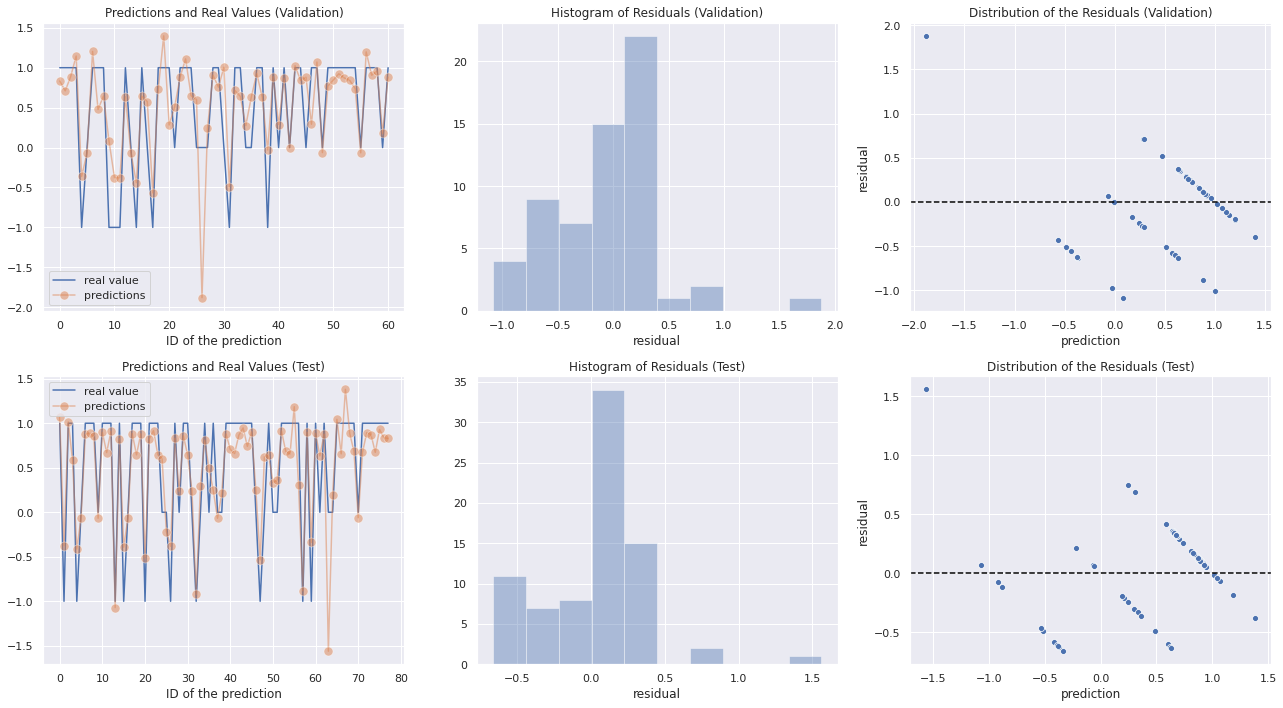

In [89]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='rd',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='rd',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['rd_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['rd_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='rd',
                y='rd_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='rd',
                y='rd_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('rdg_reg.pdf'), dpi=150, format='pdf')

### Linear SVR

Moving to SVM algorithms, we first investigate a linear model (l-SVR) as a baseline computation.

In [90]:
from sklearn.svm     import LinearSVR
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error, \
                            r2_score
from skopt           import gp_minimize
from skopt.space     import Categorical, Integer, Real
from skopt.utils     import use_named_args

log.info('Fitting the linear SVR.')

# define the model
lin_svr = LinearSVR(fit_intercept=False,
                    max_iter=1e4,
                    random_state=RAND
                   )

# define the hyperparameters
hyperparameters = [Real(1.0e-6, 1.0e-1, prior='log-uniform', name='epsilon'),
                   Real(1.0e1, 1.0e3, prior='log-uniform', name='C'),
                   Categorical(['epsilon_insensitive',
                                'squared_epsilon_insensitive'
                               ],
                               name='loss'
                              ),
                   
                  ]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    lin_svr.set_params(**args)
    lin_svr.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = lin_svr.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
lin_svr_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=30,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [91]:
# extract the hyperparameters
lin_svr_hyper = dict(zip(hyper_names, lin_svr_res.x))
print('Best hyperparameters:\n')
for key, value in lin_svr_hyper.items():
    if isinstance(value, float):
        print('  {}: {:.9f}'.format(key, value))
    else:
        print('  {}: {}'.format(key, value))

Best hyperparameters:

  epsilon: 0.008982320
  C: 17.242168802
  loss: epsilon_insensitive


We then train the algorithm again on the training set and compute metrics and predictions:

In [92]:
# train the new algorithm
lin_svr = lin_svr.set_params(**lin_svr_hyper)
lin_svr = lin_svr.fit(X_train, y_train)

# compute predictions
lin_svr_train_pred = lin_svr.predict(X_train).reshape(-1,)
lin_svr_val_pred   = lin_svr.predict(X_val).reshape(-1,)
lin_svr_test_pred  = lin_svr.predict(X_test).reshape(-1,)

# store metrics
lin_svr_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   lin_svr_train_pred
                                                  ),
                   'tr_ci_low': mse_ci(y_train,
                                       lin_svr_train_pred,
                                       dof_train
                                      )[0],
                   'tr_ci_upp': mse_ci(y_train,
                                       lin_svr_train_pred,
                                       dof_train
                                      )[1],
                   'tr_mae':    mean_absolute_error(y_train,
                                                    lin_svr_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         lin_svr_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   lin_svr_val_pred
                                                  ),
                   'v_ci_low':  mse_ci(y_val,
                                       lin_svr_val_pred,
                                       dof_val
                                      )[0],
                   'v_ci_upp':  mse_ci(y_val,
                                       lin_svr_val_pred,
                                       dof_val
                                      )[1],
                   'v_mae':     mean_absolute_error(y_val,
                                                    lin_svr_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         lin_svr_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   lin_svr_test_pred
                                                  ),
                   'te_ci_low': mse_ci(y_test,
                                       lin_svr_test_pred,
                                       dof_test
                                      )[0],
                   'te_ci_upp': mse_ci(y_test,
                                       lin_svr_test_pred,
                                       dof_test
                                      )[1],
                   'te_mae':    mean_absolute_error(y_test,
                                                    lin_svr_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         lin_svr_test_pred
                                        ),
                  }
lin_svr_metrics = pd.DataFrame(lin_svr_metrics, index=['lin_svr'])

We then print the metrics for comparison:

In [93]:
print(\
'LINEAR SVR:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}'.format(lin_svr_metrics['tr_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lin_svr_metrics['tr_ci_low'].squeeze(),
                                       lin_svr_metrics['tr_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lin_svr_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lin_svr_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}'.format(lin_svr_metrics['v_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lin_svr_metrics['v_ci_low'].squeeze(),
                                       lin_svr_metrics['v_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lin_svr_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lin_svr_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}'.format(lin_svr_metrics['te_mse'].squeeze()),
'    95% CI [{:.3f}, {:.3f}]\n'.format(lin_svr_metrics['te_ci_low'].squeeze(),
                                       lin_svr_metrics['te_ci_upp'].squeeze()
                                      ),
'    MAE: {:.3f}\n'.format(lin_svr_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(lin_svr_metrics['te_rsq'].squeeze())
)

LINEAR SVR:

   Training set:

     MSE: 2194.290     95% CI [117.410, 4271.170]
     MAE: 7.947
     R2:  -4425.249

   Validation set:

     MSE: 2057.150     95% CI [-1261.068, 5375.368]
     MAE: 10.358
     R2:  -4019.302

   Test set:

     MSE: 8117.642     95% CI [-2625.998, 18861.281]
     MAE: 18.624
     R2:  -16028.773




We can now save the predictions in the database of predictions we prepared:

In [94]:
# store training predictions
ml_train_predictions['lv']     = lin_svr_train_pred
ml_train_predictions['lv_res'] = y_train - lin_svr_train_pred

# store validation predictions
ml_val_predictions['lv']     = lin_svr_val_pred
ml_val_predictions['lv_res'] = y_val - lin_svr_val_pred

# store test predictions
ml_test_predictions['lv']     = lin_svr_test_pred
ml_test_predictions['lv_res'] = y_test - lin_svr_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

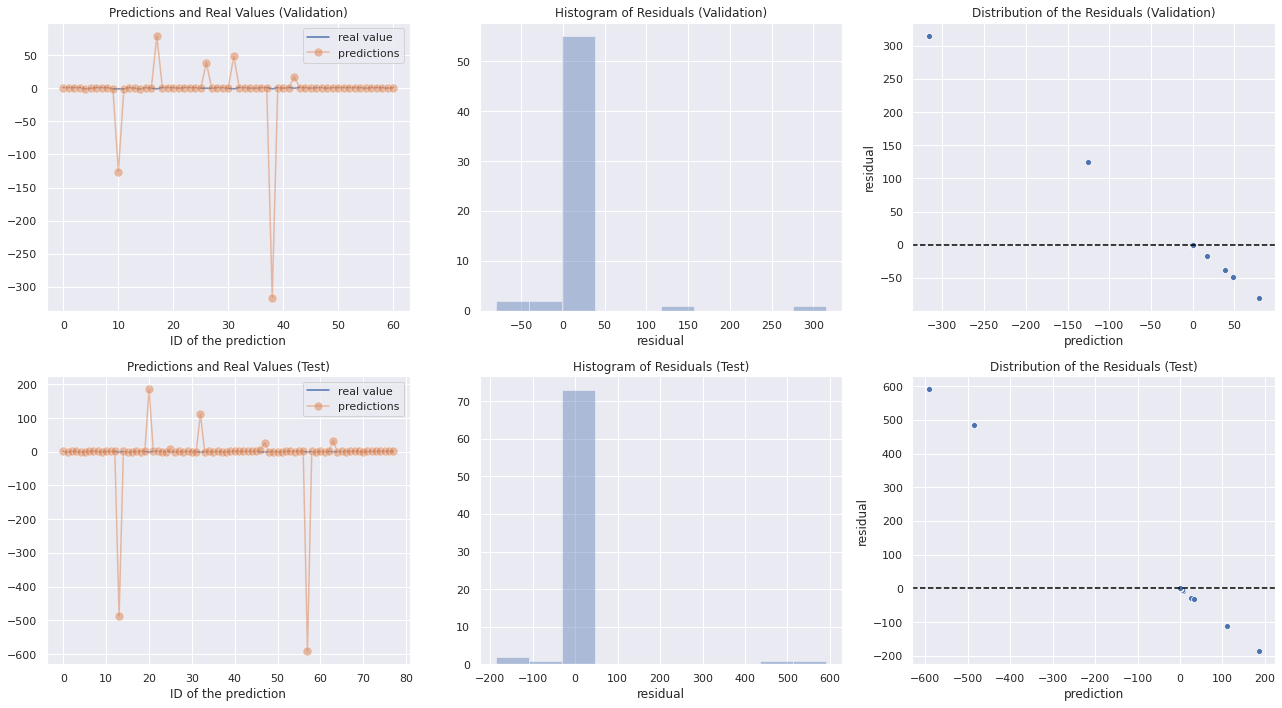

In [95]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='lv',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='lv',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['lv_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['lv_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='lv',
                y='lv_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='lv',
                y='lv_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('lin_svr.pdf'), dpi=150, format='pdf')

### Gaussian SVR

We then apply the _kernel trick_ to the SVM algorithm.

In [96]:
from sklearn.svm     import SVR
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error, \
                            r2_score
from skopt           import gp_minimize
from skopt.space     import Categorical, Integer, Real
from skopt.utils     import use_named_args

log.info('Fitting the Gaussian SVR.')

# define the model
svr_rbf = SVR(kernel='rbf')

# define the hyperparameters
hyperparameters = [Real(1e-5, 1e-1, prior='log-uniform', name='gamma'),
                   Real(1.0e-3, 1.0e-1, prior='log-uniform', name='epsilon'),
                   Real(1.0e1, 1.0e3, prior='log-uniform', name='C')
                  ]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    svr_rbf.set_params(**args)
    svr_rbf.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = svr_rbf.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
svr_rbf_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=75,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [97]:
# extract the hyperparameters
svr_rbf_hyper = dict(zip(hyper_names, svr_rbf_res.x))
print('Best hyperparameters:\n')
for key, value in svr_rbf_hyper.items():
    if isinstance(value, float):
        print('  {}: {:.9f}'.format(key, value))
    else:
        print('  {}: {}'.format(key, value))

Best hyperparameters:

  gamma: 0.000036095
  epsilon: 0.001000000
  C: 1000.000000000


We then train the algorithm again on the training set and compute metrics and predictions:

In [98]:
# train the new algorithm
svr_rbf = svr_rbf.set_params(**svr_rbf_hyper)
svr_rbf = svr_rbf.fit(X_train, y_train)

# compute predictions
svr_rbf_train_pred = svr_rbf.predict(X_train).reshape(-1,)
svr_rbf_val_pred   = svr_rbf.predict(X_val).reshape(-1,)
svr_rbf_test_pred  = svr_rbf.predict(X_test).reshape(-1,)

# store metrics
svr_rbf_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   svr_rbf_train_pred
                                                  ),
                   'tr_mae':    mean_absolute_error(y_train,
                                                    svr_rbf_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         svr_rbf_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   svr_rbf_val_pred
                                                  ),
                   'v_mae':     mean_absolute_error(y_val,
                                                    svr_rbf_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         svr_rbf_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   svr_rbf_test_pred
                                                  ),
                   'te_mae':    mean_absolute_error(y_test,
                                                    svr_rbf_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         svr_rbf_test_pred
                                        ),
                  }
svr_rbf_metrics = pd.DataFrame(svr_rbf_metrics, index=['svr_rbf'])

We then print the metrics for comparison:

In [99]:
print(\
'GAUSSIAN SVR:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}\n'.format(svr_rbf_metrics['tr_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(svr_rbf_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(svr_rbf_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}\n'.format(svr_rbf_metrics['v_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(svr_rbf_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(svr_rbf_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}\n'.format(svr_rbf_metrics['te_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(svr_rbf_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(svr_rbf_metrics['te_rsq'].squeeze())
)

GAUSSIAN SVR:

   Training set:

     MSE: 0.042
     MAE: 0.063
     R2:  0.916

   Validation set:

     MSE: 0.053
     MAE: 0.128
     R2:  0.896

   Test set:

     MSE: 0.027
     MAE: 0.079
     R2:  0.946




We can now save the predictions in the database of predictions we prepared:

In [100]:
# store training predictions
ml_train_predictions['sv']     = svr_rbf_train_pred
ml_train_predictions['sv_res'] = y_train - svr_rbf_train_pred

# store validation predictions
ml_val_predictions['sv']     = svr_rbf_val_pred
ml_val_predictions['sv_res'] = y_val - svr_rbf_val_pred

# store test predictions
ml_test_predictions['sv']     = svr_rbf_test_pred
ml_test_predictions['sv_res'] = y_test - svr_rbf_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

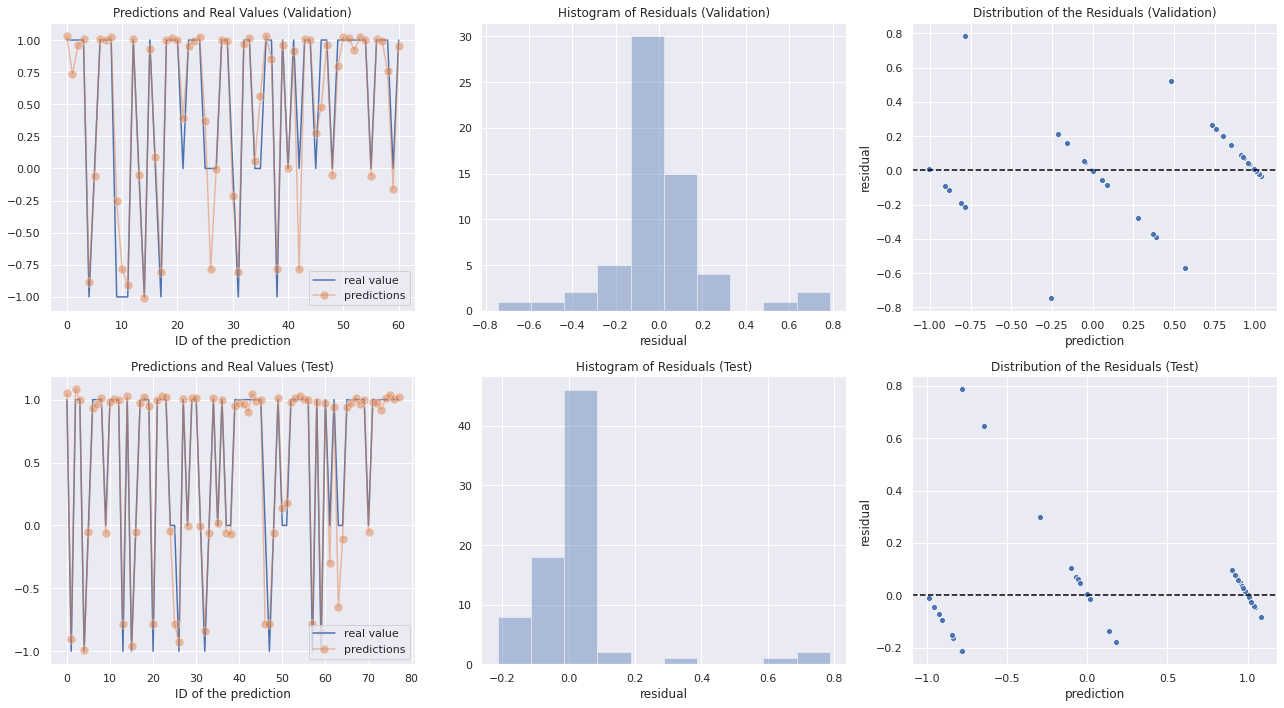

In [101]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='sv',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='sv',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['sv_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['sv_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='sv',
                y='sv_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='sv',
                y='sv_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('svr_rbf.pdf'), dpi=150, format='pdf')

### Random Forests

We now consider the case of random forests of decision trees.

In [102]:
from lightgbm        import LGBMRegressor
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error, \
                            r2_score
from skopt           import gp_minimize
from skopt.space     import Categorical, Integer, Real
from skopt.utils     import use_named_args

log.info('Fitting the random forests.')

# define the model
rnd_for = LGBMRegressor(boosting_type = 'rf',
                        objective = 'regression',
                        subsample_freq = 1,
                        n_jobs = 1)

# define the hyperparameters
hyperparameters = [Integer(2, 100, name='num_leaves'),
                   Integer(50, 300, name='max_depth'),
                   Integer(2, 50, name='n_estimators'),
                   Real(0.1, 0.99, name='subsample'),
                   Real(0.7, 1.0, name='colsample_bytree'),
                   Real(1.0e-6, 1.0e-2,
                        prior='log-uniform',
                        name='min_child_weight'
                       ),
                   Real(1.0e-1, 1.0e2, prior='log-uniform', name='reg_alpha'),
                   Real(1.0e-1, 1.0e2, prior='log-uniform', name='reg_lambda')
                  ]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    rnd_for.set_params(**args)
    rnd_for.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = rnd_for.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
rnd_for_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=125,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [103]:
# extract the hyperparameters
rnd_for_hyper = dict(zip(hyper_names, rnd_for_res.x))
print('Best hyperparameters:\n')
for key, value in rnd_for_hyper.items():
    if isinstance(value, float):
        print('  {}: {:.9f}'.format(key, value))
    else:
        print('  {}: {}'.format(key, value))

Best hyperparameters:

  num_leaves: 63
  max_depth: 300
  n_estimators: 26
  subsample: 0.851980203
  colsample_bytree: 0.700000000
  min_child_weight: 0.000016962
  reg_alpha: 0.309559726
  reg_lambda: 0.252138433


We then train the algorithm again on the training set and compute metrics and predictions:

In [104]:
# train the new algorithm
rnd_for = rnd_for.set_params(**rnd_for_hyper)
rnd_for = rnd_for.fit(X_train, y_train)

# compute predictions
rnd_for_train_pred = rnd_for.predict(X_train).reshape(-1,)
rnd_for_val_pred   = rnd_for.predict(X_val).reshape(-1,)
rnd_for_test_pred  = rnd_for.predict(X_test).reshape(-1,)

# store metrics
rnd_for_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   rnd_for_train_pred
                                                  ),
                   'tr_mae':    mean_absolute_error(y_train,
                                                    rnd_for_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         rnd_for_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   rnd_for_val_pred
                                                  ),
                   'v_mae':     mean_absolute_error(y_val,
                                                    rnd_for_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         rnd_for_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   rnd_for_test_pred
                                                  ),
                   'te_mae':    mean_absolute_error(y_test,
                                                    rnd_for_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         rnd_for_test_pred
                                        ),
                  }
rnd_for_metrics = pd.DataFrame(rnd_for_metrics, index=['rnd_for'])

We then print the metrics for comparison:

In [105]:
print(\
'RANDOM FORESTS:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}\n'.format(rnd_for_metrics['tr_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(rnd_for_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(rnd_for_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}\n'.format(rnd_for_metrics['v_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(rnd_for_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(rnd_for_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}\n'.format(rnd_for_metrics['te_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(rnd_for_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(rnd_for_metrics['te_rsq'].squeeze())
)

RANDOM FORESTS:

   Training set:

     MSE: 0.022
     MAE: 0.061
     R2:  0.956

   Validation set:

     MSE: 0.033
     MAE: 0.088
     R2:  0.935

   Test set:

     MSE: 0.013
     MAE: 0.053
     R2:  0.974




We can now save the predictions in the database of predictions we prepared:

In [106]:
# store training predictions
ml_train_predictions['rf']     = rnd_for_train_pred
ml_train_predictions['rf_res'] = y_train - rnd_for_train_pred

# store validation predictions
ml_val_predictions['rf']     = rnd_for_val_pred
ml_val_predictions['rf_res'] = y_val - rnd_for_val_pred

# store test predictions
ml_test_predictions['rf']     = rnd_for_test_pred
ml_test_predictions['rf_res'] = y_test - rnd_for_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

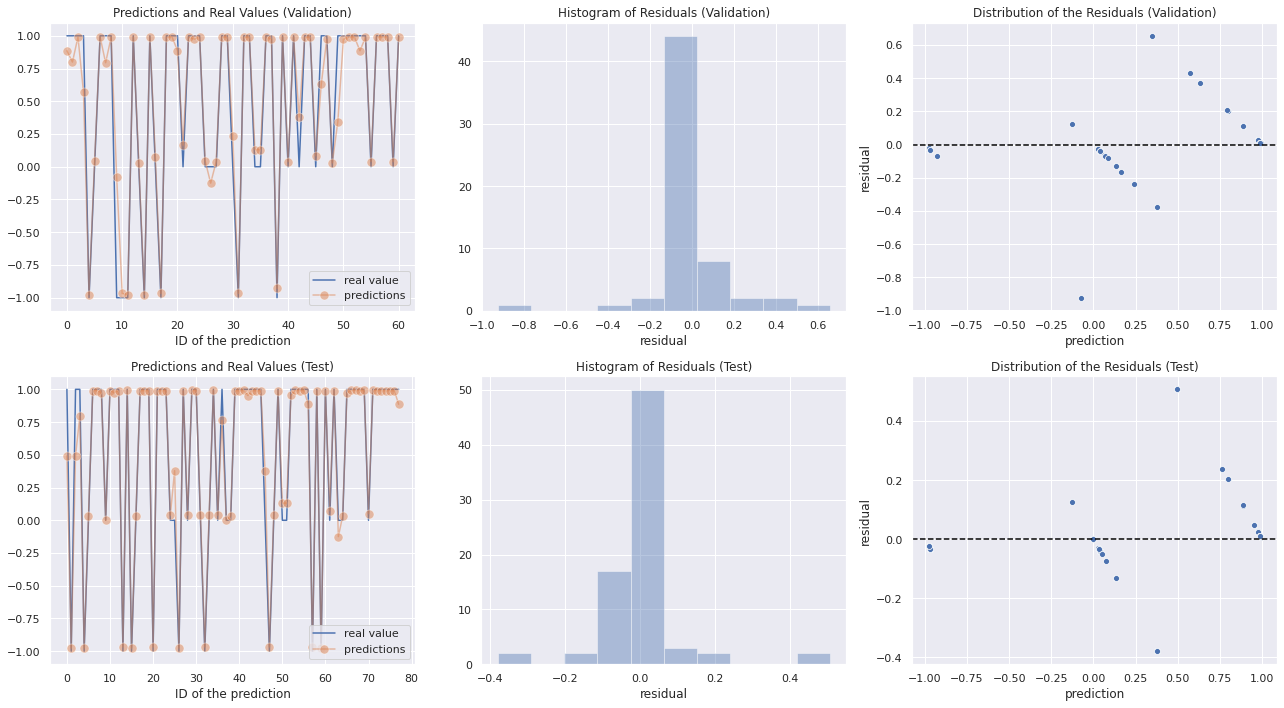

In [107]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='rf',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='rf',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['rf_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['rf_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='rf',
                y='rf_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='rf',
                y='rf_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('rnd_for.pdf'), dpi=150, format='pdf')

### Gradient Boosted Decision Trees

As a final experiment with decision trees, we consider the case of _gradient boosting_.

In [108]:
from lightgbm        import LGBMRegressor
from sklearn.metrics import mean_squared_error, \
                            mean_absolute_error, \
                            r2_score
from skopt           import gp_minimize
from skopt.space     import Categorical, Integer, Real
from skopt.utils     import use_named_args

log.info('Fitting the gradient boosted decision trees.')

# define the model
grd_bst = LGBMRegressor(boosting_type = 'gbdt',
                        objective = 'regression',
                        subsample_freq = 1,
                        n_jobs = 1)

# define the hyperparameters
hyperparameters = [Integer(2, 25, name='num_leaves'),
                   Integer(2, 25, name='max_depth'),
                   Integer(1e1, 4e3,
                           prior='log-uniform',
                           name='n_estimators'
                          ),
                   Real(0.1, 0.99, name='subsample'),
                   Real(0.7, 1.0, name='colsample_bytree'),
                   Real(1.0e-3, 1.0e-1,
                        prior='log-uniform',
                        name='min_child_weight'
                       ),
                   Real(1.0e0, 1.0e2, prior='log-uniform', name='reg_alpha'),
                   Real(1.0e0, 1.0e3, prior='log-uniform', name='reg_lambda')
                  ]
hyper_names     = [s.name for s in hyperparameters]

# minimise the objective
@use_named_args(hyperparameters)
def objective(**args):
    '''
    Compute the objective function.
    
    Arguments:
        **args: arguments to pass to the estimator
    '''
    log.debug('Exploring {}'.format(args)) # log the exploration point

    # fit the estimator
    grd_bst.set_params(**args)
    grd_bst.fit(X_train, y_train)

    # compute predictions on the validation set
    y_val_pred = grd_bst.predict(X_val).reshape(-1,)
    
    return mean_squared_error(y_val, y_val_pred)

# compute the minimisation
grd_bst_res = gp_minimize(objective,
                          hyperparameters,
                          n_calls=125,
                          random_state=RAND,
                          n_jobs=THREADS
                         )

From the previous computation we extract the values of the hyperparameters:

In [109]:
# extract the hyperparameters
grd_bst_hyper = dict(zip(hyper_names, grd_bst_res.x))
print('Best hyperparameters:\n')
for key, value in grd_bst_hyper.items():
    if isinstance(value, float):
        print('  {}: {:.3f}'.format(key, value))
    else:
        print('  {}: {}'.format(key, value))

Best hyperparameters:

  num_leaves: 25
  max_depth: 25
  n_estimators: 3889
  subsample: 0.990
  colsample_bytree: 1.000
  min_child_weight: 0.001
  reg_alpha: 1.000
  reg_lambda: 1000.000


We then train the algorithm again on the training set and compute metrics and predictions:

In [110]:
# train the new algorithm
grd_bst = grd_bst.set_params(**grd_bst_hyper)
grd_bst = grd_bst.fit(X_train, y_train)

# compute predictions
grd_bst_train_pred = grd_bst.predict(X_train).reshape(-1,)
grd_bst_val_pred   = grd_bst.predict(X_val).reshape(-1,)
grd_bst_test_pred  = grd_bst.predict(X_test).reshape(-1,)

# store metrics
grd_bst_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   grd_bst_train_pred
                                                  ),
                   'tr_mae':    mean_absolute_error(y_train,
                                                    grd_bst_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         grd_bst_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   grd_bst_val_pred
                                                  ),
                   'v_mae':     mean_absolute_error(y_val,
                                                    grd_bst_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         grd_bst_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   grd_bst_test_pred
                                                  ),
                   'te_mae':    mean_absolute_error(y_test,
                                                    grd_bst_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         grd_bst_test_pred
                                        ),
                  }
grd_bst_metrics = pd.DataFrame(grd_bst_metrics, index=['grd_bst'])

We then print the metrics for comparison:

In [111]:
print(\
'GRADIENT BOOSTED DECISION TREES:\n\n',
'  Training set:\n\n',
'    MSE: {:.4f}\n'.format(grd_bst_metrics['tr_mse'].squeeze()),
'    MAE: {:.4f}\n'.format(grd_bst_metrics['tr_mae'].squeeze()),
'    R2:  {:.4f}\n\n'.format(grd_bst_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.4f}\n'.format(grd_bst_metrics['v_mse'].squeeze()),
'    MAE: {:.4f}\n'.format(grd_bst_metrics['v_mae'].squeeze()),
'    R2:  {:.4f}\n\n'.format(grd_bst_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.4f}\n'.format(grd_bst_metrics['te_mse'].squeeze()),
'    MAE: {:.4f}\n'.format(grd_bst_metrics['te_mae'].squeeze()),
'    R2:  {:.4f}\n\n'.format(grd_bst_metrics['te_rsq'].squeeze())
)

GRADIENT BOOSTED DECISION TREES:

   Training set:

     MSE: 0.0041
     MAE: 0.0230
     R2:  0.9918

   Validation set:

     MSE: 0.0080
     MAE: 0.0416
     R2:  0.9844

   Test set:

     MSE: 0.0010
     MAE: 0.0199
     R2:  0.9980




We can now save the predictions in the database of predictions we prepared:

In [112]:
# store training predictions
ml_train_predictions['bt']     = grd_bst_train_pred
ml_train_predictions['bt_res'] = y_train - grd_bst_train_pred

# store validation predictions
ml_val_predictions['bt']     = grd_bst_val_pred
ml_val_predictions['bt_res'] = y_val - grd_bst_val_pred

# store test predictions
ml_test_predictions['bt']     = grd_bst_test_pred
ml_test_predictions['bt_res'] = y_test - grd_bst_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

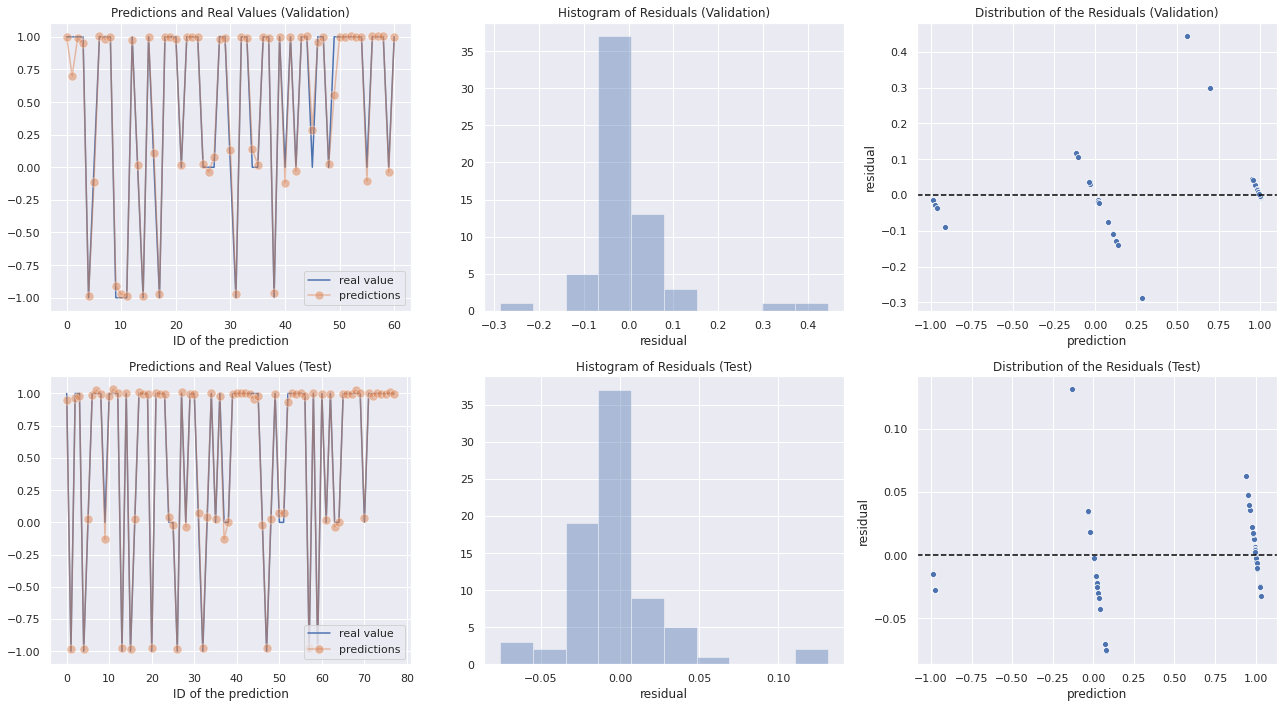

In [113]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='bt',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='bt',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['bt_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['bt_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='bt',
                y='bt_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='bt',
                y='bt_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('grd_bst.pdf'), dpi=150, format='pdf')

### Artificial Neural Networks

As a final model we use a simple fully connected (FC) ANN to predict the labels. We first build the model (it should not be too complicated, thus we can actually use the `Sequential` interface in `tf.keras`).

In [114]:
from tensorflow       import keras
from tensorflow.keras import layers, \
                             initializers, \
                             optimizers, \
                             regularizers, \
                             losses, \
                             metrics
from sklearn.metrics  import mean_squared_error, \
                             mean_absolute_error, \
                             r2_score

# clear leftover sessions
keras.backend.clear_session()

# build shortcuts to include layers
inputer  = lambda n: layers.Dense(n,
                         input_shape=X_train.shape[1:],
                         activation='relu',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.20)
                        )
denser   = lambda n: layers.Dense(n,
                         activation='relu',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.05)
                        )
dropper  = lambda x: layers.Dropout(rate=x, seed=RAND)
outputer = lambda n: layers.Dense(n,
                         name='output',
                         kernel_initializer=initializers.glorot_uniform(RAND),
                         bias_initializer=tf.zeros_initializer(),
                         #activity_regularizer=regularizers.l2(0.05)
                        )

# build the model
ann_mod = keras.Sequential(name='sft-trunc')

ann_mod.add(inputer(30))
ann_mod.add(layers.BatchNormalization())
ann_mod.add(dropper(0.01))

ann_mod.add(outputer(1))

# compile the model
ann_mod.compile(optimizer=optimizers.Adam(learning_rate=0.01),
                loss=losses.MeanSquaredError(),
                metrics=[metrics.MeanSquaredError()]
               )

ann_mod.summary()

Model: "sft-trunc"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 30)                600       
_________________________________________________________________
batch_normalization (BatchNo (None, 30)                120       
_________________________________________________________________
dropout (Dropout)            (None, 30)                0         
_________________________________________________________________
output (Dense)               (None, 1)                 31        
Total params: 751
Trainable params: 691
Non-trainable params: 60
_________________________________________________________________


We then fit the model on the training data:

In [115]:
from tensorflow.keras import callbacks

log.info('Fitting the artificial neural network.')

# define callbacks
callbacks = [callbacks.ModelCheckpoint(modpath('ann_mod.h5'),
                                       monitor='val_loss',
                                       verbose=0,
                                       save_best_only=True
                                      )
            ]

# fit the model
ann_mod_hst = ann_mod.fit(X_train,
                          y_train,
                          batch_size=X_train.shape[0],
                          epochs=5000,
                          verbose=0,
                          callbacks=callbacks,
                          validation_data=(X_val, y_val)
                         )

# load the best model
ann_mod = keras.models.load_model(modpath('ann_mod.h5'))

We can then look at the history of the model and plot the loss and the metric functions:

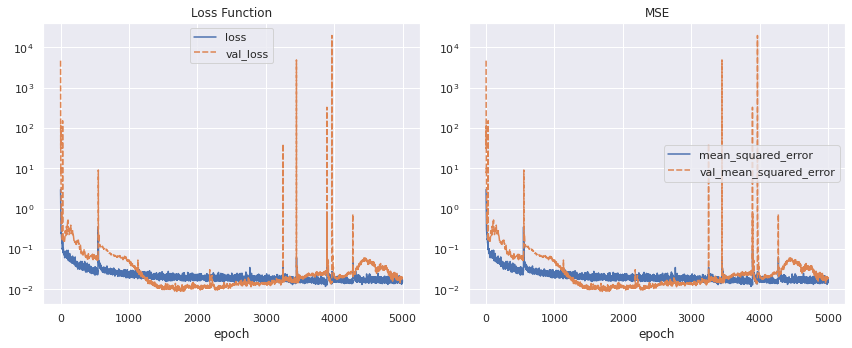

In [116]:
ann_mod_history = pd.DataFrame(ann_mod_hst.history)

fig, ax = subplots(1,2)

sns.lineplot(data=ann_mod_history[['loss', 'val_loss']],
             ax=ax[0]
            )
ax[0].set(title='Loss Function',
          xlabel='epoch',
          yscale='log'
         )

sns.lineplot(data=ann_mod_history[['mean_squared_error',
                                   'val_mean_squared_error'
                                  ]
                                 ],
             ax=ax[1]
            )
ax[1].set(title='MSE',
          xlabel='epoch',
          yscale='log'
         )
        
plt.tight_layout()
plt.savefig(imgpath('ann_hst.pdf'), dpi=150, format='pdf')

We can also graph the same plots applying a _running average_ over the epochs in order to better distinguish the evolution:

In [117]:
def run_avg(values: pd.Series, window: float) -> np.ndarray:
    '''
    Compute the (simple) running average of a series of data.
    
    Required arguments:
        values: list of values,
        window: temporal window for the computation.
    '''
    values = values.values.reshape(-1,)
    avg    = np.zeros((np.shape(values)[0] - window + 1,))
    
    for i in range(avg.shape[0]):
        avg[i] = np.sum(values[i:i + window]) / window
    
    return avg

# select a "time" window
win = int(ann_mod_history.shape[0] / 10)
run_avg(ann_mod_history['loss'], win)
avg = pd.DataFrame({f: run_avg(ann_mod_history[f], win).reshape(-1,)
                    for f in ann_mod_history
                   }
                  )

From this we can plot a more understandable evolution:

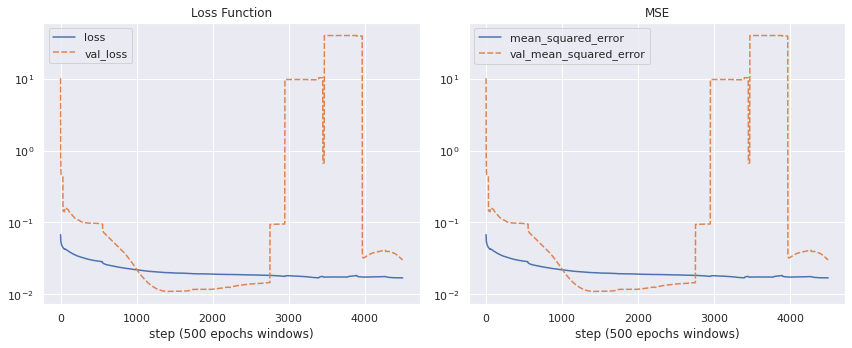

In [118]:
# plot the dataframe
fig, ax = subplots(1,2)

sns.lineplot(data=avg[['loss', 'val_loss']],
             ax=ax[0]
            )
ax[0].set(title='Loss Function',
          xlabel='step ({:d} epochs windows)'.format(win),
          yscale='log'
         )

sns.lineplot(data=avg[['mean_squared_error', 'val_mean_squared_error']],
             ax=ax[1]
            )
ax[1].set(title='MSE',
          xlabel='step ({:d} epochs windows)'.format(win),
          yscale='log'
         )
        
plt.tight_layout()
plt.savefig(imgpath('ann_hst_avg.pdf'), dpi=150, format='pdf')

We can also save the simple architecture to file:

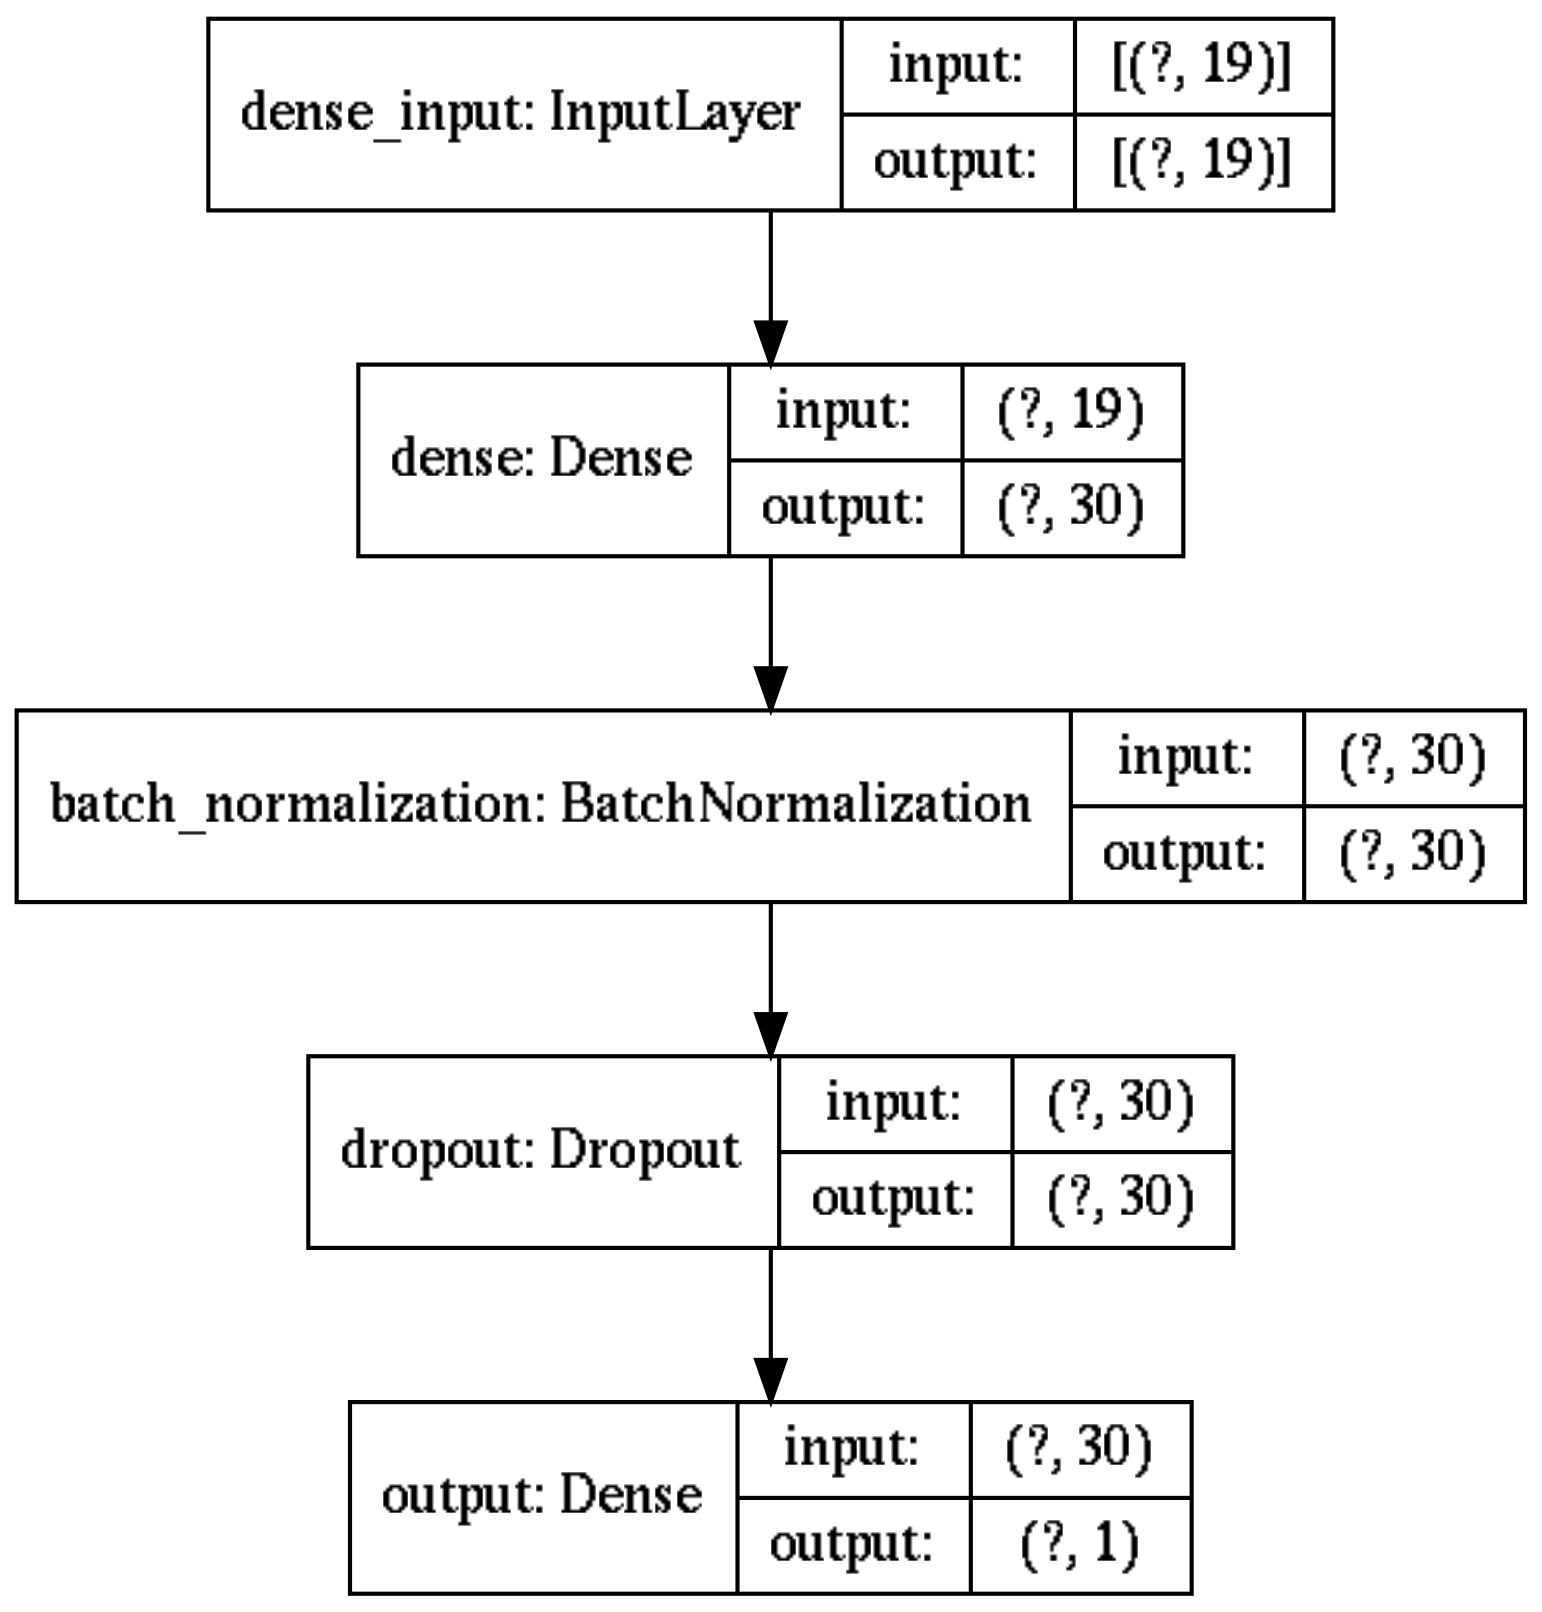

In [119]:
from IPython.display import Image

ann_mod_dot = keras.utils.model_to_dot(ann_mod, show_shapes=True, dpi=300)
ann_mod_dot.write_pdf(imgpath('ann_mod_arch.pdf'))

Image(ann_mod_dot.create_png(), width=480)

We finally compute the predictions and metrics:

In [120]:
# compute predictions
ann_mod_train_pred = ann_mod.predict(X_train).reshape(-1,)
ann_mod_val_pred   = ann_mod.predict(X_val).reshape(-1,)
ann_mod_test_pred  = ann_mod.predict(X_test).reshape(-1,)

# store metrics
ann_mod_metrics = {'tr_mse':    mean_squared_error(y_train,
                                                   ann_mod_train_pred
                                                  ),
                   'tr_mae':    mean_absolute_error(y_train,
                                                    ann_mod_train_pred
                                                   ),
                   'tr_rsq':    r2_score(y_train,
                                         ann_mod_train_pred
                                        ),
                   'v_mse':     mean_squared_error(y_val,
                                                   ann_mod_val_pred
                                                  ),
                   'v_mae':     mean_absolute_error(y_val,
                                                    ann_mod_val_pred
                                                   ),
                   'v_rsq':     r2_score(y_val,
                                         ann_mod_val_pred
                                        ),
                   'te_mse':    mean_squared_error(y_test,
                                                   ann_mod_test_pred
                                                  ),
                   'te_mae':    mean_absolute_error(y_test,
                                                    ann_mod_test_pred
                                                   ),
                   'te_rsq':    r2_score(y_test,
                                         ann_mod_test_pred
                                        ),
                  }
ann_mod_metrics = pd.DataFrame(ann_mod_metrics, index=['ann_mod'])

print(\
'ARTIFICIAL NEURAL NETWORKS:\n\n',
'  Training set:\n\n',
'    MSE: {:.3f}\n'.format(ann_mod_metrics['tr_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(ann_mod_metrics['tr_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(ann_mod_metrics['tr_rsq'].squeeze()),
'  Validation set:\n\n',
'    MSE: {:.3f}\n'.format(ann_mod_metrics['v_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(ann_mod_metrics['v_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(ann_mod_metrics['v_rsq'].squeeze()),
'  Test set:\n\n',
'    MSE: {:.3f}\n'.format(ann_mod_metrics['te_mse'].squeeze()),
'    MAE: {:.3f}\n'.format(ann_mod_metrics['te_mae'].squeeze()),
'    R2:  {:.3f}\n\n'.format(ann_mod_metrics['te_rsq'].squeeze())
)

ARTIFICIAL NEURAL NETWORKS:

   Training set:

     MSE: 0.015
     MAE: 0.055
     R2:  0.969

   Validation set:

     MSE: 0.009
     MAE: 0.058
     R2:  0.983

   Test set:

     MSE: 0.005
     MAE: 0.052
     R2:  0.989




We then save the predictions of the ANN:

In [121]:
# store training predictions
ml_train_predictions['nn']     = ann_mod_train_pred
ml_train_predictions['nn_res'] = y_train - ann_mod_train_pred

# store validation predictions
ml_val_predictions['nn']     = ann_mod_val_pred
ml_val_predictions['nn_res'] = y_val - ann_mod_val_pred

# store test predictions
ml_test_predictions['nn']     = ann_mod_test_pred
ml_test_predictions['nn_res'] = y_test - ann_mod_test_pred

We finally plot the histogram of errors, the predictions and the residual distribution:

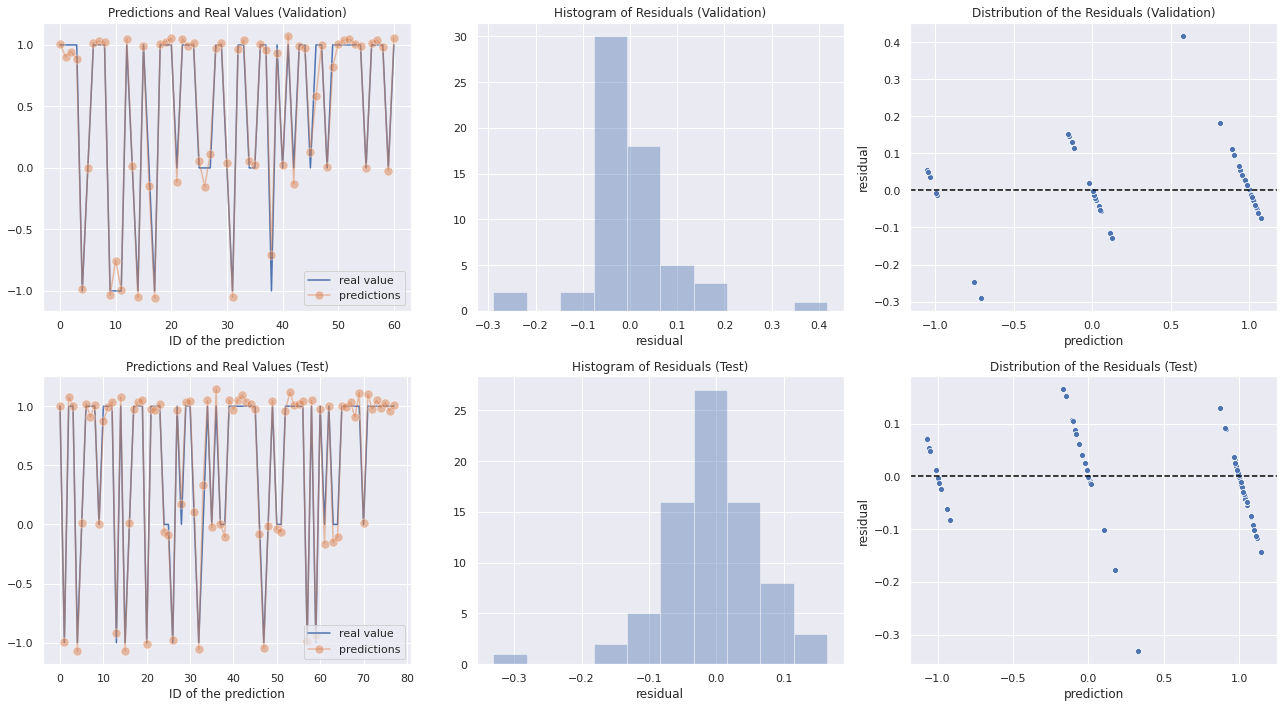

In [122]:
fig, ax = subplots(2,3)

# plot the predictions
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[0,0]
            )
sns.lineplot(data=ml_val_predictions,
             x=ml_val_predictions.index,
             y='nn',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[0,0]
            )
ax[0,0].set(title='Predictions and Real Values (Validation)',
            xlabel='ID of the prediction',
            ylabel=''
           )

sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='exp',
             label='real value',
             alpha=1.0,
             ax=ax[1,0]
            )
sns.lineplot(data=ml_test_predictions,
             x=ml_test_predictions.index,
             y='nn',
             label='predictions',
             markers=True,
             marker='o',
             markersize=9,
             alpha=0.5,
             ax=ax[1,0]
            )
ax[1,0].set(title='Predictions and Real Values (Test)',
            xlabel='ID of the prediction',
            ylabel=''
           )

# plot the histogram of residuals
sns.distplot(ml_val_predictions['nn_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[0,1]
            )
ax[0,1].set(title='Histogram of Residuals (Validation)')

sns.distplot(ml_test_predictions['nn_res'],
             bins=10,
             kde=False,
             axlabel='residual',
             ax=ax[1,1]
            )
ax[1,1].set(title='Histogram of Residuals (Test)')

# plot the distribution of the residuals
sns.scatterplot(data=ml_val_predictions,
                x='nn',
                y='nn_res',
                ax=ax[0,2]
               )
ax[0,2].axhline(0,
                color='black',
                ls='--'
               )
ax[0,2].set(title='Distribution of the Residuals (Validation)',
            xlabel='prediction',
            ylabel='residual'
           )

sns.scatterplot(data=ml_test_predictions,
                x='nn',
                y='nn_res',
                ax=ax[1,2]
               )
ax[1,2].axhline(0,
                color='black',
                ls='--'
               )
ax[1,2].set(title='Distribution of the Residuals (Test)',
            xlabel='prediction',
            ylabel='residual'
           )
        
plt.tight_layout()
plt.savefig(imgpath('ann_mod.pdf'), dpi=150, format='pdf')

# Saving the Output

Before proceeding further, we save the output of the analysis into CSV and JSON files to have access to them at later times.

We start from the predictions for training, validation and test sets:

In [123]:
log.debug('End of the regression analysis.')

# rename the columns
rename_columns = {'lr':     'lin_reg',
                  'lr_res': 'lin_reg_residuals',
                  'en':     'els_net',
                  'en_res': 'els_net_residuals',
                  'ls':     'lasso',
                  'ls_res': 'lasso_residuals',
                  'rd':     'ridge',
                  'rd_res': 'ridge_residuals',
                  'lv':     'lin_svr',
                  'lv_res': 'lin_svr_residuals',
                  'sv':     'svr_rbf',
                  'sv_res': 'svr_rbf_residuals',
                  'rf':     'rnd_for',
                  'rf_res': 'rnd_for_residuals',
                  'bt':     'grd_bst',
                  'bt_res': 'grd_bst_residuals',
                  'nn':     'ann_mod',
                  'nn_res': 'ann_mod_residuals'
                 }

# save predictions to file
ml_train_predictions.rename(columns=rename_columns).\
                        sort_values(ordering_columns, ignore_index=True).\
                        to_csv(datpath('sft-train-pred.csv'), index=False)
ml_val_predictions.rename(columns=rename_columns).\
                        sort_values(ordering_columns, ignore_index=True).\
                        to_csv(datpath('sft-val-pred.csv'), index=False)
ml_test_predictions.rename(columns=rename_columns).\
                        sort_values(ordering_columns, ignore_index=True).\
                        to_csv(datpath('sft-test-pred.csv'), index=False)

We then save the trained models to file:

In [124]:
import joblib
import json

# save models to file (ANN already saved)
joblib.dump(lin_reg, modpath('lin_reg.pkl'))
joblib.dump(els_net, modpath('els_net.pkl'))
joblib.dump(lss_reg, modpath('lasso.pkl'))
joblib.dump(rdg_reg, modpath('ridge.pkl'))
joblib.dump(lin_svr, modpath('lin_svr.pkl'))
joblib.dump(svr_rbf, modpath('svr_rbf.pkl'))
joblib.dump(rnd_for, modpath('rnd_for.pkl'))
joblib.dump(grd_bst, modpath('grd_bst.pkl'))

# save the hyperparameters to JSON
with open(outpath('els_net_hyp.json'), 'w') as f:
    json.dump(els_net_hyper, f)
with open(outpath('lasso_hyp.json'), 'w') as f:
    json.dump(lss_reg_hyper, f)
with open(outpath('ridge_hyp.json'), 'w') as f:
    json.dump(rdg_reg_hyper, f)
with open(outpath('lin_svr_hyp.json'), 'w') as f:
    json.dump(lin_svr_hyper, f)
with open(outpath('svr_rbf_hyp.json'), 'w') as f:
    json.dump(svr_rbf_hyper, f)
with open(outpath('rnd_for_hyp.json'), 'w') as f:
    json.dump({key: float(value) for key, value in rnd_for_hyper.items()}, f)
with open(outpath('grd_bst_hyp.json'), 'w') as f:
    json.dump({key: float(value) for key, value in grd_bst_hyper.items()}, f)

We finally save the metrics of the algorithms in a separate CSV file:

In [125]:
# collect the metrics in a dataframe
ml_metrics = pd.concat([lin_reg_metrics,
                        els_net_metrics,
                        lss_reg_metrics,
                        rdg_reg_metrics,
                        lin_svr_metrics,
                        svr_rbf_metrics,
                        rnd_for_metrics,
                        grd_bst_metrics,
                        ann_mod_metrics
                       ]
                      )

# list the algorithms in the index
algorithms   = ['LR', 'EN', 'Lasso', 'Ridge',
                'l-SVR', 'r-SVR',
                'RF', 'GBDT',
                'ANN'
               ]
index_mapper = dict(zip(ml_metrics.index, algorithms))

# list the metrics in the columns
metrics = ['training MSE',
           'training MSE 95% CI (lower bound)',
           'training MSE 95% CI (upper bound)',
           'training MAE',
           'training R2',
           'validation MSE',
           'validation MSE 95% CI (lower bound)',
           'validation MSE 95% CI (upper bound)',
           'validation MAE',
           'validation R2',
           'test MSE',
           'test MSE 95% CI (lower bound)',
           'test MSE 95% CI (upper bound)',
           'test MAE',
           'test R2'
          ]
column_mapper = dict(zip(ml_metrics.columns, metrics))

# insert new index and new columns
ml_metrics = ml_metrics.rename(columns=column_mapper, index=index_mapper)
ml_metrics.to_csv(outpath('metrics.csv'))

# _A Posteriori_ Analysis of the Decision Trees

As a last step in the analysis, we take a few moments to discuss the importance of the training features inside the **decision trees** and study the _Shapley_ values of the variables in order to better understand the underlying choices of the algorithms. We apply the analysis on the test which has not been used for training since we are interested in "real world" scenarios (i.e. untouched sets).

In [126]:
import shap

# import the "explainers" and save the values
rnd_for_exp = shap.TreeExplainer(rnd_for)
grd_bst_exp = shap.TreeExplainer(grd_bst)

# extract the Shapley values
rnd_for_shap     = rnd_for_exp.shap_values(X_test)
grd_bst_shap     = grd_bst_exp.shap_values(X_test)
rnd_for_int_shap = rnd_for_exp.shap_interaction_values(X_test)
grd_bst_int_shap = grd_bst_exp.shap_interaction_values(X_test)

# compute the feature importance
rnd_for_imp = rnd_for.feature_importances_.reshape(-1,)
grd_bst_imp = grd_bst.feature_importances_.reshape(-1,)

# finally store the names of the features
features = list(X_test.columns)

We can therefore show the Shapley values in plots. We show the importance of the features as computed from the decision trees (i.e. the LightGBM trees), the mean Shapley values for each feature and the interaction Shapley values for a **randomly chosen** sample in the test set.

We start from the **RF**:

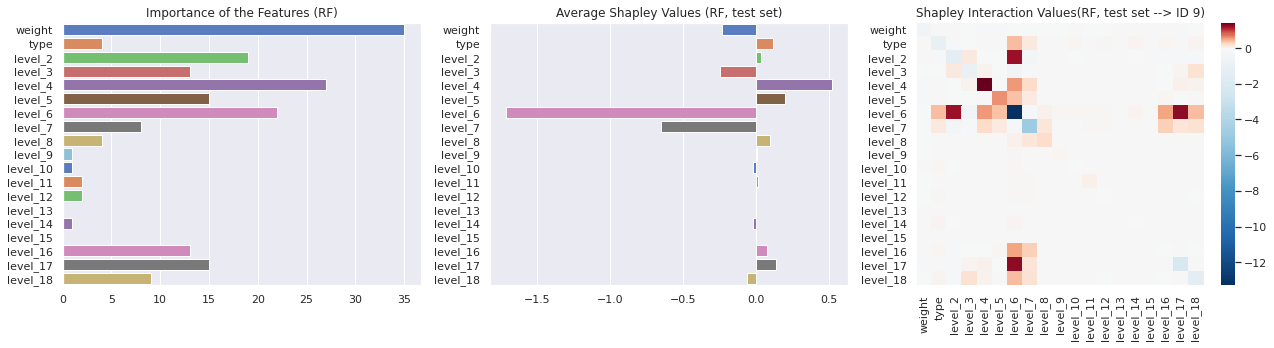

In [127]:
fig, ax = subplots(1,3)

# plot the importance of the features
sns.barplot(x=rnd_for_imp,
            y=features,
            palette=sns.color_palette('muted', len(features)),
            ax=ax[0]
           )
ax[0].set(title='Importance of the Features (RF)')

# plot the mean Shapley values
sns.barplot(x=rnd_for_shap.mean(axis=0),
            y=features,
            palette=sns.color_palette('muted', len(features)),
            ax=ax[1]
           )
ax[1].set(title='Average Shapley Values (RF, test set)')

# choose one random matrix and plot the heatmap
random = np.random.randint(rnd_for_int_shap.shape[0])
matrix = rnd_for_int_shap[random]
sns.heatmap(matrix,
            vmin=matrix.min(),
            vmax=matrix.max(),
            norm=mpl.colors.DivergingNorm(0.0),
            xticklabels=features,
            yticklabels=features,
            cmap='RdBu_r',
            ax=ax[2]
           )
ax[2].set(title='Shapley Interaction Values'
                '(RF, test set --> ID {:d})'.format(random))
        
plt.tight_layout()
plt.savefig(imgpath('rnd_for_shapley.pdf'), dpi=150, format='pdf')

A peculiar feature of the random forests seems to be a relatively high importance of lower truncation levels, while most of the features do not play a central role. The interaction between the features seems to be rather non existent (there are a couple of features who strongly play one against the other) and may be the cause of the difficulty in training the linear models.

We then consider the **GBDT**:

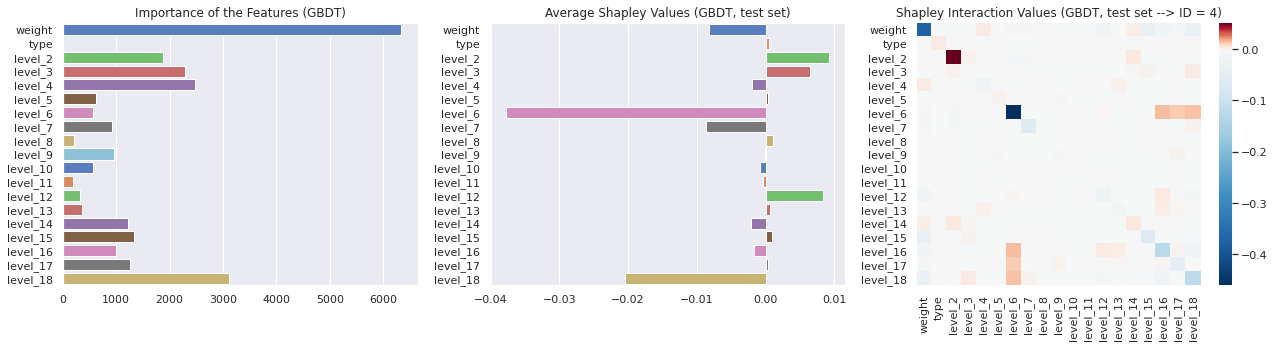

In [128]:
fig, ax = subplots(1,3)

# plot the importance of the features
sns.barplot(x=grd_bst_imp,
            y=features,
            palette=sns.color_palette('muted', len(features)),
            ax=ax[0]
           )
ax[0].set(title='Importance of the Features (GBDT)')

# plot the mean Shapley values
sns.barplot(x=grd_bst_shap.mean(axis=0),
            y=features,
            palette=sns.color_palette('muted', len(features)),
            ax=ax[1]
           )
ax[1].set(title='Average Shapley Values (GBDT, test set)')

# choose one random matrix and plot the heatmap
random = np.random.randint(grd_bst_int_shap.shape[0])
matrix = grd_bst_int_shap[random]
sns.heatmap(matrix,
            vmin=matrix.min(),
            vmax=matrix.max(),
            norm=mpl.colors.DivergingNorm(0.0),
            xticklabels=features,
            yticklabels=features,
            cmap='RdBu_r',
            ax=ax[2]
           )
ax[2].set(title='Shapley Interaction Values '
                '(GBDT, test set --> ID = {:d})'.format(random))
        
plt.tight_layout()
plt.savefig(imgpath('grd_bst_shapley.pdf'), dpi=150, format='pdf')

Differently from RF, GBDT attach greater importance to more features (with a predominance of the `weight`, as one might have expected from the pre-analysis). Interaction between features are even milder, but the mean Shapley values are more heterogeneous.

# Conclusions

As we saw in the pre-analysis and the EDA, the dataset can be quite tricky and difficult to use for training ML algorithms. In particular the EDA underlined some patterns inside the definition of the variables which lead to issues for the learning estimators. We were able to determine that for a certain range of the weight of the observables (namely `weight` $< 1.5$) there is structure to the data and the extrapolation of the labels can already be quite good using unsupervised learning. However the determination of the coefficients of the linear algorithms (strictly without regularisation) seem to be quite precise. We also saw that SVM algorithms fail most of the times in adapting to the datasets while decision trees and neural networks can respond better.